# Обучение регрессионных задач по проекту ML 2024

## House 16H

Установка необходимых библиотек.

In [1]:
!pip install lightgbm
!pip install catboost
!pip install xgboost
!pip install torch


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 101.1/101.1 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 47.2/47.2 kB ? eta 0:00:00
     ---------------------------------------- 15.7/15.7 MB 7.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт используемых библиотек.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.io import arff
from os import listdir, getcwd, chdir, mkdir
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
import numpy as np
from sklearn.utils import resample
from scipy import stats
from scipy.stats import t
from catboost import CatBoostRegressor
import math
import warnings
warnings.filterwarnings("ignore")
from collections import OrderedDict
from typing import Any, Dict, List, Optional, Union
try:
    import sklearn.tree as sklearn_tree
except ImportError:
    sklearn_tree = None

import torch
import torch.nn as nn
from torch import Tensor
try:
    from tqdm import tqdm
except ImportError:
    tqdm = None

Для простоты я написал несколько функций, их импортироуем тут.

In [13]:
def boostraping(model, x_test,
                y_test, n_iterations = 20):
  """forms list of rmse scores

  Keyword arguments:
  model -- fitted model
  x_test -- features of test data
  y_test -- labels of test data
  n_iterations -- number of boostraping procedures (default 20)
  """
  accuracy = []
  for i in range(n_iterations):
      X_bs, y_bs = resample(x_test, y_test, replace=True)
      # make predictions
      y_hat = model.predict(X_bs)
      # evaluate model
      score = mean_squared_error(y_bs, y_hat, squared = False)
      accuracy.append(score)
  return accuracy

def project_train_simple(x_train, x_test, y_train, y_test):
  """Train project models and generate rmse scores and fitted models

  Keyword arguments:
  x_train -- features of train data
  y_train -- labels of train data
  x_test -- features of test data
  y_test -- labels of test data
  """
  models = [
            CatBoostRegressor(), xgboost.XGBRegressor(),
            RandomForestRegressor(max_depth=2, random_state=0), KernelRidge(alpha=1.0)
            ]

  test_score = []
  train_score = []
  model = []
  best_parameters = []
  for i, k in enumerate(models):
    print('Training '+str(k.__class__.__name__))
    # Step 1: Fit model
    k.fit(x_train, y_train)
    model.append(k.__class__.__name__)
    # Step 2: Calculate rmse scores
    train_score.append(mean_squared_error(y_train, k.predict(x_train), squared = False))
    test_score.append(mean_squared_error(y_test, k.predict(x_test), squared = False))
    best_parameters.append(k)
  data = {'model name': model, 'train score[RMSE]': train_score, 'test_score[RMSE]': test_score}
  df = pd.DataFrame(data)
  return df, best_parameters

def one_sample_t_test(sample, population_mean, alpha=0.05, tail="two"):
    """Make t-test and check
    H0: mean value of sample == population_mean

    Keyword arguments:
    sample -- list of means of fetches
    population_mean -- mean of distribution
    alpha -- the threshold value for rejecting a H0 (default 0.05) 0.01 for 99%
    tail -- method of the p-value calculation (default = "two", "left", "right")
    """
    # Step 1: Calculate T-score
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    sample_size = len(sample)

    t_score = (sample_mean - population_mean) / \
        (sample_std / np.sqrt(sample_size))

    # Step 2: Determine degrees of freedom
    df = sample_size - 1

    # Step 3: Identify the appropriate t-distribution
    # No need to explicitly specify degrees of freedom for one-sample t-test in scipy.stats.t

    # Step 4: Find the p-value
    if tail == "two":
        p_value = t.sf(np.abs(t_score), df) * 2  # for two-tailed test
    elif tail == "left":
        p_value = t.sf(t_score, df)  # for left-tailed test
    elif tail == "right":
        p_value = t.sf(-t_score, df)  # for right-tailed test
    else:
        raise ValueError(
            "Invalid tail argument. Use 'two', 'left', or 'right'.")

    # Step 5: Interpret the p-value
    print("P-value:", p_value)

    if p_value < alpha:
        print(
            "Reject the null hypothesis. There is a statistically significant difference.")
    else:
        print("Fail to reject the null hypothesis. There is no statistically significant difference.")
    return p_value


def project_train(x_train, x_test, y_train, y_test):
  """Train project models on gridsearchCV and generate rmse scores and fitted models

  Keyword arguments:
  x_train -- features of train data
  y_train -- labels of train data
  x_test -- features of test data
  y_test -- labels of test data
  """
  models = [
            CatBoostRegressor(), xgboost.XGBRegressor(),
            RandomForestRegressor(random_state=0), KernelRidge()
            ]
  grid = [
          {'iterations': [300],
           'learning_rate': [0.06],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 3, 5, 7]},

          {'learning_rate': [.03, 0.05, .07],
          'n_estimators': [500]},

          {'n_estimators': [100, 300],
          'max_depth': [None, 1, 2, 3]},

          {'alpha': [0.5, 2]}
          ]

  test_score = []
  train_score = []
  model = []
  best_parameters = []
  for i, k in enumerate(models):
    print('Training '+str(k.__class__.__name__))
    clf = GridSearchCV(k, grid[i])
    # Step 1: Fit model on gridsearchCV
    best_estimator = clf.fit(x_train, y_train)
    best_parameters.append(best_estimator)
    model.append(k.__class__.__name__)
    # Step 2: Calculate rmse scores
    train_score.append(mean_squared_error(y_train, best_estimator.predict(x_train), squared = False))
    test_score.append(mean_squared_error(y_test, best_estimator.predict(x_test), squared = False))

  data = {'model name': model, 'train score[RMSE]': train_score, 'test_score[RMSE]': test_score}
  df = pd.DataFrame(data)
  return df, best_parameters

def _check_bins(bins: List[Tensor]) -> None:
    if not bins:
        raise ValueError('The list of bins must not be empty')
    for i, feature_bins in enumerate(bins):
        if not isinstance(feature_bins, Tensor):
            raise ValueError(
                'bins must be a list of PyTorch tensors. '
                f'However, for {i=}: {type(bins[i])=}'
            )
        if feature_bins.ndim != 1:
            raise ValueError(
                'Each item of the bin list must have exactly one dimension.'
                f' However, for {i=}: {bins[i].ndim=}'
            )
        if len(feature_bins) < 2:
            raise ValueError(
                'All features must have at least two bin edges.'
                f' However, for {i=}: {len(bins[i])=}'
            )
        if not feature_bins.isfinite().all():
            raise ValueError(
                'Bin edges must not contain nan/inf/-inf.'
                f' However, this is not true for the {i}-th feature'
            )
        if (feature_bins[:-1] >= feature_bins[1:]).any():
            raise ValueError(
                'Bin edges must be sorted.'
                f' However, the for the {i}-th feature, the bin edges are not sorted'
            )
        if len(feature_bins) == 2:
            warnings.warn(
                f'The {i}-th feature has just two bin edges, which means only one bin.'
                ' Strictly speaking, using a single bin for the'
                ' piecewise-linear encoding should not break anything,'
                ' but it is the same as using sklearn.preprocessing.MinMaxScaler'
            )


def compute_bins(
    X: torch.Tensor,
    n_bins: int = 48,
    *,
    tree_kwargs: Optional[Dict[str, Any]] = None,
    y: Optional[Tensor] = None,
    regression: Optional[bool] = None,
    verbose: bool = False,
) -> List[Tensor]:
    """Compute bin edges for `PiecewiseLinearEmbeddings`.

    **Usage**

    Computing the quantile-based bins (Section 3.2.1 in the paper):

    >>> X_train = torch.randn(10000, 2)
    >>> bins = compute_bins(X_train)

    Computing the tree-based bins (Section 3.2.2 in the paper):

    >>> X_train = torch.randn(10000, 2)
    >>> y_train = torch.randn(len(X_train))
    >>> bins = compute_bins(
    ...     X_train,
    ...     y=y_train,
    ...     regression=True,
    ...     tree_kwargs={'min_samples_leaf': 64, 'min_impurity_decrease': 1e-4},
    ... )

    Args:
        X: the training features.
        n_bins: the number of bins.
        tree_kwargs: keyword arguments for `sklearn.tree.DecisionTreeRegressor`
            (if ``regression`` is `True`) or `sklearn.tree.DecisionTreeClassifier`
            (if ``regression`` is `False`).
            NOTE: requires ``scikit-learn>=1.0,>2`` to be installed.
        y: the training labels (must be provided if ``tree`` is not None).
        regression: whether the labels are regression labels
            (must be provided if ``tree`` is not None).
        verbose: if True and ``tree_kwargs`` is not None, than ``tqdm``
            (must be installed) will report the progress while fitting trees.
    Returns:
        A list of bin edges for all features. For one feature:

        - the maximum possible number of bin edges is ``n_bins + 1``.
        - the minumum possible number of bin edges is ``1``.
    """
    if not isinstance(X, Tensor):
        raise ValueError(f'X must be a PyTorch tensor, however: {type(X)=}')
    if X.ndim != 2:
        raise ValueError(f'X must have exactly two dimensions, however: {X.ndim=}')
    if X.shape[0] < 2:
        raise ValueError(f'X must have at least two rows, however: {X.shape[0]=}')
    if X.shape[1] < 1:
        raise ValueError(f'X must have at least one column, however: {X.shape[1]=}')
    if not X.isfinite().all():
        raise ValueError('X must not contain nan/inf/-inf.')
    if (X == X[0]).all(dim=0).any():
        raise ValueError(
            'All columns of X must have at least two distinct values.'
            ' However, X contains columns with just one distinct value.'
        )
    if n_bins <= 1 or n_bins >= len(X):
        raise ValueError(
            'n_bins must be more than 1, but less than len(X), however:'
            f' {n_bins=}, {len(X)=}'
        )

    if tree_kwargs is None:
        if y is not None or regression is not None or verbose:
            raise ValueError(
                'If tree_kwargs is None, then y must be None, regression must be None'
                ' and verbose must be False'
            )

        # NOTE[DIFF]
        # The original implementation in the official paper repository has an
        # unintentional divergence from what is written in the paper.
        # This package implements the algorithm described in the paper,
        # and it is recommended for future work
        # (this may affect the optimal number of bins
        #  reported in the official repository).
        #
        # Additional notes:
        # - this is the line where the divergence happens:
        #   (the thing is that limiting the number of quantiles by the number of
        #   distinct values is NOT the same as removing identical quantiles
        #   after computing them)
        #   https://github.com/yandex-research/tabular-dl-num-embeddings/blob/c1d9eb63c0685b51d7e1bc081cdce6ffdb8886a8/bin/train4.py#L612C30-L612C30
        # - for the tree-based bins, there is NO such divergence;
        bins = [
            q.unique()
            for q in torch.quantile(
                X, torch.linspace(0.0, 1.0, n_bins + 1).to(X), dim=0
            ).T
        ]
        _check_bins(bins)
        return bins
    else:
        if sklearn_tree is None:
            raise RuntimeError(
                'The scikit-learn package is missing.'
                ' See README.md for installation instructions'
            )
        if y is None or regression is None:
            raise ValueError(
                'If tree_kwargs is not None, then y and regression must not be None'
            )
        if y.ndim != 1:
            raise ValueError(f'y must have exactly one dimension, however: {y.ndim=}')
        if len(y) != len(X):
            raise ValueError(
                f'len(y) must be equal to len(X), however: {len(y)=}, {len(X)=}'
            )
        if y is None or regression is None:
            raise ValueError(
                'If tree_kwargs is not None, then y and regression must not be None'
            )
        if 'max_leaf_nodes' in tree_kwargs:
            raise ValueError(
                'tree_kwargs must not contain the key "max_leaf_nodes"'
                ' (it will be set to n_bins automatically).'
            )

        if verbose:
            if tqdm is None:
                raise ImportError('If verbose is True, tqdm must be installed')
            tqdm_ = tqdm
        else:
            tqdm_ = lambda x: x  # noqa: E731

        if X.device.type != 'cpu' or y.device.type != 'cpu':
            warnings.warn(
                'Computing tree-based bins involves the conversion of the input PyTorch'
                ' tensors to NumPy arrays. The provided PyTorch tensors are not'
                ' located on CPU, so the conversion has some overhead.',
                UserWarning,
            )
        X_numpy = X.cpu().numpy()
        y_numpy = y.cpu().numpy()
        bins = []
        for column in tqdm_(X_numpy.T):
            feature_bin_edges = [float(column.min()), float(column.max())]
            tree = (
                (
                    sklearn_tree.DecisionTreeRegressor
                    if regression
                    else sklearn_tree.DecisionTreeClassifier
                )(max_leaf_nodes=n_bins, **tree_kwargs)
                .fit(column.reshape(-1, 1), y_numpy)
                .tree_
            )
            for node_id in range(tree.node_count):
                # The following condition is True only for split nodes. Source:
                # https://scikit-learn.org/1.0/auto_examples/tree/plot_unveil_tree_structure.html#tree-structure
                if tree.children_left[node_id] != tree.children_right[node_id]:
                    feature_bin_edges.append(float(tree.threshold[node_id]))
            bins.append(torch.as_tensor(feature_bin_edges).unique())
        _check_bins(bins)
        return [x.to(device=X.device, dtype=X.dtype) for x in bins]

def emb_ple(x, bin):
    x_emb = np.zeros(len(bin)-1)
    for i in range(len(x_emb)):
        if (x < bin[i]) and (i > 0):
            x_emb[i] = 0
        elif  (x >= bin[i+1]) and (i < len(x_emb)):
            x_emb[i] = 1
        else:
             x_emb[i] = (x - bin[i])/(bin[i+1] - bin[i])
    return x_emb


def ple(bins, x):
    bin = bins[0].numpy() # for torch tensors
    #bin = bins[0]
    f1 = emb_ple(x[0, 0], bin)
    for k in range(len(x)-1):
        f2 = emb_ple(x[k+1, 0], bin)
        f1 = np.vstack([f1, f2])
    x_ple = f1
    for i in range(len(x[0])-1):
        bin = bins[i+1].numpy()
        #bin = bins[i+1]
        f1 = emb_ple(x[0, i+1], bin)
        for k in range(len(x)-1):
            f2 = emb_ple(x[k+1, i+1], bin)
            f1 = np.vstack([f1, f2])
        x_ple = np.concatenate([x_ple, f1], axis = 1)
    return x_ple

# x = np.array([[5, 1, 6, 3], [2, 5, 1, 3], [5, 1, 6, 3]])
# bin = np.array([[0, 2, 4, 8, 10], [0, 2, 4, 8, 10], [0, 2, 4, 8, 10], [0, 2, 4, 8, 10]])
# bins = compute_bins(torch.from_numpy(x_train))
# x_emb = ple(bins, x_train)
# print(x_emb)

Тут я загружаю данные и разделяю их.  
Для некоторых моделей следует использовать шкалирование, а на такие, как catboost шкалирование не влияет. Поэтому перед разделением проведено шкалирование.

In [14]:
from scipy.io import arff
#exp_path = 'C:\\Users\\peter\\Desktop\\files\\my_soft'
#chdir(exp_path)
data = arff.loadarff('./data/house/house_16H.arff')
dataset_h_16h = pd.DataFrame(data[0])
#y = np.array(dataset_h_16h.pop('price'))
#x = np.array(dataset_h_16h)
y = dataset_h_16h.pop('price')
x = dataset_h_16h
x_scaled = StandardScaler().fit_transform(x.values)
x_scaled_df = pd.DataFrame(x_scaled, index=x.index, columns=x.columns)
x_train, x_test, y_train, y_test = train_test_split(x_scaled_df, y, random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Стандартные модели

Обучаем модели из коробки

Обучение на всех моделях кроме LightGBM. Её обучаю отдельно из-за того, что она нестантартно запускается.

In [ ]:
df, models = project_train_simple(x_train, x_test, y_train, y_test)

Training CatBoostRegressor
Learning rate set to 0.064113
0:	learn: 51403.0959519	total: 10.3ms	remaining: 10.3s
1:	learn: 50240.0618707	total: 18.7ms	remaining: 9.31s
2:	learn: 49215.0408164	total: 25.9ms	remaining: 8.59s
3:	learn: 48235.8784230	total: 32.8ms	remaining: 8.18s
4:	learn: 47334.1346954	total: 40.1ms	remaining: 7.98s
5:	learn: 46465.7472004	total: 47.1ms	remaining: 7.79s
6:	learn: 45618.7104190	total: 54.1ms	remaining: 7.67s
7:	learn: 44901.8430243	total: 61.1ms	remaining: 7.57s
8:	learn: 44247.7335876	total: 69.7ms	remaining: 7.67s
9:	learn: 43631.4834933	total: 77ms	remaining: 7.62s
10:	learn: 43072.5367037	total: 84.4ms	remaining: 7.59s
11:	learn: 42565.4135476	total: 91.3ms	remaining: 7.52s
12:	learn: 42080.7129546	total: 98.4ms	remaining: 7.47s
13:	learn: 41623.8050038	total: 105ms	remaining: 7.41s
14:	learn: 41149.4751651	total: 112ms	remaining: 7.37s
15:	learn: 40763.1883045	total: 119ms	remaining: 7.31s
16:	learn: 40332.0361392	total: 126ms	remaining: 7.3s
17:	lear

Обучение LGBM

In [ ]:
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_test, y_test)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=20)
df.loc[ len(df.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 17088, number of used features: 16
[LightGBM] [Info] Start training from score 49919.131086


Статистика по моделям из коробки по сравнению с значением метрики в статье.

In [ ]:
rmse_paper = 30935
p_values = []
for i, model in enumerate(models):
    rsme = np.array(boostraping(model, x_test, y_test))
    print(rsme.mean())
    p_value = one_sample_t_test(rsme, rmse_paper, tail="two")
    p_values.append(p_value)
rsme = boostraping(booster, x_test, y_test)
p_value = one_sample_t_test(rsme, rmse_paper, tail="two")
p_values.append(p_value)
df['p_value'] = p_values

30401.092371826147
P-value: 0.05287765340378612
Fail to reject the null hypothesis. There is no statistically significant difference.
33147.39937753636
P-value: 5.979081434274268e-07
Reject the null hypothesis. There is a statistically significant difference.
45293.976727325666
P-value: 2.688240815208454e-19
Reject the null hypothesis. There is a statistically significant difference.
67555.25122671794
P-value: 7.804347487927111e-29
Reject the null hypothesis. There is a statistically significant difference.
P-value: 1.8409108679051093e-12
Reject the null hypothesis. There is a statistically significant difference.


In [ ]:
df

model name  train score[RMSE]  test_score[RMSE]       p_value
0      CatBoostRegressor       17937.917599      30314.192564  5.287765e-02
1           XGBRegressor       12800.424776      32830.506508  5.979081e-07
2  RandomForestRegressor       44546.413105      45337.656218  2.688241e-19
3            KernelRidge       67539.750082      67855.086878  7.804347e-29
4                   LGBM       30058.524907      34787.542909  1.840911e-12

Пробная статистика c отрисовкой

In [ ]:
accuracy = []
n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(x_test, y_test, replace=True)
    # make predictions
    y_hat = booster.predict(X_bs)
    # evaluate model
    score = mean_squared_error(y_bs, y_hat, squared = False)
    accuracy.append(score)

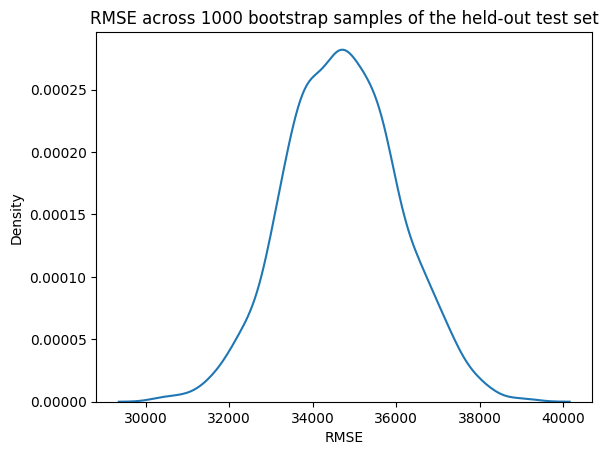

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("RMSE across 1000 bootstrap samples of the held-out test set")
plt.xlabel("RMSE")
plt.show()

Заметно, что catboost из коробки дает результат практически равный полученному в статье(больше на 0.013), чем в статье.  
При этом хуже всего показал себя RandomForestRegressor - результат более чем вдвое хуже получененого в статье(0.85 против 0.43).  
Попробуем улучшить результат результат в следующем разделе. При этом все результаты статистически отличаются от полученного в статье

### Модели после GridsearchCV

Проведем обучение с использованием уже написанных функций.

In [ ]:
df2, best_params = project_train(x_train, x_test, y_train, y_test)


Выходные данные были обрезаны до нескольких последних строк (5000).
103:	learn: 22338.5555178	total: 5.25s	remaining: 9.9s
104:	learn: 22268.4688654	total: 5.31s	remaining: 9.86s
105:	learn: 22192.6284289	total: 5.35s	remaining: 9.8s
106:	learn: 22119.9763648	total: 5.4s	remaining: 9.74s
107:	learn: 22063.2279390	total: 5.46s	remaining: 9.7s
108:	learn: 22011.9638359	total: 5.5s	remaining: 9.64s
109:	learn: 21955.9905086	total: 5.55s	remaining: 9.59s
110:	learn: 21863.5559831	total: 5.6s	remaining: 9.54s
111:	learn: 21792.1231913	total: 5.65s	remaining: 9.48s
112:	learn: 21726.2866666	total: 5.71s	remaining: 9.45s
113:	learn: 21654.3751848	total: 5.77s	remaining: 9.41s
114:	learn: 21579.3186149	total: 5.82s	remaining: 9.36s
115:	learn: 21530.5322116	total: 5.87s	remaining: 9.3s
116:	learn: 21456.5716708	total: 5.92s	remaining: 9.26s
117:	learn: 21387.8468297	total: 5.97s	remaining: 9.21s
118:	learn: 21304.3970932	total: 6.01s	remaining: 9.15s
119:	learn: 21214.1848353	total: 6.07s	rema

Результат выводится в виде датафрейма для простоты работы с ним.

In [ ]:
df2

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       14836.140282      31129.409058
1           XGBRegressor       13394.768713      31295.837142
2  RandomForestRegressor       11667.588478      32688.358778
3            KernelRidge       67539.772100      67855.386185

Отдельно обучим LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train, y=y_train)
#booster = lgb.train({"objective": "regression"},
#                    train_set=train_dataset, valid_sets=(test_dataset,),
#                    num_boost_round=20)
df2.loc[ len(df2.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Проверим получилось ли статистически значимо улучшить результат по сравнению по сравненимю с обучением на моделях из коробки.

In [ ]:
best_params.append(booster)
#best_params = best_params[0:5]
p_values = []
for i, model in enumerate(best_params):
    rsme = np.array(boostraping(model, x_test, y_test))
    print(rsme.mean())
    p_value = one_sample_t_test(rsme, df['test_score[RMSE]'][i], tail="two")
    p_values.append(p_value)
df2['p_value'] = p_values
df2

30790.76941928833
P-value: 0.0272355312367172
Reject the null hypothesis. There is a statistically significant difference.
31194.29311478009
P-value: 1.6035128892132884e-06
Reject the null hypothesis. There is a statistically significant difference.
32891.33763739749
P-value: 1.5877212418246846e-18
Reject the null hypothesis. There is a statistically significant difference.
68157.20442374973
P-value: 0.20989293448684043
Fail to reject the null hypothesis. There is no statistically significant difference.
31350.811568885645
P-value: 3.710695788269931e-10
Reject the null hypothesis. There is a statistically significant difference.


model name  train score[RMSE]  test_score[RMSE]       p_value
0      CatBoostRegressor       14836.140282      31129.409058  2.723553e-02
1           XGBRegressor       13394.768713      31295.837142  1.603513e-06
2  RandomForestRegressor       11667.588478      32688.358778  1.587721e-18
3            KernelRidge       67539.772100      67855.386185  2.098929e-01
4                   LGBM       12359.743961      31275.866486  3.710696e-10

Заметно, что удалось статистически значимо улучшить результаты для CatBoostRegressor, XGBRegressor, RandomForestRegressor и LGBM.

### Числовые эмбединги PLE-Q

Переведем данные с использованием эмбединга.

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
bins = compute_bins(torch.from_numpy(x_train))
x_train_emb = ple(bins, x_train)
x_test_emb = ple(bins, x_test)


In [ ]:
df4, models_simple_ple_q = project_train_simple(x_train, x_test, y_train, y_test)
train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_test, y_test)

booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=20)
df4.loc[ len(df4.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Training CatBoostRegressor
Learning rate set to 0.064113
0:	learn: 51403.0959519	total: 8.41ms	remaining: 8.4s
1:	learn: 50240.0618707	total: 15.2ms	remaining: 7.59s
2:	learn: 49215.0408164	total: 22.4ms	remaining: 7.43s
3:	learn: 48235.8784230	total: 29ms	remaining: 7.23s
4:	learn: 47334.1346954	total: 35.5ms	remaining: 7.06s
5:	learn: 46465.7472004	total: 42.3ms	remaining: 7.01s
6:	learn: 45618.7104190	total: 49.6ms	remaining: 7.04s
7:	learn: 44901.8430243	total: 56.5ms	remaining: 7.01s
8:	learn: 44247.7335876	total: 63.9ms	remaining: 7.03s
9:	learn: 43631.4834933	total: 70.8ms	remaining: 7.01s
10:	learn: 43072.5367037	total: 77.7ms	remaining: 6.98s
11:	learn: 42565.4135476	total: 87.2ms	remaining: 7.18s
12:	learn: 42080.7129546	total: 103ms	remaining: 7.83s
13:	learn: 41623.8050038	total: 115ms	remaining: 8.07s
14:	learn: 41149.4751651	total: 121ms	remaining: 7.97s
15:	learn: 40763.1883045	total: 128ms	remaining: 7.88s
16:	learn: 40332.0361392	total: 135ms	remaining: 7.81s
17:	learn

In [ ]:
df4

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       17937.917599      30314.192564
1           XGBRegressor       12800.424776      32830.506508
2  RandomForestRegressor       44546.413105      45337.656218
3            KernelRidge       67539.750082      67855.086878
4                   LGBM       30058.524907      34787.542909

Обучим модели

In [ ]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train, y=y_train)
#booster = lgb.train({"objective": "regression"},
#                    train_set=train_dataset, valid_sets=(test_dataset,),
#                    num_boost_round=20)
df3.loc[ len(df3.index )] = ['LGBM',
                           (mean_squared_error(y_train, booster.predict(x_train), squared = False)),
                           mean_squared_error(y_test, booster.predict(x_test), squared = False)]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
df3

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       15579.808957      30831.691230
1           XGBRegressor       12342.424926      31551.277646
2  RandomForestRegressor       11667.709449      32676.443411
3            KernelRidge       36120.876188      37939.334798
4                   LGBM       12359.743961      31275.866486

Проверим статистическую значимость различия использования эмбедингов на классическом ML

In [12]:
def onetail(grid_models, emb_models, x_test, x_test_emb, y_test, alpha = 0.05):
    for i in range(len(grid_models)):
        rsme_grid = np.array(boostraping(grid_models[i], x_test, y_test))
        rsme_emb = np.array(boostraping(emb_models[i], x_test_emb, y_test))
        res = stats.levene(rsme_grid, rsme_emb)
        if (res.pvalue > alpha):
          t_test = stats.ttest_ind(rsme_grid, rsme_emb)
        else:
          t_test = stats.ttest_ind(rsme_grid, rsme_emb, equal_var = False)
        p_value = t_test.pvalue
        # Step 5: Interpret the p-value
        print("P-value:", p_value)

        if (p_value*0.5 < alpha) and (t_test.statistic>0):
          print(
            "Reject the null hypothesis. There is a significant stat improvement for the model "
            +str(grid_models[i].__class__.__name__)+'.')
        else:
          print("Fail to reject the null hypothesis. There is no statistically significant difference for model "
          +str(grid_models[i].__class__.__name__)+'.')

In [ ]:
best_params = best_params[0:4]
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 0.22298382586050663
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.1194497831156092
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.20992167038554713
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 1.0501311301562982e-42
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


Теперь проверим на LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X= x_train_emb, y=y_train)

NameError: name 'x_train_emb' is not defined

In [ ]:
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

LGBM 14772.29997619926 31238.185008039945


In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster_simple = gsearch.fit(X=x_train, y=y_train)


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 0.17126932748337217
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


### Числовые эмбединги PLE-T

In [ ]:
bins = compute_bins(
    torch.from_numpy(x_train),
    tree_kwargs={'min_samples_leaf': 64, 'min_impurity_decrease': 1e-4},
    y=torch.from_numpy(y_train),
    regression=True,
)
x_train_emb = ple(bins, x_train)
x_test_emb = ple(bins, x_test)

Обучение всех моделей кроме LGBM

In [ ]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
103:	learn: 21912.2235687	total: 1m 47s	remaining: 3m 21s
104:	learn: 21814.5426684	total: 1m 48s	remaining: 3m 20s
105:	learn: 21752.7605832	total: 1m 48s	remaining: 3m 19s
106:	learn: 21675.4085224	total: 1m 49s	remaining: 3m 18s
107:	learn: 21599.9667369	total: 1m 51s	remaining: 3m 18s
108:	learn: 21554.7201637	total: 1m 52s	remaining: 3m 17s
109:	learn: 21481.9460287	total: 1m 53s	remaining: 3m 16s
110:	learn: 21441.4430007	total: 1m 54s	remaining: 3m 15s
111:	learn: 21390.2537520	total: 1m 55s	remaining: 3m 14s
112:	learn: 21332.0601285	total: 1m 56s	remaining: 3m 13s
113:	learn: 21251.1308082	total: 1m 57s	remaining: 3m 11s
114:	learn: 21201.9570620	total: 1m 58s	remaining: 3m 10s
115:	learn: 21106.4588695	total: 1m 59s	remaining: 3m 9s
116:	learn: 21013.4195583	total: 2m	remaining: 3m 8s
117:	learn: 20964.9069900	total: 2m 1s	remaining: 3m 7s
118:	learn: 20927.0385992	total: 2m 2s	remaining: 3m 6s
119:	learn: 20

In [ ]:
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 0.937984897541294
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.1883872676559872
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 0.7438387737820124
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 3.1694006625744245e-42
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


Теперь необходимо пороверить улучшил ли этот эмбединг LGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train_emb, y=y_train)
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 0.7292770222096108
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


#### Выводы

Получены значения близкие к значениям из статьи. При этом эмбединги помогли улучшить значения только для kernel linear regression. Статзначимость проверялась с помощью однохвостового t-теста, с границей p-value = 0.05.

In [6]:
from torch.nn.parameter import Parameter

def periodic_embedding(X, n_features):
  x = torch.from_numpy(X)
  k = 48
  sigma = 0.01
  weight = Parameter(torch.empty(n_features, k))
  x = 2 * math.pi * weight * x[..., None]
  x = torch.cat([torch.cos(x), torch.sin(x)], -1)
  x = x.detach().numpy()
  x_f = x[:, 0, :]
  for i in range(x.shape[1]-1):
    x_f = np.concatenate([x_f, x[:, i+1, :]], axis = 1)

  return x_f

In [7]:
x_train.shape[1]

16

In [8]:
x = periodic_embedding(x_train, x_train.shape[1])

In [ ]:
x.shape

In [9]:
x_train.shape

(17088, 16)

## Periodic

In [10]:
x_train_emb = periodic_embedding(x_train, x_train.shape[1])
x_test_emb = periodic_embedding(x_test, x_test.shape[1])

In [15]:
df3, best_params_ple_q = project_train(x_train_emb, x_test_emb, y_train, y_test)

Training CatBoostRegressor
0:	learn: 52058.2335135	total: 581ms	remaining: 2m 53s
1:	learn: 51662.5982199	total: 585ms	remaining: 1m 27s
2:	learn: 51311.8442352	total: 591ms	remaining: 58.5s
3:	learn: 51000.8483009	total: 595ms	remaining: 44s
4:	learn: 50746.5994699	total: 599ms	remaining: 35.3s
5:	learn: 50506.3488734	total: 602ms	remaining: 29.5s
6:	learn: 50297.2721108	total: 605ms	remaining: 25.3s
7:	learn: 50103.3624646	total: 608ms	remaining: 22.2s
8:	learn: 49921.0664420	total: 611ms	remaining: 19.8s
9:	learn: 49765.0634818	total: 614ms	remaining: 17.8s
10:	learn: 49628.9624591	total: 618ms	remaining: 16.2s
11:	learn: 49509.1776050	total: 623ms	remaining: 15s
12:	learn: 49391.8148625	total: 626ms	remaining: 13.8s
13:	learn: 49286.7161767	total: 631ms	remaining: 12.9s
14:	learn: 49190.0263317	total: 635ms	remaining: 12.1s
15:	learn: 49110.5492834	total: 638ms	remaining: 11.3s
16:	learn: 49032.2702361	total: 641ms	remaining: 10.7s
17:	learn: 48963.4780385	total: 645ms	remaining: 1

152:	learn: 48071.2750258	total: 1.2s	remaining: 1.15s
153:	learn: 48070.3717026	total: 1.2s	remaining: 1.14s
154:	learn: 48067.0091816	total: 1.21s	remaining: 1.13s
155:	learn: 48064.7551007	total: 1.21s	remaining: 1.12s
156:	learn: 48063.1989122	total: 1.22s	remaining: 1.11s
157:	learn: 48060.2025256	total: 1.22s	remaining: 1.1s
158:	learn: 48057.5849429	total: 1.23s	remaining: 1.09s
159:	learn: 48050.0441474	total: 1.23s	remaining: 1.08s
160:	learn: 48047.5734639	total: 1.24s	remaining: 1.07s
161:	learn: 48045.2585982	total: 1.24s	remaining: 1.05s
162:	learn: 48044.1752099	total: 1.24s	remaining: 1.04s
163:	learn: 48042.1126366	total: 1.25s	remaining: 1.03s
164:	learn: 48040.7594337	total: 1.25s	remaining: 1.02s
165:	learn: 48037.6070392	total: 1.25s	remaining: 1.01s
166:	learn: 48035.0795009	total: 1.26s	remaining: 1s
167:	learn: 48033.2914420	total: 1.26s	remaining: 993ms
168:	learn: 48029.9466417	total: 1.27s	remaining: 983ms
169:	learn: 48027.1041097	total: 1.27s	remaining: 973m

0:	learn: 52872.2815175	total: 4.08ms	remaining: 1.22s
1:	learn: 52478.7446615	total: 7.75ms	remaining: 1.15s
2:	learn: 52121.6377351	total: 11.4ms	remaining: 1.13s
3:	learn: 51802.3973220	total: 14.8ms	remaining: 1.1s
4:	learn: 51538.5944054	total: 18.5ms	remaining: 1.09s
5:	learn: 51308.6504689	total: 22.6ms	remaining: 1.11s
6:	learn: 51090.8007482	total: 26.2ms	remaining: 1.1s
7:	learn: 50890.0843791	total: 30.6ms	remaining: 1.12s
8:	learn: 50702.7124909	total: 34.3ms	remaining: 1.11s
9:	learn: 50542.9755539	total: 38.4ms	remaining: 1.11s
10:	learn: 50400.1861167	total: 42ms	remaining: 1.1s
11:	learn: 50273.5405076	total: 45ms	remaining: 1.08s
12:	learn: 50147.6433381	total: 48.5ms	remaining: 1.07s
13:	learn: 50035.4207416	total: 52.2ms	remaining: 1.07s
14:	learn: 49935.3530701	total: 55.3ms	remaining: 1.05s
15:	learn: 49855.5380396	total: 58.8ms	remaining: 1.04s
16:	learn: 49779.2035413	total: 62.4ms	remaining: 1.04s
17:	learn: 49708.0673342	total: 66.5ms	remaining: 1.04s
18:	learn

152:	learn: 48734.3713387	total: 589ms	remaining: 566ms
153:	learn: 48729.8074046	total: 593ms	remaining: 562ms
154:	learn: 48725.8690364	total: 598ms	remaining: 560ms
155:	learn: 48722.4090408	total: 602ms	remaining: 556ms
156:	learn: 48719.0654407	total: 606ms	remaining: 552ms
157:	learn: 48716.7530522	total: 609ms	remaining: 548ms
158:	learn: 48715.8131052	total: 613ms	remaining: 544ms
159:	learn: 48712.7361159	total: 617ms	remaining: 540ms
160:	learn: 48704.8156273	total: 620ms	remaining: 536ms
161:	learn: 48701.6603179	total: 624ms	remaining: 532ms
162:	learn: 48700.1050635	total: 627ms	remaining: 527ms
163:	learn: 48695.3142962	total: 631ms	remaining: 524ms
164:	learn: 48689.9202983	total: 636ms	remaining: 520ms
165:	learn: 48688.0220848	total: 639ms	remaining: 516ms
166:	learn: 48685.4895558	total: 642ms	remaining: 512ms
167:	learn: 48682.4018132	total: 646ms	remaining: 508ms
168:	learn: 48678.8587764	total: 651ms	remaining: 504ms
169:	learn: 48674.8952009	total: 655ms	remaining

0:	learn: 51591.8043306	total: 3.37ms	remaining: 1.01s
1:	learn: 51178.9442403	total: 6.91ms	remaining: 1.03s
2:	learn: 50815.9790484	total: 10.4ms	remaining: 1.03s
3:	learn: 50498.3395991	total: 13.4ms	remaining: 990ms
4:	learn: 50221.2697111	total: 16.9ms	remaining: 999ms
5:	learn: 49970.6014025	total: 20.3ms	remaining: 992ms
6:	learn: 49757.6169709	total: 23.5ms	remaining: 983ms
7:	learn: 49553.1365723	total: 27.2ms	remaining: 992ms
8:	learn: 49360.1357782	total: 30.4ms	remaining: 984ms
9:	learn: 49193.8936856	total: 33.7ms	remaining: 977ms
10:	learn: 49038.1839110	total: 36.9ms	remaining: 970ms
11:	learn: 48915.6533028	total: 40.5ms	remaining: 972ms
12:	learn: 48791.2010686	total: 43.7ms	remaining: 966ms
13:	learn: 48679.1091553	total: 47.4ms	remaining: 969ms
14:	learn: 48587.4136962	total: 50.4ms	remaining: 958ms
15:	learn: 48506.6933572	total: 53.4ms	remaining: 947ms
16:	learn: 48431.3339217	total: 56.3ms	remaining: 937ms
17:	learn: 48357.6737313	total: 59.4ms	remaining: 931ms
18

179:	learn: 47341.9222013	total: 590ms	remaining: 394ms
180:	learn: 47338.9048946	total: 593ms	remaining: 390ms
181:	learn: 47336.0007702	total: 597ms	remaining: 387ms
182:	learn: 47330.0281118	total: 600ms	remaining: 383ms
183:	learn: 47322.5428049	total: 604ms	remaining: 381ms
184:	learn: 47320.0769534	total: 607ms	remaining: 377ms
185:	learn: 47316.7826182	total: 610ms	remaining: 374ms
186:	learn: 47312.0363419	total: 613ms	remaining: 371ms
187:	learn: 47307.2994871	total: 616ms	remaining: 367ms
188:	learn: 47305.2116270	total: 619ms	remaining: 364ms
189:	learn: 47303.3339254	total: 623ms	remaining: 361ms
190:	learn: 47299.6129213	total: 627ms	remaining: 358ms
191:	learn: 47295.6868872	total: 630ms	remaining: 354ms
192:	learn: 47289.5089567	total: 633ms	remaining: 351ms
193:	learn: 47280.0465679	total: 637ms	remaining: 348ms
194:	learn: 47275.6660302	total: 640ms	remaining: 344ms
195:	learn: 47271.4008168	total: 642ms	remaining: 341ms
196:	learn: 47269.2415308	total: 645ms	remaining

58:	learn: 47814.9135932	total: 202ms	remaining: 825ms
59:	learn: 47810.8377318	total: 205ms	remaining: 820ms
60:	learn: 47804.0828252	total: 208ms	remaining: 814ms
61:	learn: 47802.8260942	total: 211ms	remaining: 811ms
62:	learn: 47799.7178879	total: 215ms	remaining: 809ms
63:	learn: 47794.4017791	total: 218ms	remaining: 805ms
64:	learn: 47791.5352449	total: 222ms	remaining: 801ms
65:	learn: 47789.4160091	total: 225ms	remaining: 796ms
66:	learn: 47788.1606700	total: 228ms	remaining: 793ms
67:	learn: 47784.5043757	total: 232ms	remaining: 791ms
68:	learn: 47781.9258322	total: 235ms	remaining: 786ms
69:	learn: 47778.8289717	total: 238ms	remaining: 781ms
70:	learn: 47776.3644751	total: 241ms	remaining: 777ms
71:	learn: 47773.6515075	total: 244ms	remaining: 772ms
72:	learn: 47766.7447113	total: 247ms	remaining: 767ms
73:	learn: 47760.7381354	total: 250ms	remaining: 764ms
74:	learn: 47758.4133555	total: 253ms	remaining: 760ms
75:	learn: 47757.0761921	total: 257ms	remaining: 758ms
76:	learn:

238:	learn: 47147.4130646	total: 805ms	remaining: 205ms
239:	learn: 47137.5025546	total: 809ms	remaining: 202ms
240:	learn: 47131.6475610	total: 812ms	remaining: 199ms
241:	learn: 47127.3750530	total: 816ms	remaining: 196ms
242:	learn: 47119.5529261	total: 820ms	remaining: 192ms
243:	learn: 47115.9976771	total: 824ms	remaining: 189ms
244:	learn: 47114.3655356	total: 827ms	remaining: 186ms
245:	learn: 47108.4568383	total: 830ms	remaining: 182ms
246:	learn: 47104.9325951	total: 833ms	remaining: 179ms
247:	learn: 47102.8121887	total: 837ms	remaining: 175ms
248:	learn: 47096.7200476	total: 841ms	remaining: 172ms
249:	learn: 47094.3435092	total: 844ms	remaining: 169ms
250:	learn: 47089.6224010	total: 847ms	remaining: 165ms
251:	learn: 47084.6089020	total: 851ms	remaining: 162ms
252:	learn: 47074.7471833	total: 855ms	remaining: 159ms
253:	learn: 47072.3569059	total: 859ms	remaining: 156ms
254:	learn: 47068.2459419	total: 863ms	remaining: 152ms
255:	learn: 47065.1997975	total: 866ms	remaining

116:	learn: 48809.3467817	total: 396ms	remaining: 620ms
117:	learn: 48805.6586497	total: 399ms	remaining: 616ms
118:	learn: 48804.4853519	total: 402ms	remaining: 612ms
119:	learn: 48803.2685367	total: 405ms	remaining: 608ms
120:	learn: 48797.7310027	total: 409ms	remaining: 605ms
121:	learn: 48794.6654138	total: 413ms	remaining: 603ms
122:	learn: 48788.3015673	total: 416ms	remaining: 599ms
123:	learn: 48787.3755472	total: 420ms	remaining: 596ms
124:	learn: 48785.7386668	total: 423ms	remaining: 592ms
125:	learn: 48784.7553235	total: 426ms	remaining: 588ms
126:	learn: 48782.4227400	total: 429ms	remaining: 584ms
127:	learn: 48779.2463510	total: 432ms	remaining: 580ms
128:	learn: 48776.1214029	total: 435ms	remaining: 577ms
129:	learn: 48773.4429110	total: 439ms	remaining: 574ms
130:	learn: 48770.8401954	total: 443ms	remaining: 571ms
131:	learn: 48770.1831797	total: 445ms	remaining: 567ms
132:	learn: 48768.7391373	total: 449ms	remaining: 564ms
133:	learn: 48765.4217402	total: 452ms	remaining

0:	learn: 52058.8813432	total: 5.97ms	remaining: 1.78s
1:	learn: 51663.5470144	total: 9.13ms	remaining: 1.36s
2:	learn: 51313.0985651	total: 12.6ms	remaining: 1.25s
3:	learn: 51002.1799327	total: 16.3ms	remaining: 1.21s
4:	learn: 50748.3343432	total: 19.9ms	remaining: 1.18s
5:	learn: 50508.1974381	total: 23.3ms	remaining: 1.14s
6:	learn: 50299.1880213	total: 26.9ms	remaining: 1.13s
7:	learn: 50105.4334849	total: 30.6ms	remaining: 1.11s
8:	learn: 49923.0210144	total: 34.6ms	remaining: 1.12s
9:	learn: 49766.9878987	total: 38.4ms	remaining: 1.11s
10:	learn: 49630.8678565	total: 42.3ms	remaining: 1.11s
11:	learn: 49511.0901224	total: 45.1ms	remaining: 1.08s
12:	learn: 49393.6759103	total: 47.7ms	remaining: 1.05s
13:	learn: 49288.6824479	total: 50.1ms	remaining: 1.02s
14:	learn: 49191.9934467	total: 52.7ms	remaining: 1s
15:	learn: 49113.5027852	total: 56.2ms	remaining: 997ms
16:	learn: 49035.1396513	total: 59.3ms	remaining: 987ms
17:	learn: 48966.4408959	total: 62.4ms	remaining: 978ms
18:	l

220:	learn: 47892.9528096	total: 596ms	remaining: 213ms
221:	learn: 47891.8547809	total: 599ms	remaining: 210ms
222:	learn: 47890.8731062	total: 601ms	remaining: 208ms
223:	learn: 47889.8756448	total: 603ms	remaining: 205ms
224:	learn: 47887.3436623	total: 606ms	remaining: 202ms
225:	learn: 47883.8880735	total: 608ms	remaining: 199ms
226:	learn: 47881.7960960	total: 610ms	remaining: 196ms
227:	learn: 47879.7561778	total: 613ms	remaining: 194ms
228:	learn: 47874.8090020	total: 615ms	remaining: 191ms
229:	learn: 47872.9976419	total: 618ms	remaining: 188ms
230:	learn: 47869.5089714	total: 620ms	remaining: 185ms
231:	learn: 47867.3078213	total: 623ms	remaining: 183ms
232:	learn: 47864.5723864	total: 625ms	remaining: 180ms
233:	learn: 47861.4830164	total: 628ms	remaining: 177ms
234:	learn: 47859.2094508	total: 630ms	remaining: 174ms
235:	learn: 47856.3599783	total: 633ms	remaining: 172ms
236:	learn: 47854.3093571	total: 635ms	remaining: 169ms
237:	learn: 47850.8309150	total: 637ms	remaining

111:	learn: 48884.2788733	total: 385ms	remaining: 646ms
112:	learn: 48883.0635306	total: 388ms	remaining: 642ms
113:	learn: 48881.2369187	total: 391ms	remaining: 638ms
114:	learn: 48876.5422508	total: 395ms	remaining: 635ms
115:	learn: 48873.6991926	total: 398ms	remaining: 631ms
116:	learn: 48868.1397280	total: 401ms	remaining: 628ms
117:	learn: 48865.9466160	total: 404ms	remaining: 624ms
118:	learn: 48864.8776444	total: 408ms	remaining: 620ms
119:	learn: 48863.6603684	total: 411ms	remaining: 616ms
120:	learn: 48859.5597906	total: 414ms	remaining: 613ms
121:	learn: 48858.6404833	total: 417ms	remaining: 609ms
122:	learn: 48855.0803063	total: 421ms	remaining: 605ms
123:	learn: 48852.5477431	total: 424ms	remaining: 602ms
124:	learn: 48851.9163910	total: 428ms	remaining: 599ms
125:	learn: 48848.4810178	total: 431ms	remaining: 596ms
126:	learn: 48843.6510705	total: 435ms	remaining: 593ms
127:	learn: 48842.8101771	total: 438ms	remaining: 588ms
128:	learn: 48842.0680660	total: 441ms	remaining

299:	learn: 48294.1983938	total: 988ms	remaining: 0us
0:	learn: 51592.6425172	total: 2.94ms	remaining: 880ms
1:	learn: 51180.0654788	total: 6.84ms	remaining: 1.02s
2:	learn: 50817.4508264	total: 10.3ms	remaining: 1.02s
3:	learn: 50500.0178150	total: 12.9ms	remaining: 953ms
4:	learn: 50223.1414724	total: 15.8ms	remaining: 932ms
5:	learn: 49972.5851032	total: 18.3ms	remaining: 899ms
6:	learn: 49759.6490309	total: 21.3ms	remaining: 891ms
7:	learn: 49555.3391915	total: 24ms	remaining: 875ms
8:	learn: 49362.2727551	total: 26.6ms	remaining: 860ms
9:	learn: 49195.9918312	total: 29ms	remaining: 842ms
10:	learn: 49040.2631385	total: 32.2ms	remaining: 846ms
11:	learn: 48917.7310800	total: 34.8ms	remaining: 835ms
12:	learn: 48793.2632747	total: 37.7ms	remaining: 833ms
13:	learn: 48681.1515792	total: 40.9ms	remaining: 836ms
14:	learn: 48589.3817677	total: 44ms	remaining: 835ms
15:	learn: 48508.6105025	total: 46.9ms	remaining: 832ms
16:	learn: 48433.1876930	total: 50.1ms	remaining: 833ms
17:	learn:

190:	learn: 47326.2177899	total: 608ms	remaining: 347ms
191:	learn: 47323.8876747	total: 612ms	remaining: 344ms
192:	learn: 47318.6319024	total: 615ms	remaining: 341ms
193:	learn: 47314.2871447	total: 618ms	remaining: 338ms
194:	learn: 47311.7890661	total: 621ms	remaining: 334ms
195:	learn: 47308.1212025	total: 624ms	remaining: 331ms
196:	learn: 47305.4192583	total: 627ms	remaining: 328ms
197:	learn: 47302.9097935	total: 630ms	remaining: 325ms
198:	learn: 47300.6446218	total: 634ms	remaining: 322ms
199:	learn: 47298.5082257	total: 637ms	remaining: 318ms
200:	learn: 47294.0826517	total: 640ms	remaining: 315ms
201:	learn: 47292.1391850	total: 643ms	remaining: 312ms
202:	learn: 47290.5685905	total: 646ms	remaining: 309ms
203:	learn: 47283.9093037	total: 650ms	remaining: 306ms
204:	learn: 47280.5049611	total: 654ms	remaining: 303ms
205:	learn: 47278.3353584	total: 658ms	remaining: 300ms
206:	learn: 47276.7487056	total: 660ms	remaining: 297ms
207:	learn: 47273.0335381	total: 663ms	remaining

63:	learn: 47802.1729103	total: 203ms	remaining: 749ms
64:	learn: 47800.1747687	total: 207ms	remaining: 747ms
65:	learn: 47798.0612332	total: 210ms	remaining: 743ms
66:	learn: 47796.7971812	total: 213ms	remaining: 739ms
67:	learn: 47793.0918356	total: 216ms	remaining: 735ms
68:	learn: 47790.4070732	total: 219ms	remaining: 732ms
69:	learn: 47787.4356059	total: 222ms	remaining: 729ms
70:	learn: 47785.0384512	total: 225ms	remaining: 726ms
71:	learn: 47778.0308953	total: 228ms	remaining: 722ms
72:	learn: 47772.0264587	total: 231ms	remaining: 719ms
73:	learn: 47768.8402216	total: 234ms	remaining: 715ms
74:	learn: 47766.4478052	total: 237ms	remaining: 710ms
75:	learn: 47765.1167050	total: 239ms	remaining: 706ms
76:	learn: 47762.7469825	total: 242ms	remaining: 702ms
77:	learn: 47760.4435688	total: 246ms	remaining: 699ms
78:	learn: 47758.4243217	total: 248ms	remaining: 695ms
79:	learn: 47757.1456736	total: 251ms	remaining: 692ms
80:	learn: 47755.0869981	total: 255ms	remaining: 689ms
81:	learn:

259:	learn: 47159.3498443	total: 803ms	remaining: 123ms
260:	learn: 47153.2319829	total: 806ms	remaining: 120ms
261:	learn: 47148.3899139	total: 809ms	remaining: 117ms
262:	learn: 47145.9819134	total: 812ms	remaining: 114ms
263:	learn: 47141.5689514	total: 815ms	remaining: 111ms
264:	learn: 47138.4775117	total: 819ms	remaining: 108ms
265:	learn: 47133.9897207	total: 823ms	remaining: 105ms
266:	learn: 47131.0397262	total: 826ms	remaining: 102ms
267:	learn: 47127.9833437	total: 830ms	remaining: 99.1ms
268:	learn: 47122.3690385	total: 833ms	remaining: 96ms
269:	learn: 47118.6376178	total: 836ms	remaining: 92.8ms
270:	learn: 47113.5211565	total: 839ms	remaining: 89.7ms
271:	learn: 47107.3379324	total: 841ms	remaining: 86.6ms
272:	learn: 47105.9074357	total: 844ms	remaining: 83.5ms
273:	learn: 47103.9499613	total: 847ms	remaining: 80.4ms
274:	learn: 47098.3732532	total: 851ms	remaining: 77.3ms
275:	learn: 47096.9779845	total: 855ms	remaining: 74.3ms
276:	learn: 47094.7507303	total: 858ms	re

112:	learn: 48829.7101252	total: 390ms	remaining: 646ms
113:	learn: 48827.3166577	total: 393ms	remaining: 642ms
114:	learn: 48825.2837602	total: 397ms	remaining: 638ms
115:	learn: 48823.1047166	total: 400ms	remaining: 635ms
116:	learn: 48820.4176562	total: 403ms	remaining: 631ms
117:	learn: 48817.1546644	total: 407ms	remaining: 627ms
118:	learn: 48816.0001983	total: 410ms	remaining: 623ms
119:	learn: 48814.7663831	total: 413ms	remaining: 619ms
120:	learn: 48811.1132681	total: 416ms	remaining: 615ms
121:	learn: 48808.7675500	total: 419ms	remaining: 611ms
122:	learn: 48803.7238471	total: 422ms	remaining: 607ms
123:	learn: 48802.8751319	total: 425ms	remaining: 604ms
124:	learn: 48801.2519500	total: 429ms	remaining: 600ms
125:	learn: 48800.3485053	total: 432ms	remaining: 596ms
126:	learn: 48798.0725562	total: 435ms	remaining: 592ms
127:	learn: 48794.8511985	total: 439ms	remaining: 590ms
128:	learn: 48791.8567570	total: 442ms	remaining: 586ms
129:	learn: 48789.7485447	total: 445ms	remaining

294:	learn: 48257.0403138	total: 988ms	remaining: 16.7ms
295:	learn: 48254.9580827	total: 992ms	remaining: 13.4ms
296:	learn: 48250.0735027	total: 995ms	remaining: 10.1ms
297:	learn: 48248.1251491	total: 998ms	remaining: 6.7ms
298:	learn: 48244.2589205	total: 1s	remaining: 3.35ms
299:	learn: 48243.2385514	total: 1.01s	remaining: 0us
0:	learn: 52059.5264927	total: 3.43ms	remaining: 1.02s
1:	learn: 51664.4926528	total: 6.75ms	remaining: 1.01s
2:	learn: 51314.3481969	total: 9.93ms	remaining: 983ms
3:	learn: 51003.5071963	total: 13ms	remaining: 962ms
4:	learn: 50750.0592472	total: 16.7ms	remaining: 986ms
5:	learn: 50510.0356165	total: 19.6ms	remaining: 962ms
6:	learn: 50301.0938128	total: 22.4ms	remaining: 937ms
7:	learn: 50107.4945730	total: 26.6ms	remaining: 972ms
8:	learn: 49924.9665063	total: 29.3ms	remaining: 948ms
9:	learn: 49768.9040938	total: 32.3ms	remaining: 937ms
10:	learn: 49632.7655669	total: 35.1ms	remaining: 923ms
11:	learn: 49512.9955304	total: 37.7ms	remaining: 905ms
12:	l

193:	learn: 48022.0188954	total: 601ms	remaining: 329ms
194:	learn: 48018.0418090	total: 605ms	remaining: 326ms
195:	learn: 48015.7211838	total: 608ms	remaining: 323ms
196:	learn: 48013.0714004	total: 612ms	remaining: 320ms
197:	learn: 48011.0548588	total: 615ms	remaining: 317ms
198:	learn: 48008.6015163	total: 618ms	remaining: 314ms
199:	learn: 48005.1256076	total: 622ms	remaining: 311ms
200:	learn: 47998.3310866	total: 625ms	remaining: 308ms
201:	learn: 47995.8456103	total: 628ms	remaining: 305ms
202:	learn: 47992.5193580	total: 631ms	remaining: 301ms
203:	learn: 47989.8658870	total: 634ms	remaining: 298ms
204:	learn: 47984.0509463	total: 639ms	remaining: 296ms
205:	learn: 47982.3260896	total: 641ms	remaining: 293ms
206:	learn: 47980.7017724	total: 644ms	remaining: 289ms
207:	learn: 47976.4528033	total: 647ms	remaining: 286ms
208:	learn: 47973.9257719	total: 650ms	remaining: 283ms
209:	learn: 47971.4050000	total: 653ms	remaining: 280ms
210:	learn: 47968.4702300	total: 657ms	remaining

62:	learn: 49036.8503073	total: 201ms	remaining: 758ms
63:	learn: 49034.9065664	total: 205ms	remaining: 757ms
64:	learn: 49032.7944628	total: 209ms	remaining: 755ms
65:	learn: 49031.4561225	total: 212ms	remaining: 752ms
66:	learn: 49028.4901299	total: 215ms	remaining: 749ms
67:	learn: 49024.8668101	total: 219ms	remaining: 746ms
68:	learn: 49021.9605240	total: 221ms	remaining: 741ms
69:	learn: 49018.0467430	total: 225ms	remaining: 738ms
70:	learn: 49015.2862719	total: 228ms	remaining: 735ms
71:	learn: 49013.6172796	total: 232ms	remaining: 735ms
72:	learn: 49012.2367767	total: 236ms	remaining: 733ms
73:	learn: 49009.4758008	total: 239ms	remaining: 730ms
74:	learn: 49006.6556647	total: 242ms	remaining: 727ms
75:	learn: 49004.9046127	total: 246ms	remaining: 725ms
76:	learn: 49003.6084856	total: 249ms	remaining: 722ms
77:	learn: 48999.9974305	total: 253ms	remaining: 721ms
78:	learn: 48997.1899485	total: 257ms	remaining: 719ms
79:	learn: 48994.6668402	total: 260ms	remaining: 716ms
80:	learn:

233:	learn: 48555.1074814	total: 776ms	remaining: 219ms
234:	learn: 48553.0814847	total: 779ms	remaining: 215ms
235:	learn: 48549.2554150	total: 783ms	remaining: 212ms
236:	learn: 48546.0665827	total: 786ms	remaining: 209ms
237:	learn: 48544.0910962	total: 790ms	remaining: 206ms
238:	learn: 48542.3586641	total: 793ms	remaining: 202ms
239:	learn: 48539.1113353	total: 796ms	remaining: 199ms
240:	learn: 48535.7960738	total: 800ms	remaining: 196ms
241:	learn: 48531.5121780	total: 803ms	remaining: 192ms
242:	learn: 48529.5823927	total: 806ms	remaining: 189ms
243:	learn: 48525.4635819	total: 809ms	remaining: 186ms
244:	learn: 48520.1780575	total: 813ms	remaining: 183ms
245:	learn: 48513.3491283	total: 816ms	remaining: 179ms
246:	learn: 48511.4104580	total: 820ms	remaining: 176ms
247:	learn: 48509.4530171	total: 823ms	remaining: 172ms
248:	learn: 48507.5612263	total: 826ms	remaining: 169ms
249:	learn: 48505.7117131	total: 829ms	remaining: 166ms
250:	learn: 48503.9031372	total: 832ms	remaining

135:	learn: 47515.6388858	total: 393ms	remaining: 474ms
136:	learn: 47514.6480609	total: 396ms	remaining: 471ms
137:	learn: 47512.4989409	total: 399ms	remaining: 468ms
138:	learn: 47510.2828224	total: 402ms	remaining: 465ms
139:	learn: 47508.8446303	total: 405ms	remaining: 462ms
140:	learn: 47503.0146150	total: 408ms	remaining: 460ms
141:	learn: 47501.6035169	total: 411ms	remaining: 457ms
142:	learn: 47499.4920498	total: 413ms	remaining: 454ms
143:	learn: 47496.8373721	total: 416ms	remaining: 451ms
144:	learn: 47495.4030486	total: 420ms	remaining: 448ms
145:	learn: 47492.5163713	total: 423ms	remaining: 446ms
146:	learn: 47491.3701534	total: 425ms	remaining: 443ms
147:	learn: 47490.4693127	total: 428ms	remaining: 440ms
148:	learn: 47487.6733387	total: 431ms	remaining: 437ms
149:	learn: 47487.0175499	total: 434ms	remaining: 434ms
150:	learn: 47485.2440274	total: 437ms	remaining: 432ms
151:	learn: 47484.5980784	total: 440ms	remaining: 428ms
152:	learn: 47482.6444853	total: 443ms	remaining

0:	learn: 51762.8987650	total: 2.97ms	remaining: 887ms
1:	learn: 51352.6629599	total: 5.78ms	remaining: 861ms
2:	learn: 50982.3659494	total: 8.2ms	remaining: 812ms
3:	learn: 50664.2543280	total: 10.7ms	remaining: 789ms
4:	learn: 50396.5692308	total: 13.4ms	remaining: 789ms
5:	learn: 50162.5510710	total: 16ms	remaining: 784ms
6:	learn: 49947.2808456	total: 18.7ms	remaining: 783ms
7:	learn: 49740.1058294	total: 21.8ms	remaining: 794ms
8:	learn: 49557.4613138	total: 24.5ms	remaining: 792ms
9:	learn: 49386.8110268	total: 27.1ms	remaining: 787ms
10:	learn: 49226.1639066	total: 30.1ms	remaining: 791ms
11:	learn: 49086.2113945	total: 32.7ms	remaining: 786ms
12:	learn: 48958.8367978	total: 35.4ms	remaining: 782ms
13:	learn: 48851.1904743	total: 38ms	remaining: 777ms
14:	learn: 48750.9482190	total: 40.5ms	remaining: 769ms
15:	learn: 48669.9744436	total: 43.2ms	remaining: 767ms
16:	learn: 48594.1369274	total: 46ms	remaining: 765ms
17:	learn: 48516.1416146	total: 48.6ms	remaining: 761ms
18:	learn

214:	learn: 47386.2649906	total: 588ms	remaining: 232ms
215:	learn: 47382.3806048	total: 591ms	remaining: 230ms
216:	learn: 47380.9245374	total: 593ms	remaining: 227ms
217:	learn: 47376.1804637	total: 596ms	remaining: 224ms
218:	learn: 47372.9292766	total: 599ms	remaining: 221ms
219:	learn: 47369.3324942	total: 602ms	remaining: 219ms
220:	learn: 47367.1306205	total: 604ms	remaining: 216ms
221:	learn: 47364.0253686	total: 607ms	remaining: 213ms
222:	learn: 47362.0656192	total: 609ms	remaining: 210ms
223:	learn: 47359.3991818	total: 612ms	remaining: 208ms
224:	learn: 47356.9729374	total: 615ms	remaining: 205ms
225:	learn: 47353.0023087	total: 618ms	remaining: 202ms
226:	learn: 47349.1754892	total: 621ms	remaining: 200ms
227:	learn: 47345.5971953	total: 623ms	remaining: 197ms
228:	learn: 47341.2911484	total: 626ms	remaining: 194ms
229:	learn: 47339.9927500	total: 629ms	remaining: 191ms
230:	learn: 47336.6926110	total: 632ms	remaining: 189ms
231:	learn: 47334.2582927	total: 634ms	remaining

78:	learn: 48891.4552250	total: 195ms	remaining: 546ms
79:	learn: 48890.2835624	total: 198ms	remaining: 544ms
80:	learn: 48889.4725567	total: 200ms	remaining: 542ms
81:	learn: 48888.3061963	total: 203ms	remaining: 539ms
82:	learn: 48886.4960746	total: 205ms	remaining: 535ms
83:	learn: 48884.4918218	total: 207ms	remaining: 532ms
84:	learn: 48881.2741393	total: 209ms	remaining: 529ms
85:	learn: 48879.4768647	total: 211ms	remaining: 526ms
86:	learn: 48878.9905819	total: 213ms	remaining: 523ms
87:	learn: 48876.9411920	total: 216ms	remaining: 519ms
88:	learn: 48875.4664995	total: 217ms	remaining: 516ms
89:	learn: 48872.3675383	total: 219ms	remaining: 512ms
90:	learn: 48869.6325887	total: 221ms	remaining: 508ms
91:	learn: 48866.5991898	total: 223ms	remaining: 505ms
92:	learn: 48865.1828632	total: 225ms	remaining: 502ms
93:	learn: 48863.1496857	total: 227ms	remaining: 499ms
94:	learn: 48859.5331679	total: 230ms	remaining: 496ms
95:	learn: 48856.4308216	total: 233ms	remaining: 494ms
96:	learn:

251:	learn: 48425.4696571	total: 579ms	remaining: 110ms
252:	learn: 48420.0266718	total: 581ms	remaining: 108ms
253:	learn: 48415.0450625	total: 584ms	remaining: 106ms
254:	learn: 48413.5901972	total: 586ms	remaining: 103ms
255:	learn: 48410.8800987	total: 588ms	remaining: 101ms
256:	learn: 48407.8196122	total: 591ms	remaining: 98.9ms
257:	learn: 48404.6379503	total: 593ms	remaining: 96.5ms
258:	learn: 48403.2265415	total: 595ms	remaining: 94.2ms
259:	learn: 48397.1964263	total: 597ms	remaining: 91.9ms
260:	learn: 48394.5802624	total: 600ms	remaining: 89.6ms
261:	learn: 48391.5865718	total: 602ms	remaining: 87.3ms
262:	learn: 48387.0634628	total: 605ms	remaining: 85.1ms
263:	learn: 48385.0783004	total: 607ms	remaining: 82.8ms
264:	learn: 48382.3963389	total: 610ms	remaining: 80.5ms
265:	learn: 48380.2031102	total: 612ms	remaining: 78.3ms
266:	learn: 48377.3013361	total: 615ms	remaining: 76ms
267:	learn: 48373.2493269	total: 617ms	remaining: 73.7ms
268:	learn: 48371.6103293	total: 620ms

149:	learn: 48135.8233357	total: 394ms	remaining: 394ms
150:	learn: 48134.9369953	total: 397ms	remaining: 392ms
151:	learn: 48134.0180223	total: 400ms	remaining: 390ms
152:	learn: 48132.3771541	total: 405ms	remaining: 389ms
153:	learn: 48131.4869731	total: 408ms	remaining: 387ms
154:	learn: 48129.9063014	total: 413ms	remaining: 386ms
155:	learn: 48128.5389240	total: 417ms	remaining: 385ms
156:	learn: 48127.3743409	total: 420ms	remaining: 382ms
157:	learn: 48124.3934549	total: 422ms	remaining: 380ms
158:	learn: 48121.7683477	total: 425ms	remaining: 377ms
159:	learn: 48119.4445762	total: 428ms	remaining: 375ms
160:	learn: 48118.5021726	total: 431ms	remaining: 372ms
161:	learn: 48115.8545821	total: 435ms	remaining: 370ms
162:	learn: 48115.0424309	total: 439ms	remaining: 369ms
163:	learn: 48111.6528135	total: 442ms	remaining: 366ms
164:	learn: 48109.3721204	total: 445ms	remaining: 364ms
165:	learn: 48106.2226536	total: 448ms	remaining: 362ms
166:	learn: 48104.7381193	total: 452ms	remaining

0:	learn: 52873.8700168	total: 2.93ms	remaining: 876ms
1:	learn: 52481.3400848	total: 5.96ms	remaining: 888ms
2:	learn: 52125.1488060	total: 9.14ms	remaining: 905ms
3:	learn: 51806.2171285	total: 12.3ms	remaining: 908ms
4:	learn: 51543.0773090	total: 15.4ms	remaining: 907ms
5:	learn: 51314.2538109	total: 18.1ms	remaining: 886ms
6:	learn: 51096.6020230	total: 21.3ms	remaining: 893ms
7:	learn: 50896.3908101	total: 23.8ms	remaining: 870ms
8:	learn: 50708.6859815	total: 27.1ms	remaining: 877ms
9:	learn: 50548.8505207	total: 29.8ms	remaining: 865ms
10:	learn: 50405.9750997	total: 32.4ms	remaining: 852ms
11:	learn: 50279.3239579	total: 35ms	remaining: 841ms
12:	learn: 50153.4164331	total: 37.7ms	remaining: 833ms
13:	learn: 50040.8724658	total: 40.5ms	remaining: 827ms
14:	learn: 49940.8404950	total: 43.3ms	remaining: 822ms
15:	learn: 49860.9085714	total: 46.5ms	remaining: 825ms
16:	learn: 49784.4221137	total: 49.1ms	remaining: 817ms
17:	learn: 49713.0246159	total: 51.9ms	remaining: 814ms
18:	

214:	learn: 48650.0964906	total: 592ms	remaining: 234ms
215:	learn: 48646.6833239	total: 595ms	remaining: 231ms
216:	learn: 48643.5554910	total: 598ms	remaining: 229ms
217:	learn: 48640.1957638	total: 600ms	remaining: 226ms
218:	learn: 48638.2094244	total: 604ms	remaining: 223ms
219:	learn: 48633.9989413	total: 607ms	remaining: 221ms
220:	learn: 48631.6915268	total: 610ms	remaining: 218ms
221:	learn: 48628.6227730	total: 613ms	remaining: 216ms
222:	learn: 48624.6918631	total: 617ms	remaining: 213ms
223:	learn: 48621.7318491	total: 620ms	remaining: 210ms
224:	learn: 48618.1160951	total: 623ms	remaining: 208ms
225:	learn: 48614.7741383	total: 625ms	remaining: 205ms
226:	learn: 48611.5671756	total: 628ms	remaining: 202ms
227:	learn: 48609.7067514	total: 631ms	remaining: 199ms
228:	learn: 48607.9157082	total: 633ms	remaining: 196ms
229:	learn: 48606.2899340	total: 636ms	remaining: 194ms
230:	learn: 48603.0442879	total: 640ms	remaining: 191ms
231:	learn: 48601.4488863	total: 643ms	remaining

78:	learn: 47642.5418528	total: 194ms	remaining: 544ms
79:	learn: 47641.2527130	total: 197ms	remaining: 542ms
80:	learn: 47640.0447273	total: 199ms	remaining: 539ms
81:	learn: 47636.8839538	total: 201ms	remaining: 536ms
82:	learn: 47635.6244359	total: 204ms	remaining: 532ms
83:	learn: 47634.6507546	total: 206ms	remaining: 530ms
84:	learn: 47633.5462595	total: 208ms	remaining: 526ms
85:	learn: 47631.3192224	total: 210ms	remaining: 523ms
86:	learn: 47628.9375155	total: 212ms	remaining: 519ms
87:	learn: 47628.4086306	total: 214ms	remaining: 515ms
88:	learn: 47626.6121544	total: 216ms	remaining: 512ms
89:	learn: 47622.7775044	total: 218ms	remaining: 509ms
90:	learn: 47619.3821366	total: 220ms	remaining: 506ms
91:	learn: 47617.8978682	total: 223ms	remaining: 503ms
92:	learn: 47614.8422535	total: 225ms	remaining: 502ms
93:	learn: 47613.3567616	total: 228ms	remaining: 499ms
94:	learn: 47610.4841157	total: 230ms	remaining: 495ms
95:	learn: 47604.7621823	total: 232ms	remaining: 493ms
96:	learn:

244:	learn: 47271.0768920	total: 576ms	remaining: 129ms
245:	learn: 47269.2862242	total: 579ms	remaining: 127ms
246:	learn: 47267.1598059	total: 581ms	remaining: 125ms
247:	learn: 47264.2245003	total: 584ms	remaining: 122ms
248:	learn: 47261.1579821	total: 586ms	remaining: 120ms
249:	learn: 47257.4566445	total: 588ms	remaining: 118ms
250:	learn: 47255.7979933	total: 590ms	remaining: 115ms
251:	learn: 47252.0634125	total: 593ms	remaining: 113ms
252:	learn: 47249.7496227	total: 595ms	remaining: 111ms
253:	learn: 47247.7515150	total: 598ms	remaining: 108ms
254:	learn: 47246.4793013	total: 600ms	remaining: 106ms
255:	learn: 47245.3858695	total: 602ms	remaining: 104ms
256:	learn: 47242.0485362	total: 605ms	remaining: 101ms
257:	learn: 47239.5432312	total: 608ms	remaining: 98.9ms
258:	learn: 47237.5369595	total: 610ms	remaining: 96.5ms
259:	learn: 47235.0799064	total: 612ms	remaining: 94.2ms
260:	learn: 47233.3544206	total: 614ms	remaining: 91.8ms
261:	learn: 47230.5029469	total: 617ms	remai

174:	learn: 47536.0261418	total: 395ms	remaining: 282ms
175:	learn: 47534.3904062	total: 397ms	remaining: 280ms
176:	learn: 47532.6721162	total: 399ms	remaining: 278ms
177:	learn: 47529.3989824	total: 401ms	remaining: 275ms
178:	learn: 47526.0258214	total: 404ms	remaining: 273ms
179:	learn: 47524.0177489	total: 406ms	remaining: 271ms
180:	learn: 47520.7019963	total: 408ms	remaining: 268ms
181:	learn: 47517.1045445	total: 411ms	remaining: 266ms
182:	learn: 47515.0224732	total: 413ms	remaining: 264ms
183:	learn: 47513.1036141	total: 415ms	remaining: 262ms
184:	learn: 47510.9775179	total: 418ms	remaining: 260ms
185:	learn: 47502.2754639	total: 420ms	remaining: 257ms
186:	learn: 47499.3908020	total: 422ms	remaining: 255ms
187:	learn: 47496.7763820	total: 424ms	remaining: 253ms
188:	learn: 47494.3884546	total: 426ms	remaining: 250ms
189:	learn: 47489.1021130	total: 428ms	remaining: 248ms
190:	learn: 47485.3688755	total: 430ms	remaining: 245ms
191:	learn: 47481.9887956	total: 432ms	remaining

83:	learn: 48887.1740657	total: 203ms	remaining: 523ms
84:	learn: 48884.2118851	total: 206ms	remaining: 520ms
85:	learn: 48882.4422665	total: 208ms	remaining: 517ms
86:	learn: 48881.9660395	total: 210ms	remaining: 514ms
87:	learn: 48879.9685869	total: 212ms	remaining: 510ms
88:	learn: 48878.5606643	total: 214ms	remaining: 507ms
89:	learn: 48875.5672590	total: 216ms	remaining: 505ms
90:	learn: 48872.7866830	total: 219ms	remaining: 503ms
91:	learn: 48871.3505128	total: 221ms	remaining: 499ms
92:	learn: 48869.9853191	total: 223ms	remaining: 496ms
93:	learn: 48867.9877087	total: 226ms	remaining: 495ms
94:	learn: 48865.0257165	total: 228ms	remaining: 491ms
95:	learn: 48862.0206838	total: 230ms	remaining: 488ms
96:	learn: 48861.3885407	total: 232ms	remaining: 485ms
97:	learn: 48858.3930460	total: 234ms	remaining: 482ms
98:	learn: 48856.7748555	total: 236ms	remaining: 479ms
99:	learn: 48855.6816811	total: 238ms	remaining: 475ms
100:	learn: 48853.9412008	total: 240ms	remaining: 472ms
101:	lear

252:	learn: 48454.2134429	total: 590ms	remaining: 110ms
253:	learn: 48449.5379257	total: 594ms	remaining: 107ms
254:	learn: 48447.6446002	total: 596ms	remaining: 105ms
255:	learn: 48445.6963464	total: 599ms	remaining: 103ms
256:	learn: 48442.7280953	total: 602ms	remaining: 101ms
257:	learn: 48439.9789087	total: 605ms	remaining: 98.4ms
258:	learn: 48437.3303690	total: 607ms	remaining: 96.1ms
259:	learn: 48431.5593161	total: 610ms	remaining: 93.8ms
260:	learn: 48426.2281024	total: 612ms	remaining: 91.4ms
261:	learn: 48422.8935551	total: 614ms	remaining: 89.1ms
262:	learn: 48418.5626697	total: 617ms	remaining: 86.8ms
263:	learn: 48416.8741730	total: 619ms	remaining: 84.5ms
264:	learn: 48414.3748847	total: 622ms	remaining: 82.1ms
265:	learn: 48412.5635459	total: 625ms	remaining: 79.9ms
266:	learn: 48410.0157668	total: 627ms	remaining: 77.5ms
267:	learn: 48407.0807988	total: 630ms	remaining: 75.2ms
268:	learn: 48405.5518521	total: 633ms	remaining: 73ms
269:	learn: 48404.6357917	total: 636ms

115:	learn: 47883.0873030	total: 395ms	remaining: 627ms
116:	learn: 47879.7110556	total: 399ms	remaining: 624ms
117:	learn: 47878.0360240	total: 402ms	remaining: 620ms
118:	learn: 47874.8143149	total: 405ms	remaining: 616ms
119:	learn: 47870.5471083	total: 408ms	remaining: 612ms
120:	learn: 47867.9764901	total: 411ms	remaining: 608ms
121:	learn: 47860.9448942	total: 414ms	remaining: 604ms
122:	learn: 47854.1415848	total: 417ms	remaining: 600ms
123:	learn: 47852.1555845	total: 420ms	remaining: 596ms
124:	learn: 47849.2722979	total: 423ms	remaining: 593ms
125:	learn: 47845.4501374	total: 427ms	remaining: 589ms
126:	learn: 47843.8676886	total: 430ms	remaining: 586ms
127:	learn: 47837.8959291	total: 433ms	remaining: 582ms
128:	learn: 47832.7554817	total: 436ms	remaining: 578ms
129:	learn: 47827.1129963	total: 439ms	remaining: 574ms
130:	learn: 47821.6614833	total: 442ms	remaining: 570ms
131:	learn: 47814.8131227	total: 445ms	remaining: 566ms
132:	learn: 47809.1416826	total: 448ms	remaining

0:	learn: 52863.4276244	total: 4.59ms	remaining: 1.37s
1:	learn: 52458.0665946	total: 8.77ms	remaining: 1.31s
2:	learn: 52097.0138473	total: 12.1ms	remaining: 1.19s
3:	learn: 51774.4270671	total: 15.6ms	remaining: 1.15s
4:	learn: 51494.4967953	total: 18.7ms	remaining: 1.1s
5:	learn: 51250.3213793	total: 22ms	remaining: 1.08s
6:	learn: 51015.6968743	total: 25.1ms	remaining: 1.05s
7:	learn: 50809.9449849	total: 28.7ms	remaining: 1.05s
8:	learn: 50626.2317793	total: 32.8ms	remaining: 1.06s
9:	learn: 50458.0422567	total: 36.1ms	remaining: 1.05s
10:	learn: 50312.3939818	total: 39.9ms	remaining: 1.05s
11:	learn: 50189.2598284	total: 43.3ms	remaining: 1.04s
12:	learn: 50073.2975674	total: 46.6ms	remaining: 1.03s
13:	learn: 49967.4077238	total: 50.1ms	remaining: 1.02s
14:	learn: 49876.7639202	total: 53.3ms	remaining: 1.01s
15:	learn: 49793.5942105	total: 57ms	remaining: 1.01s
16:	learn: 49719.6048469	total: 60.7ms	remaining: 1.01s
17:	learn: 49649.9075346	total: 64.8ms	remaining: 1.01s
18:	lea

187:	learn: 48096.9649573	total: 600ms	remaining: 357ms
188:	learn: 48091.0761832	total: 604ms	remaining: 355ms
189:	learn: 48086.9670286	total: 608ms	remaining: 352ms
190:	learn: 48081.0433417	total: 612ms	remaining: 349ms
191:	learn: 48077.6127714	total: 615ms	remaining: 346ms
192:	learn: 48072.0806645	total: 619ms	remaining: 343ms
193:	learn: 48066.1151293	total: 622ms	remaining: 340ms
194:	learn: 48061.7619028	total: 626ms	remaining: 337ms
195:	learn: 48047.8726144	total: 630ms	remaining: 334ms
196:	learn: 48030.8592363	total: 634ms	remaining: 331ms
197:	learn: 48021.8987870	total: 637ms	remaining: 328ms
198:	learn: 48016.1225032	total: 641ms	remaining: 325ms
199:	learn: 47998.3530072	total: 645ms	remaining: 322ms
200:	learn: 47988.2995743	total: 648ms	remaining: 319ms
201:	learn: 47963.6503248	total: 651ms	remaining: 316ms
202:	learn: 47955.6158398	total: 655ms	remaining: 313ms
203:	learn: 47946.5284640	total: 659ms	remaining: 310ms
204:	learn: 47941.5960988	total: 663ms	remaining

51:	learn: 47618.0689151	total: 199ms	remaining: 948ms
52:	learn: 47614.4737885	total: 203ms	remaining: 944ms
53:	learn: 47609.6971873	total: 206ms	remaining: 940ms
54:	learn: 47601.5506183	total: 210ms	remaining: 935ms
55:	learn: 47595.8947661	total: 214ms	remaining: 931ms
56:	learn: 47591.2939442	total: 217ms	remaining: 925ms
57:	learn: 47578.5097272	total: 221ms	remaining: 921ms
58:	learn: 47573.1118652	total: 225ms	remaining: 917ms
59:	learn: 47563.4989579	total: 229ms	remaining: 914ms
60:	learn: 47556.7990477	total: 232ms	remaining: 910ms
61:	learn: 47551.0204847	total: 236ms	remaining: 908ms
62:	learn: 47543.6877691	total: 240ms	remaining: 903ms
63:	learn: 47537.1273770	total: 244ms	remaining: 900ms
64:	learn: 47535.3923925	total: 247ms	remaining: 894ms
65:	learn: 47520.2786758	total: 251ms	remaining: 890ms
66:	learn: 47517.7072363	total: 255ms	remaining: 886ms
67:	learn: 47514.1807154	total: 259ms	remaining: 882ms
68:	learn: 47512.4301748	total: 262ms	remaining: 878ms
69:	learn:

209:	learn: 46598.3762412	total: 787ms	remaining: 337ms
210:	learn: 46587.5886068	total: 791ms	remaining: 334ms
211:	learn: 46582.8707035	total: 795ms	remaining: 330ms
212:	learn: 46573.1347549	total: 799ms	remaining: 326ms
213:	learn: 46565.1491845	total: 803ms	remaining: 323ms
214:	learn: 46559.3290720	total: 807ms	remaining: 319ms
215:	learn: 46549.1522978	total: 811ms	remaining: 315ms
216:	learn: 46539.3538886	total: 814ms	remaining: 311ms
217:	learn: 46530.0868406	total: 818ms	remaining: 308ms
218:	learn: 46522.7400721	total: 821ms	remaining: 304ms
219:	learn: 46516.2527387	total: 825ms	remaining: 300ms
220:	learn: 46510.4123445	total: 829ms	remaining: 296ms
221:	learn: 46502.1052378	total: 833ms	remaining: 293ms
222:	learn: 46489.9469011	total: 837ms	remaining: 289ms
223:	learn: 46482.1101503	total: 841ms	remaining: 285ms
224:	learn: 46474.6591488	total: 844ms	remaining: 281ms
225:	learn: 46467.8110390	total: 848ms	remaining: 278ms
226:	learn: 46456.8188556	total: 851ms	remaining

105:	learn: 47378.4472160	total: 397ms	remaining: 726ms
106:	learn: 47375.1871493	total: 400ms	remaining: 722ms
107:	learn: 47373.0851858	total: 404ms	remaining: 719ms
108:	learn: 47370.9018253	total: 408ms	remaining: 715ms
109:	learn: 47365.0806958	total: 412ms	remaining: 712ms
110:	learn: 47360.1020675	total: 416ms	remaining: 708ms
111:	learn: 47356.0018190	total: 420ms	remaining: 704ms
112:	learn: 47345.9120560	total: 423ms	remaining: 700ms
113:	learn: 47344.2563955	total: 427ms	remaining: 696ms
114:	learn: 47326.7389027	total: 430ms	remaining: 692ms
115:	learn: 47317.2766943	total: 434ms	remaining: 688ms
116:	learn: 47309.7083843	total: 438ms	remaining: 685ms
117:	learn: 47305.1204174	total: 442ms	remaining: 682ms
118:	learn: 47294.5080708	total: 445ms	remaining: 678ms
119:	learn: 47293.2595208	total: 449ms	remaining: 674ms
120:	learn: 47290.6395367	total: 453ms	remaining: 670ms
121:	learn: 47283.3619702	total: 457ms	remaining: 666ms
122:	learn: 47279.5060655	total: 460ms	remaining

265:	learn: 46193.8286931	total: 991ms	remaining: 127ms
266:	learn: 46189.9431726	total: 995ms	remaining: 123ms
267:	learn: 46184.8345385	total: 998ms	remaining: 119ms
268:	learn: 46182.0519348	total: 1s	remaining: 115ms
269:	learn: 46177.1168102	total: 1s	remaining: 112ms
270:	learn: 46165.5658124	total: 1.01s	remaining: 108ms
271:	learn: 46158.0710546	total: 1.01s	remaining: 104ms
272:	learn: 46143.8309668	total: 1.02s	remaining: 101ms
273:	learn: 46139.4988711	total: 1.02s	remaining: 97ms
274:	learn: 46128.1829909	total: 1.02s	remaining: 93.3ms
275:	learn: 46115.5754215	total: 1.03s	remaining: 89.5ms
276:	learn: 46112.6399603	total: 1.03s	remaining: 85.8ms
277:	learn: 46106.9523565	total: 1.04s	remaining: 82.1ms
278:	learn: 46095.6204784	total: 1.04s	remaining: 78.3ms
279:	learn: 46090.9533547	total: 1.04s	remaining: 74.6ms
280:	learn: 46084.9367769	total: 1.05s	remaining: 70.9ms
281:	learn: 46073.5544483	total: 1.05s	remaining: 67.2ms
282:	learn: 46063.6084638	total: 1.05s	remainin

125:	learn: 48451.1517212	total: 404ms	remaining: 557ms
126:	learn: 48445.4271563	total: 407ms	remaining: 554ms
127:	learn: 48442.1600054	total: 410ms	remaining: 551ms
128:	learn: 48438.7453190	total: 412ms	remaining: 547ms
129:	learn: 48437.3760435	total: 415ms	remaining: 543ms
130:	learn: 48428.6293129	total: 418ms	remaining: 540ms
131:	learn: 48421.9096179	total: 421ms	remaining: 536ms
132:	learn: 48420.5844656	total: 425ms	remaining: 534ms
133:	learn: 48416.0941567	total: 428ms	remaining: 530ms
134:	learn: 48411.2068805	total: 431ms	remaining: 527ms
135:	learn: 48410.2047291	total: 434ms	remaining: 524ms
136:	learn: 48405.8370644	total: 437ms	remaining: 520ms
137:	learn: 48402.3504867	total: 440ms	remaining: 517ms
138:	learn: 48397.8494412	total: 443ms	remaining: 513ms
139:	learn: 48395.0857553	total: 445ms	remaining: 509ms
140:	learn: 48391.8719370	total: 449ms	remaining: 506ms
141:	learn: 48389.0869440	total: 452ms	remaining: 503ms
142:	learn: 48384.1210064	total: 455ms	remaining

0:	learn: 52051.4578154	total: 3.98ms	remaining: 1.19s
1:	learn: 51663.6892093	total: 7.75ms	remaining: 1.16s
2:	learn: 51315.1186294	total: 11.4ms	remaining: 1.13s
3:	learn: 51002.6861045	total: 14.8ms	remaining: 1.09s
4:	learn: 50725.8985267	total: 18.2ms	remaining: 1.07s
5:	learn: 50483.9077763	total: 21.8ms	remaining: 1.07s
6:	learn: 50257.8347639	total: 25.2ms	remaining: 1.05s
7:	learn: 50052.1330423	total: 29.3ms	remaining: 1.07s
8:	learn: 49872.9145073	total: 32.9ms	remaining: 1.06s
9:	learn: 49705.6728520	total: 36.7ms	remaining: 1.06s
10:	learn: 49562.1246208	total: 40.4ms	remaining: 1.06s
11:	learn: 49434.4736552	total: 43.9ms	remaining: 1.05s
12:	learn: 49321.0308472	total: 47.3ms	remaining: 1.04s
13:	learn: 49216.6675944	total: 50.7ms	remaining: 1.04s
14:	learn: 49128.2236097	total: 54.8ms	remaining: 1.04s
15:	learn: 49043.2270872	total: 58.7ms	remaining: 1.04s
16:	learn: 48968.9656833	total: 62.7ms	remaining: 1.04s
17:	learn: 48901.6284378	total: 66.5ms	remaining: 1.04s
18

184:	learn: 47641.1555025	total: 593ms	remaining: 369ms
185:	learn: 47637.6275956	total: 598ms	remaining: 366ms
186:	learn: 47631.6452275	total: 601ms	remaining: 363ms
187:	learn: 47623.4430911	total: 604ms	remaining: 360ms
188:	learn: 47619.0769982	total: 607ms	remaining: 357ms
189:	learn: 47613.3901746	total: 610ms	remaining: 353ms
190:	learn: 47597.4603076	total: 613ms	remaining: 350ms
191:	learn: 47594.2852346	total: 616ms	remaining: 347ms
192:	learn: 47580.9624720	total: 619ms	remaining: 343ms
193:	learn: 47573.9355359	total: 622ms	remaining: 340ms
194:	learn: 47559.3141520	total: 626ms	remaining: 337ms
195:	learn: 47554.1636871	total: 629ms	remaining: 334ms
196:	learn: 47550.7068136	total: 632ms	remaining: 331ms
197:	learn: 47542.2108831	total: 636ms	remaining: 327ms
198:	learn: 47534.9660533	total: 639ms	remaining: 324ms
199:	learn: 47529.4735732	total: 642ms	remaining: 321ms
200:	learn: 47523.6731057	total: 645ms	remaining: 318ms
201:	learn: 47514.9453681	total: 647ms	remaining

59:	learn: 48926.5250404	total: 206ms	remaining: 822ms
60:	learn: 48923.9816684	total: 209ms	remaining: 818ms
61:	learn: 48918.6748565	total: 212ms	remaining: 814ms
62:	learn: 48911.3301790	total: 215ms	remaining: 809ms
63:	learn: 48905.7341340	total: 218ms	remaining: 805ms
64:	learn: 48896.6130661	total: 222ms	remaining: 801ms
65:	learn: 48893.7606938	total: 224ms	remaining: 796ms
66:	learn: 48889.0824732	total: 227ms	remaining: 790ms
67:	learn: 48882.1411228	total: 230ms	remaining: 785ms
68:	learn: 48878.2739013	total: 233ms	remaining: 781ms
69:	learn: 48868.8547978	total: 237ms	remaining: 779ms
70:	learn: 48861.5084222	total: 240ms	remaining: 774ms
71:	learn: 48858.8054675	total: 243ms	remaining: 770ms
72:	learn: 48854.0096701	total: 246ms	remaining: 766ms
73:	learn: 48846.9987950	total: 250ms	remaining: 762ms
74:	learn: 48840.5119388	total: 253ms	remaining: 758ms
75:	learn: 48837.1092287	total: 255ms	remaining: 752ms
76:	learn: 48828.3598036	total: 258ms	remaining: 747ms
77:	learn:

251:	learn: 47851.7805132	total: 794ms	remaining: 151ms
252:	learn: 47846.7535580	total: 797ms	remaining: 148ms
253:	learn: 47841.6393667	total: 800ms	remaining: 145ms
254:	learn: 47827.7223006	total: 804ms	remaining: 142ms
255:	learn: 47819.0216171	total: 810ms	remaining: 139ms
256:	learn: 47816.5817702	total: 816ms	remaining: 137ms
257:	learn: 47814.3258621	total: 822ms	remaining: 134ms
258:	learn: 47810.0644667	total: 830ms	remaining: 131ms
259:	learn: 47807.7719505	total: 838ms	remaining: 129ms
260:	learn: 47798.2712474	total: 844ms	remaining: 126ms
261:	learn: 47796.0513072	total: 849ms	remaining: 123ms
262:	learn: 47793.8983320	total: 855ms	remaining: 120ms
263:	learn: 47788.6595951	total: 860ms	remaining: 117ms
264:	learn: 47785.8179774	total: 863ms	remaining: 114ms
265:	learn: 47783.7357603	total: 866ms	remaining: 111ms
266:	learn: 47778.9336422	total: 870ms	remaining: 108ms
267:	learn: 47776.0527219	total: 873ms	remaining: 104ms
268:	learn: 47774.0343666	total: 876ms	remaining

106:	learn: 47359.7014629	total: 405ms	remaining: 730ms
107:	learn: 47354.8780405	total: 408ms	remaining: 726ms
108:	learn: 47349.2782357	total: 412ms	remaining: 722ms
109:	learn: 47346.8376398	total: 416ms	remaining: 718ms
110:	learn: 47345.0877110	total: 419ms	remaining: 714ms
111:	learn: 47339.8144140	total: 423ms	remaining: 710ms
112:	learn: 47333.9168578	total: 426ms	remaining: 706ms
113:	learn: 47332.1781653	total: 430ms	remaining: 702ms
114:	learn: 47325.0399831	total: 434ms	remaining: 698ms
115:	learn: 47322.3446301	total: 438ms	remaining: 695ms
116:	learn: 47319.3573181	total: 442ms	remaining: 691ms
117:	learn: 47316.8902163	total: 445ms	remaining: 687ms
118:	learn: 47311.3740147	total: 449ms	remaining: 683ms
119:	learn: 47306.6526477	total: 452ms	remaining: 679ms
120:	learn: 47303.8394656	total: 456ms	remaining: 674ms
121:	learn: 47297.8692191	total: 459ms	remaining: 670ms
122:	learn: 47293.0987056	total: 463ms	remaining: 666ms
123:	learn: 47288.9989325	total: 467ms	remaining

266:	learn: 46510.1963082	total: 994ms	remaining: 123ms
267:	learn: 46504.1381733	total: 998ms	remaining: 119ms
268:	learn: 46499.7668744	total: 1s	remaining: 115ms
269:	learn: 46489.0951561	total: 1.01s	remaining: 112ms
270:	learn: 46482.3410002	total: 1.01s	remaining: 108ms
271:	learn: 46477.1233740	total: 1.01s	remaining: 104ms
272:	learn: 46470.6378292	total: 1.02s	remaining: 101ms
273:	learn: 46466.2485787	total: 1.02s	remaining: 96.8ms
274:	learn: 46459.7234372	total: 1.02s	remaining: 93.1ms
275:	learn: 46457.6702552	total: 1.03s	remaining: 89.3ms
276:	learn: 46453.1713715	total: 1.03s	remaining: 85.6ms
277:	learn: 46448.0431207	total: 1.03s	remaining: 81.9ms
278:	learn: 46442.0391022	total: 1.04s	remaining: 78.2ms
279:	learn: 46438.1081512	total: 1.04s	remaining: 74.5ms
280:	learn: 46434.7363103	total: 1.05s	remaining: 70.8ms
281:	learn: 46428.6255771	total: 1.05s	remaining: 67ms
282:	learn: 46424.7738886	total: 1.05s	remaining: 63.3ms
283:	learn: 46420.5846460	total: 1.06s	rema

154:	learn: 47207.6464753	total: 591ms	remaining: 553ms
155:	learn: 47199.8859246	total: 600ms	remaining: 554ms
156:	learn: 47186.3015294	total: 605ms	remaining: 551ms
157:	learn: 47178.6513615	total: 609ms	remaining: 548ms
158:	learn: 47172.3297511	total: 614ms	remaining: 544ms
159:	learn: 47169.1829699	total: 619ms	remaining: 541ms
160:	learn: 47164.4841946	total: 623ms	remaining: 538ms
161:	learn: 47156.0561296	total: 627ms	remaining: 534ms
162:	learn: 47151.4034092	total: 631ms	remaining: 531ms
163:	learn: 47144.5531333	total: 635ms	remaining: 527ms
164:	learn: 47136.1482182	total: 639ms	remaining: 523ms
165:	learn: 47133.2864885	total: 643ms	remaining: 519ms
166:	learn: 47128.4758449	total: 647ms	remaining: 515ms
167:	learn: 47123.1163618	total: 651ms	remaining: 512ms
168:	learn: 47116.2591833	total: 655ms	remaining: 508ms
169:	learn: 47098.9266928	total: 659ms	remaining: 504ms
170:	learn: 47092.7224031	total: 663ms	remaining: 500ms
171:	learn: 47085.6203637	total: 667ms	remaining

63:	learn: 48803.6212079	total: 206ms	remaining: 760ms
64:	learn: 48796.6197427	total: 209ms	remaining: 757ms
65:	learn: 48793.8555600	total: 212ms	remaining: 752ms
66:	learn: 48789.4846793	total: 215ms	remaining: 746ms
67:	learn: 48785.1559610	total: 218ms	remaining: 743ms
68:	learn: 48782.8097917	total: 221ms	remaining: 739ms
69:	learn: 48775.2966561	total: 224ms	remaining: 736ms
70:	learn: 48766.9325621	total: 227ms	remaining: 734ms
71:	learn: 48759.0414548	total: 230ms	remaining: 729ms
72:	learn: 48756.6562585	total: 233ms	remaining: 725ms
73:	learn: 48754.8417931	total: 236ms	remaining: 721ms
74:	learn: 48745.8783476	total: 239ms	remaining: 717ms
75:	learn: 48737.2608293	total: 242ms	remaining: 713ms
76:	learn: 48732.7404465	total: 245ms	remaining: 709ms
77:	learn: 48727.0486569	total: 247ms	remaining: 704ms
78:	learn: 48723.1486908	total: 251ms	remaining: 701ms
79:	learn: 48719.6240211	total: 254ms	remaining: 697ms
80:	learn: 48715.3561269	total: 257ms	remaining: 694ms
81:	learn:

245:	learn: 47827.9068497	total: 797ms	remaining: 175ms
246:	learn: 47824.2764743	total: 801ms	remaining: 172ms
247:	learn: 47817.0191505	total: 805ms	remaining: 169ms
248:	learn: 47809.5293141	total: 808ms	remaining: 166ms
249:	learn: 47803.9105508	total: 812ms	remaining: 162ms
250:	learn: 47797.9445643	total: 815ms	remaining: 159ms
251:	learn: 47793.6419776	total: 819ms	remaining: 156ms
252:	learn: 47787.4014189	total: 822ms	remaining: 153ms
253:	learn: 47784.5026462	total: 827ms	remaining: 150ms
254:	learn: 47776.6944681	total: 831ms	remaining: 147ms
255:	learn: 47773.2159441	total: 835ms	remaining: 143ms
256:	learn: 47768.2534749	total: 838ms	remaining: 140ms
257:	learn: 47762.4523981	total: 842ms	remaining: 137ms
258:	learn: 47752.9151310	total: 846ms	remaining: 134ms
259:	learn: 47745.9028985	total: 849ms	remaining: 131ms
260:	learn: 47743.8560529	total: 853ms	remaining: 127ms
261:	learn: 47737.6341560	total: 856ms	remaining: 124ms
262:	learn: 47731.4580888	total: 861ms	remaining

105:	learn: 48013.2027759	total: 406ms	remaining: 742ms
106:	learn: 48009.7589704	total: 410ms	remaining: 739ms
107:	learn: 48007.8271059	total: 413ms	remaining: 735ms
108:	learn: 48004.7652056	total: 417ms	remaining: 730ms
109:	learn: 48003.1600745	total: 420ms	remaining: 726ms
110:	learn: 48000.4965278	total: 424ms	remaining: 722ms
111:	learn: 47997.6749521	total: 428ms	remaining: 718ms
112:	learn: 47995.4344858	total: 432ms	remaining: 714ms
113:	learn: 47992.7353360	total: 435ms	remaining: 710ms
114:	learn: 47990.7603615	total: 439ms	remaining: 706ms
115:	learn: 47986.1105214	total: 443ms	remaining: 702ms
116:	learn: 47983.2761913	total: 446ms	remaining: 698ms
117:	learn: 47981.9793973	total: 450ms	remaining: 693ms
118:	learn: 47978.9289230	total: 453ms	remaining: 690ms
119:	learn: 47972.9592551	total: 457ms	remaining: 686ms
120:	learn: 47970.5829806	total: 461ms	remaining: 682ms
121:	learn: 47967.7786320	total: 465ms	remaining: 679ms
122:	learn: 47959.8605105	total: 469ms	remaining

263:	learn: 47342.2121738	total: 993ms	remaining: 135ms
264:	learn: 47338.0375871	total: 997ms	remaining: 132ms
265:	learn: 47331.3288264	total: 1s	remaining: 128ms
266:	learn: 47324.1896493	total: 1s	remaining: 124ms
267:	learn: 47320.2133301	total: 1.01s	remaining: 120ms
268:	learn: 47316.2465831	total: 1.01s	remaining: 117ms
269:	learn: 47311.5611850	total: 1.01s	remaining: 113ms
270:	learn: 47305.6381314	total: 1.02s	remaining: 109ms
271:	learn: 47300.8428583	total: 1.02s	remaining: 105ms
272:	learn: 47297.5760132	total: 1.03s	remaining: 102ms
273:	learn: 47290.4922314	total: 1.03s	remaining: 97.8ms
274:	learn: 47287.2026292	total: 1.03s	remaining: 94.1ms
275:	learn: 47283.7046193	total: 1.04s	remaining: 90.3ms
276:	learn: 47277.4025861	total: 1.04s	remaining: 86.5ms
277:	learn: 47270.6141958	total: 1.04s	remaining: 82.8ms
278:	learn: 47268.7552982	total: 1.05s	remaining: 79ms
279:	learn: 47263.6724911	total: 1.05s	remaining: 75.2ms
280:	learn: 47259.8072557	total: 1.06s	remaining:

121:	learn: 48652.2416605	total: 396ms	remaining: 578ms
122:	learn: 48645.6566512	total: 399ms	remaining: 575ms
123:	learn: 48641.6635291	total: 402ms	remaining: 571ms
124:	learn: 48636.2378163	total: 405ms	remaining: 567ms
125:	learn: 48633.6539995	total: 408ms	remaining: 563ms
126:	learn: 48625.8365491	total: 411ms	remaining: 560ms
127:	learn: 48619.3735051	total: 415ms	remaining: 557ms
128:	learn: 48615.4662225	total: 418ms	remaining: 554ms
129:	learn: 48612.8871788	total: 421ms	remaining: 551ms
130:	learn: 48609.3084651	total: 425ms	remaining: 548ms
131:	learn: 48604.3355878	total: 428ms	remaining: 544ms
132:	learn: 48600.9631922	total: 431ms	remaining: 541ms
133:	learn: 48598.0659284	total: 433ms	remaining: 537ms
134:	learn: 48593.4462033	total: 436ms	remaining: 533ms
135:	learn: 48592.3611417	total: 440ms	remaining: 530ms
136:	learn: 48590.0933068	total: 443ms	remaining: 527ms
137:	learn: 48585.7670619	total: 447ms	remaining: 524ms
138:	learn: 48581.8130212	total: 450ms	remaining

0:	learn: 51584.7145828	total: 3.52ms	remaining: 1.05s
1:	learn: 51176.2045061	total: 7.21ms	remaining: 1.07s
2:	learn: 50813.1364415	total: 11.7ms	remaining: 1.16s
3:	learn: 50486.3466443	total: 15.4ms	remaining: 1.14s
4:	learn: 50200.8934348	total: 19.4ms	remaining: 1.14s
5:	learn: 49949.9609414	total: 23.1ms	remaining: 1.13s
6:	learn: 49713.9748014	total: 26.9ms	remaining: 1.13s
7:	learn: 49496.3254325	total: 30.3ms	remaining: 1.1s
8:	learn: 49305.5917777	total: 33.7ms	remaining: 1.09s
9:	learn: 49132.9621847	total: 37.4ms	remaining: 1.08s
10:	learn: 48983.9743373	total: 40.9ms	remaining: 1.07s
11:	learn: 48852.6305206	total: 45.1ms	remaining: 1.08s
12:	learn: 48729.2767030	total: 48.6ms	remaining: 1.07s
13:	learn: 48622.4300999	total: 52.6ms	remaining: 1.07s
14:	learn: 48528.9275425	total: 56.1ms	remaining: 1.06s
15:	learn: 48445.6653559	total: 59.7ms	remaining: 1.06s
16:	learn: 48368.7566737	total: 63.1ms	remaining: 1.05s
17:	learn: 48300.7569706	total: 66.8ms	remaining: 1.05s
18:

186:	learn: 47010.2512140	total: 589ms	remaining: 356ms
187:	learn: 47004.6336493	total: 592ms	remaining: 353ms
188:	learn: 47000.0976621	total: 595ms	remaining: 349ms
189:	learn: 46992.1975339	total: 598ms	remaining: 346ms
190:	learn: 46983.9169896	total: 600ms	remaining: 343ms
191:	learn: 46980.5888454	total: 603ms	remaining: 339ms
192:	learn: 46973.8960660	total: 606ms	remaining: 336ms
193:	learn: 46968.1285785	total: 610ms	remaining: 333ms
194:	learn: 46961.5189321	total: 613ms	remaining: 330ms
195:	learn: 46956.9035709	total: 616ms	remaining: 327ms
196:	learn: 46953.8483769	total: 619ms	remaining: 324ms
197:	learn: 46949.4523185	total: 622ms	remaining: 320ms
198:	learn: 46945.1224429	total: 625ms	remaining: 317ms
199:	learn: 46940.5854851	total: 628ms	remaining: 314ms
200:	learn: 46937.5637525	total: 630ms	remaining: 311ms
201:	learn: 46930.2912422	total: 633ms	remaining: 307ms
202:	learn: 46925.5519426	total: 636ms	remaining: 304ms
203:	learn: 46919.8291623	total: 640ms	remaining

50:	learn: 47754.4238660	total: 196ms	remaining: 959ms
51:	learn: 47744.4677554	total: 200ms	remaining: 954ms
52:	learn: 47737.5418176	total: 204ms	remaining: 950ms
53:	learn: 47728.8487938	total: 208ms	remaining: 946ms
54:	learn: 47724.9390149	total: 212ms	remaining: 944ms
55:	learn: 47720.1545101	total: 216ms	remaining: 939ms
56:	learn: 47718.1112091	total: 220ms	remaining: 936ms
57:	learn: 47709.3202660	total: 223ms	remaining: 931ms
58:	learn: 47702.3931219	total: 227ms	remaining: 926ms
59:	learn: 47696.0173764	total: 230ms	remaining: 921ms
60:	learn: 47689.4587558	total: 234ms	remaining: 917ms
61:	learn: 47680.6469698	total: 238ms	remaining: 912ms
62:	learn: 47675.1081984	total: 242ms	remaining: 909ms
63:	learn: 47668.9139841	total: 245ms	remaining: 905ms
64:	learn: 47662.9087700	total: 249ms	remaining: 901ms
65:	learn: 47657.0274446	total: 253ms	remaining: 896ms
66:	learn: 47654.8014363	total: 256ms	remaining: 891ms
67:	learn: 47647.5821970	total: 260ms	remaining: 886ms
68:	learn:

207:	learn: 46982.4960959	total: 780ms	remaining: 345ms
208:	learn: 46975.9666872	total: 784ms	remaining: 341ms
209:	learn: 46970.2387793	total: 787ms	remaining: 337ms
210:	learn: 46959.0688215	total: 791ms	remaining: 334ms
211:	learn: 46946.9362087	total: 794ms	remaining: 330ms
212:	learn: 46938.0944501	total: 798ms	remaining: 326ms
213:	learn: 46933.3522726	total: 802ms	remaining: 322ms
214:	learn: 46930.5702236	total: 805ms	remaining: 318ms
215:	learn: 46925.9656386	total: 809ms	remaining: 315ms
216:	learn: 46921.7913070	total: 813ms	remaining: 311ms
217:	learn: 46919.1209214	total: 817ms	remaining: 307ms
218:	learn: 46913.9257995	total: 820ms	remaining: 303ms
219:	learn: 46910.5019368	total: 824ms	remaining: 300ms
220:	learn: 46904.5977407	total: 828ms	remaining: 296ms
221:	learn: 46897.9042172	total: 831ms	remaining: 292ms
222:	learn: 46893.9184321	total: 835ms	remaining: 288ms
223:	learn: 46886.4986006	total: 839ms	remaining: 285ms
224:	learn: 46883.7312283	total: 843ms	remaining

104:	learn: 48649.7015650	total: 400ms	remaining: 742ms
105:	learn: 48644.7038306	total: 403ms	remaining: 738ms
106:	learn: 48642.0248052	total: 408ms	remaining: 735ms
107:	learn: 48640.3175077	total: 411ms	remaining: 731ms
108:	learn: 48630.7585634	total: 416ms	remaining: 728ms
109:	learn: 48625.7478243	total: 419ms	remaining: 724ms
110:	learn: 48622.9579805	total: 423ms	remaining: 720ms
111:	learn: 48619.9291597	total: 426ms	remaining: 715ms
112:	learn: 48615.9116164	total: 430ms	remaining: 712ms
113:	learn: 48611.0168859	total: 434ms	remaining: 708ms
114:	learn: 48609.0162629	total: 438ms	remaining: 704ms
115:	learn: 48606.9548291	total: 442ms	remaining: 700ms
116:	learn: 48604.0581438	total: 446ms	remaining: 697ms
117:	learn: 48602.7109319	total: 449ms	remaining: 693ms
118:	learn: 48599.3957694	total: 453ms	remaining: 689ms
119:	learn: 48594.1084878	total: 456ms	remaining: 684ms
120:	learn: 48591.7885430	total: 460ms	remaining: 680ms
121:	learn: 48586.3116745	total: 463ms	remaining

259:	learn: 47877.2820216	total: 986ms	remaining: 152ms
260:	learn: 47875.3169352	total: 989ms	remaining: 148ms
261:	learn: 47869.1859614	total: 993ms	remaining: 144ms
262:	learn: 47866.4906818	total: 996ms	remaining: 140ms
263:	learn: 47864.0842458	total: 1s	remaining: 136ms
264:	learn: 47858.7494263	total: 1s	remaining: 133ms
265:	learn: 47855.3374591	total: 1.01s	remaining: 129ms
266:	learn: 47847.2679619	total: 1.01s	remaining: 125ms
267:	learn: 47842.2021497	total: 1.01s	remaining: 121ms
268:	learn: 47839.3495139	total: 1.02s	remaining: 117ms
269:	learn: 47836.7767236	total: 1.02s	remaining: 114ms
270:	learn: 47834.0827701	total: 1.03s	remaining: 110ms
271:	learn: 47827.7752225	total: 1.03s	remaining: 106ms
272:	learn: 47825.1353189	total: 1.03s	remaining: 102ms
273:	learn: 47819.3773112	total: 1.04s	remaining: 98.4ms
274:	learn: 47812.6445749	total: 1.04s	remaining: 94.6ms
275:	learn: 47810.1307576	total: 1.04s	remaining: 90.8ms
276:	learn: 47805.6723363	total: 1.05s	remaining: 8

119:	learn: 47989.1061600	total: 401ms	remaining: 602ms
120:	learn: 47984.6526255	total: 405ms	remaining: 599ms
121:	learn: 47980.9369502	total: 408ms	remaining: 595ms
122:	learn: 47973.6771225	total: 411ms	remaining: 591ms
123:	learn: 47964.0581321	total: 414ms	remaining: 587ms
124:	learn: 47961.3114020	total: 417ms	remaining: 583ms
125:	learn: 47958.7734016	total: 419ms	remaining: 579ms
126:	learn: 47956.1291257	total: 422ms	remaining: 575ms
127:	learn: 47949.2657860	total: 426ms	remaining: 572ms
128:	learn: 47945.1480230	total: 429ms	remaining: 569ms
129:	learn: 47940.6535458	total: 432ms	remaining: 565ms
130:	learn: 47935.6570173	total: 435ms	remaining: 562ms
131:	learn: 47932.1754353	total: 438ms	remaining: 558ms
132:	learn: 47928.2080071	total: 441ms	remaining: 554ms
133:	learn: 47926.3077861	total: 444ms	remaining: 550ms
134:	learn: 47923.1774267	total: 447ms	remaining: 547ms
135:	learn: 47921.8767082	total: 450ms	remaining: 543ms
136:	learn: 47919.4867485	total: 453ms	remaining

0:	learn: 52865.9330973	total: 4.6ms	remaining: 1.38s
1:	learn: 52463.6961624	total: 8.75ms	remaining: 1.3s
2:	learn: 52103.9076204	total: 12.5ms	remaining: 1.24s
3:	learn: 51783.7067219	total: 16.5ms	remaining: 1.22s
4:	learn: 51505.2588144	total: 20ms	remaining: 1.18s
5:	learn: 51261.5755626	total: 23.5ms	remaining: 1.15s
6:	learn: 51027.6600356	total: 27.5ms	remaining: 1.15s
7:	learn: 50822.0318323	total: 31.5ms	remaining: 1.15s
8:	learn: 50638.2515221	total: 35.9ms	remaining: 1.16s
9:	learn: 50469.8628886	total: 39.6ms	remaining: 1.15s
10:	learn: 50323.9828214	total: 43.8ms	remaining: 1.15s
11:	learn: 50201.7547236	total: 47.7ms	remaining: 1.15s
12:	learn: 50085.1143221	total: 51.4ms	remaining: 1.13s
13:	learn: 49978.8538480	total: 54.8ms	remaining: 1.12s
14:	learn: 49888.0632852	total: 58.8ms	remaining: 1.12s
15:	learn: 49804.3613366	total: 62.6ms	remaining: 1.11s
16:	learn: 49730.3863167	total: 66.7ms	remaining: 1.11s
17:	learn: 49660.5411110	total: 70.7ms	remaining: 1.11s
18:	le

160:	learn: 48519.7796479	total: 601ms	remaining: 519ms
161:	learn: 48518.0785478	total: 605ms	remaining: 516ms
162:	learn: 48513.4663743	total: 609ms	remaining: 512ms
163:	learn: 48508.2034969	total: 613ms	remaining: 508ms
164:	learn: 48505.6159447	total: 616ms	remaining: 504ms
165:	learn: 48502.1870714	total: 620ms	remaining: 500ms
166:	learn: 48497.7412066	total: 623ms	remaining: 497ms
167:	learn: 48493.5955374	total: 627ms	remaining: 493ms
168:	learn: 48489.0372271	total: 631ms	remaining: 489ms
169:	learn: 48481.4978707	total: 635ms	remaining: 486ms
170:	learn: 48477.1784549	total: 639ms	remaining: 482ms
171:	learn: 48474.7706839	total: 643ms	remaining: 478ms
172:	learn: 48465.0663141	total: 647ms	remaining: 475ms
173:	learn: 48462.3996588	total: 650ms	remaining: 471ms
174:	learn: 48454.5719624	total: 654ms	remaining: 467ms
175:	learn: 48450.0207940	total: 657ms	remaining: 463ms
176:	learn: 48446.5528920	total: 661ms	remaining: 459ms
177:	learn: 48440.8076876	total: 665ms	remaining

59:	learn: 47604.1867131	total: 204ms	remaining: 816ms
60:	learn: 47598.2466845	total: 207ms	remaining: 813ms
61:	learn: 47593.2053031	total: 211ms	remaining: 808ms
62:	learn: 47590.1411528	total: 214ms	remaining: 804ms
63:	learn: 47584.2746055	total: 217ms	remaining: 800ms
64:	learn: 47580.8165491	total: 220ms	remaining: 796ms
65:	learn: 47572.3845851	total: 223ms	remaining: 792ms
66:	learn: 47569.5318310	total: 226ms	remaining: 787ms
67:	learn: 47564.6485670	total: 229ms	remaining: 783ms
68:	learn: 47562.6500658	total: 233ms	remaining: 779ms
69:	learn: 47559.2965063	total: 236ms	remaining: 777ms
70:	learn: 47554.4441464	total: 239ms	remaining: 772ms
71:	learn: 47551.3276521	total: 243ms	remaining: 768ms
72:	learn: 47547.5624055	total: 246ms	remaining: 764ms
73:	learn: 47544.4055300	total: 249ms	remaining: 759ms
74:	learn: 47541.0923253	total: 252ms	remaining: 755ms
75:	learn: 47534.0827238	total: 254ms	remaining: 750ms
76:	learn: 47525.4372491	total: 257ms	remaining: 745ms
77:	learn:

247:	learn: 46811.8717989	total: 789ms	remaining: 165ms
248:	learn: 46808.6337705	total: 792ms	remaining: 162ms
249:	learn: 46805.1885709	total: 794ms	remaining: 159ms
250:	learn: 46801.6340571	total: 797ms	remaining: 156ms
251:	learn: 46795.9153546	total: 801ms	remaining: 152ms
252:	learn: 46790.4812716	total: 804ms	remaining: 149ms
253:	learn: 46786.1174027	total: 807ms	remaining: 146ms
254:	learn: 46784.1184985	total: 810ms	remaining: 143ms
255:	learn: 46779.1096248	total: 814ms	remaining: 140ms
256:	learn: 46775.9668390	total: 817ms	remaining: 137ms
257:	learn: 46771.9884622	total: 820ms	remaining: 133ms
258:	learn: 46767.1425884	total: 823ms	remaining: 130ms
259:	learn: 46763.7960309	total: 826ms	remaining: 127ms
260:	learn: 46758.9252109	total: 829ms	remaining: 124ms
261:	learn: 46753.1545980	total: 832ms	remaining: 121ms
262:	learn: 46750.4862368	total: 835ms	remaining: 117ms
263:	learn: 46745.6970562	total: 839ms	remaining: 114ms
264:	learn: 46739.5189997	total: 842ms	remaining

122:	learn: 47437.6982057	total: 399ms	remaining: 575ms
123:	learn: 47434.4909553	total: 403ms	remaining: 572ms
124:	learn: 47431.9093943	total: 406ms	remaining: 568ms
125:	learn: 47429.5220002	total: 409ms	remaining: 565ms
126:	learn: 47426.6872729	total: 412ms	remaining: 562ms
127:	learn: 47419.6614440	total: 416ms	remaining: 559ms
128:	learn: 47411.5632852	total: 419ms	remaining: 555ms
129:	learn: 47408.0120691	total: 422ms	remaining: 551ms
130:	learn: 47403.5452469	total: 424ms	remaining: 547ms
131:	learn: 47395.9633636	total: 427ms	remaining: 543ms
132:	learn: 47391.2629472	total: 430ms	remaining: 540ms
133:	learn: 47386.3880476	total: 433ms	remaining: 536ms
134:	learn: 47383.6483232	total: 436ms	remaining: 533ms
135:	learn: 47381.2405358	total: 440ms	remaining: 530ms
136:	learn: 47378.6333630	total: 442ms	remaining: 526ms
137:	learn: 47375.6022672	total: 446ms	remaining: 523ms
138:	learn: 47372.1580657	total: 449ms	remaining: 520ms
139:	learn: 47370.6742098	total: 452ms	remaining

288:	learn: 46655.8056164	total: 912ms	remaining: 34.7ms
289:	learn: 46650.4257994	total: 922ms	remaining: 31.8ms
290:	learn: 46645.8942791	total: 930ms	remaining: 28.8ms
291:	learn: 46640.8786203	total: 937ms	remaining: 25.7ms
292:	learn: 46636.7976512	total: 942ms	remaining: 22.5ms
293:	learn: 46628.5727954	total: 947ms	remaining: 19.3ms
294:	learn: 46627.0226207	total: 951ms	remaining: 16.1ms
295:	learn: 46619.7287687	total: 954ms	remaining: 12.9ms
296:	learn: 46613.7412287	total: 957ms	remaining: 9.67ms
297:	learn: 46607.4001540	total: 960ms	remaining: 6.44ms
298:	learn: 46600.3796829	total: 964ms	remaining: 3.22ms
299:	learn: 46591.5587223	total: 967ms	remaining: 0us
0:	learn: 52703.1933718	total: 3.42ms	remaining: 1.02s
1:	learn: 52311.1550650	total: 7.22ms	remaining: 1.07s
2:	learn: 51960.1285735	total: 10.4ms	remaining: 1.02s
3:	learn: 51647.8785070	total: 14.1ms	remaining: 1.04s
4:	learn: 51377.2849861	total: 17.6ms	remaining: 1.04s
5:	learn: 51131.9109104	total: 21.1ms	remain

186:	learn: 48317.7082742	total: 601ms	remaining: 363ms
187:	learn: 48315.5575635	total: 604ms	remaining: 360ms
188:	learn: 48311.0386332	total: 608ms	remaining: 357ms
189:	learn: 48304.4364693	total: 611ms	remaining: 353ms
190:	learn: 48299.7172475	total: 614ms	remaining: 350ms
191:	learn: 48295.6384667	total: 617ms	remaining: 347ms
192:	learn: 48292.1575774	total: 620ms	remaining: 344ms
193:	learn: 48285.2618850	total: 623ms	remaining: 340ms
194:	learn: 48279.8266086	total: 626ms	remaining: 337ms
195:	learn: 48276.0164482	total: 629ms	remaining: 334ms
196:	learn: 48271.6920080	total: 632ms	remaining: 330ms
197:	learn: 48269.0833415	total: 635ms	remaining: 327ms
198:	learn: 48264.3066687	total: 638ms	remaining: 324ms
199:	learn: 48255.8552141	total: 641ms	remaining: 321ms
200:	learn: 48251.8073530	total: 644ms	remaining: 317ms
201:	learn: 48250.4109852	total: 647ms	remaining: 314ms
202:	learn: 48244.1848277	total: 650ms	remaining: 311ms
203:	learn: 48237.1311563	total: 653ms	remaining

44:	learn: 47963.0206914	total: 671ms	remaining: 3.8s
45:	learn: 47952.2254046	total: 684ms	remaining: 3.78s
46:	learn: 47933.2985045	total: 699ms	remaining: 3.76s
47:	learn: 47919.9844185	total: 713ms	remaining: 3.74s
48:	learn: 47905.0027669	total: 728ms	remaining: 3.73s
49:	learn: 47892.2757860	total: 742ms	remaining: 3.71s
50:	learn: 47878.8778043	total: 757ms	remaining: 3.69s
51:	learn: 47847.5468431	total: 771ms	remaining: 3.68s
52:	learn: 47836.0029237	total: 785ms	remaining: 3.66s
53:	learn: 47811.7467412	total: 799ms	remaining: 3.64s
54:	learn: 47791.7463358	total: 813ms	remaining: 3.62s
55:	learn: 47777.9517284	total: 827ms	remaining: 3.6s
56:	learn: 47768.8582382	total: 842ms	remaining: 3.59s
57:	learn: 47754.9977007	total: 857ms	remaining: 3.57s
58:	learn: 47736.1300717	total: 871ms	remaining: 3.56s
59:	learn: 47717.8624068	total: 886ms	remaining: 3.54s
60:	learn: 47708.7987248	total: 901ms	remaining: 3.53s
61:	learn: 47697.3515989	total: 906ms	remaining: 3.48s
62:	learn: 4

204:	learn: 45848.1340378	total: 3s	remaining: 1.39s
205:	learn: 45827.6186866	total: 3.01s	remaining: 1.37s
206:	learn: 45810.6437424	total: 3.03s	remaining: 1.36s
207:	learn: 45792.5594341	total: 3.04s	remaining: 1.34s
208:	learn: 45781.3675951	total: 3.05s	remaining: 1.33s
209:	learn: 45754.4811875	total: 3.07s	remaining: 1.31s
210:	learn: 45734.6026642	total: 3.08s	remaining: 1.3s
211:	learn: 45719.2259374	total: 3.1s	remaining: 1.29s
212:	learn: 45707.0356826	total: 3.12s	remaining: 1.27s
213:	learn: 45695.5116967	total: 3.13s	remaining: 1.26s
214:	learn: 45685.5207450	total: 3.14s	remaining: 1.24s
215:	learn: 45671.6646636	total: 3.16s	remaining: 1.23s
216:	learn: 45658.0999155	total: 3.17s	remaining: 1.21s
217:	learn: 45646.2240546	total: 3.19s	remaining: 1.2s
218:	learn: 45628.6712563	total: 3.2s	remaining: 1.18s
219:	learn: 45615.6659817	total: 3.22s	remaining: 1.17s
220:	learn: 45595.8620169	total: 3.23s	remaining: 1.16s
221:	learn: 45581.1877013	total: 3.25s	remaining: 1.14s

57:	learn: 48508.4764336	total: 871ms	remaining: 3.63s
58:	learn: 48488.4171918	total: 885ms	remaining: 3.61s
59:	learn: 48457.9691006	total: 900ms	remaining: 3.6s
60:	learn: 48442.4505108	total: 914ms	remaining: 3.58s
61:	learn: 48427.1739604	total: 930ms	remaining: 3.57s
62:	learn: 48405.5979898	total: 944ms	remaining: 3.55s
63:	learn: 48395.9714482	total: 959ms	remaining: 3.54s
64:	learn: 48380.7303483	total: 973ms	remaining: 3.52s
65:	learn: 48371.5553315	total: 987ms	remaining: 3.5s
66:	learn: 48357.8532702	total: 1s	remaining: 3.49s
67:	learn: 48352.0695178	total: 1.02s	remaining: 3.47s
68:	learn: 48339.2264760	total: 1.03s	remaining: 3.45s
69:	learn: 48316.0626188	total: 1.04s	remaining: 3.44s
70:	learn: 48299.9445413	total: 1.06s	remaining: 3.42s
71:	learn: 48294.7198001	total: 1.07s	remaining: 3.4s
72:	learn: 48274.1162349	total: 1.09s	remaining: 3.39s
73:	learn: 48258.9769060	total: 1.1s	remaining: 3.37s
74:	learn: 48245.7064091	total: 1.12s	remaining: 3.35s
75:	learn: 48228.

216:	learn: 46307.6149954	total: 3.2s	remaining: 1.22s
217:	learn: 46289.0261163	total: 3.21s	remaining: 1.21s
218:	learn: 46277.0381053	total: 3.23s	remaining: 1.19s
219:	learn: 46259.3235409	total: 3.24s	remaining: 1.18s
220:	learn: 46236.6035267	total: 3.25s	remaining: 1.16s
221:	learn: 46209.3418938	total: 3.27s	remaining: 1.15s
222:	learn: 46191.1274517	total: 3.28s	remaining: 1.13s
223:	learn: 46175.7823890	total: 3.3s	remaining: 1.12s
224:	learn: 46162.8784657	total: 3.31s	remaining: 1.1s
225:	learn: 46148.5614414	total: 3.33s	remaining: 1.09s
226:	learn: 46137.9937158	total: 3.34s	remaining: 1.07s
227:	learn: 46119.2855713	total: 3.36s	remaining: 1.06s
228:	learn: 46107.7675983	total: 3.37s	remaining: 1.04s
229:	learn: 46096.8855106	total: 3.39s	remaining: 1.03s
230:	learn: 46081.9684074	total: 3.4s	remaining: 1.02s
231:	learn: 46067.2974018	total: 3.42s	remaining: 1s
232:	learn: 46053.7425137	total: 3.44s	remaining: 988ms
233:	learn: 46040.0661701	total: 3.45s	remaining: 974ms

74:	learn: 46910.8717822	total: 1.09s	remaining: 3.28s
75:	learn: 46885.5786219	total: 1.11s	remaining: 3.27s
76:	learn: 46878.1794305	total: 1.12s	remaining: 3.25s
77:	learn: 46871.8077578	total: 1.13s	remaining: 3.22s
78:	learn: 46861.3092010	total: 1.15s	remaining: 3.21s
79:	learn: 46853.1805606	total: 1.16s	remaining: 3.19s
80:	learn: 46843.4688648	total: 1.18s	remaining: 3.18s
81:	learn: 46830.0517757	total: 1.19s	remaining: 3.16s
82:	learn: 46820.3988121	total: 1.21s	remaining: 3.15s
83:	learn: 46810.1118828	total: 1.22s	remaining: 3.14s
84:	learn: 46791.5401310	total: 1.24s	remaining: 3.13s
85:	learn: 46776.5147629	total: 1.25s	remaining: 3.11s
86:	learn: 46768.5008808	total: 1.26s	remaining: 3.1s
87:	learn: 46750.2347167	total: 1.28s	remaining: 3.08s
88:	learn: 46728.8001978	total: 1.29s	remaining: 3.07s
89:	learn: 46722.7625291	total: 1.31s	remaining: 3.06s
90:	learn: 46709.8605888	total: 1.32s	remaining: 3.04s
91:	learn: 46697.2818397	total: 1.34s	remaining: 3.03s
92:	learn: 

234:	learn: 44723.0326334	total: 3.43s	remaining: 948ms
235:	learn: 44710.7915736	total: 3.44s	remaining: 933ms
236:	learn: 44695.1951297	total: 3.46s	remaining: 919ms
237:	learn: 44683.6812009	total: 3.47s	remaining: 904ms
238:	learn: 44669.8375648	total: 3.48s	remaining: 890ms
239:	learn: 44655.6193914	total: 3.5s	remaining: 875ms
240:	learn: 44645.2256369	total: 3.51s	remaining: 860ms
241:	learn: 44635.4466520	total: 3.53s	remaining: 846ms
242:	learn: 44617.7362245	total: 3.54s	remaining: 831ms
243:	learn: 44601.2283919	total: 3.56s	remaining: 817ms
244:	learn: 44589.7401253	total: 3.57s	remaining: 802ms
245:	learn: 44570.9512026	total: 3.59s	remaining: 788ms
246:	learn: 44554.6067886	total: 3.6s	remaining: 773ms
247:	learn: 44539.6828912	total: 3.62s	remaining: 758ms
248:	learn: 44525.9896683	total: 3.63s	remaining: 744ms
249:	learn: 44508.5637623	total: 3.64s	remaining: 729ms
250:	learn: 44497.5609163	total: 3.66s	remaining: 715ms
251:	learn: 44478.6582703	total: 3.67s	remaining: 

88:	learn: 46782.4058339	total: 1.31s	remaining: 3.1s
89:	learn: 46773.7032753	total: 1.32s	remaining: 3.09s
90:	learn: 46764.7449762	total: 1.34s	remaining: 3.07s
91:	learn: 46750.7667514	total: 1.35s	remaining: 3.06s
92:	learn: 46737.7513516	total: 1.36s	remaining: 3.04s
93:	learn: 46724.4535472	total: 1.38s	remaining: 3.02s
94:	learn: 46708.5119503	total: 1.39s	remaining: 3.01s
95:	learn: 46694.3791225	total: 1.41s	remaining: 2.99s
96:	learn: 46682.3772932	total: 1.42s	remaining: 2.98s
97:	learn: 46673.4923348	total: 1.44s	remaining: 2.96s
98:	learn: 46662.4473751	total: 1.45s	remaining: 2.95s
99:	learn: 46646.9939083	total: 1.47s	remaining: 2.93s
100:	learn: 46637.2082624	total: 1.48s	remaining: 2.92s
101:	learn: 46624.4153106	total: 1.49s	remaining: 2.9s
102:	learn: 46609.4699188	total: 1.51s	remaining: 2.88s
103:	learn: 46593.1962086	total: 1.52s	remaining: 2.87s
104:	learn: 46579.0120819	total: 1.54s	remaining: 2.86s
105:	learn: 46572.6619517	total: 1.55s	remaining: 2.84s
106:	l

247:	learn: 44492.5877039	total: 3.64s	remaining: 764ms
248:	learn: 44477.4661474	total: 3.66s	remaining: 749ms
249:	learn: 44459.0438951	total: 3.67s	remaining: 735ms
250:	learn: 44440.1530776	total: 3.69s	remaining: 720ms
251:	learn: 44427.4347158	total: 3.7s	remaining: 705ms
252:	learn: 44418.9088443	total: 3.71s	remaining: 690ms
253:	learn: 44397.8424295	total: 3.73s	remaining: 676ms
254:	learn: 44383.5132746	total: 3.74s	remaining: 661ms
255:	learn: 44369.7099348	total: 3.76s	remaining: 646ms
256:	learn: 44358.9399377	total: 3.77s	remaining: 631ms
257:	learn: 44340.4339787	total: 3.79s	remaining: 617ms
258:	learn: 44323.0226363	total: 3.8s	remaining: 602ms
259:	learn: 44302.0428474	total: 3.82s	remaining: 587ms
260:	learn: 44293.6402660	total: 3.83s	remaining: 573ms
261:	learn: 44280.2249395	total: 3.85s	remaining: 558ms
262:	learn: 44271.8621036	total: 3.86s	remaining: 543ms
263:	learn: 44257.2303999	total: 3.87s	remaining: 528ms
264:	learn: 44238.8318965	total: 3.89s	remaining: 

102:	learn: 47790.1303391	total: 1.51s	remaining: 2.89s
103:	learn: 47778.4157507	total: 1.53s	remaining: 2.88s
104:	learn: 47773.0920854	total: 1.54s	remaining: 2.86s
105:	learn: 47763.8570583	total: 1.55s	remaining: 2.85s
106:	learn: 47752.6749729	total: 1.57s	remaining: 2.83s
107:	learn: 47739.5108219	total: 1.58s	remaining: 2.82s
108:	learn: 47721.7054848	total: 1.6s	remaining: 2.8s
109:	learn: 47717.6643449	total: 1.61s	remaining: 2.79s
110:	learn: 47701.9973022	total: 1.63s	remaining: 2.77s
111:	learn: 47686.8084691	total: 1.64s	remaining: 2.76s
112:	learn: 47671.4794065	total: 1.66s	remaining: 2.74s
113:	learn: 47663.3834337	total: 1.67s	remaining: 2.73s
114:	learn: 47652.4060696	total: 1.69s	remaining: 2.71s
115:	learn: 47643.4495302	total: 1.7s	remaining: 2.7s
116:	learn: 47631.8336068	total: 1.71s	remaining: 2.68s
117:	learn: 47621.2607964	total: 1.73s	remaining: 2.67s
118:	learn: 47610.3430343	total: 1.74s	remaining: 2.65s
119:	learn: 47604.7305280	total: 1.76s	remaining: 2.

249:	learn: 45831.0107526	total: 3.66s	remaining: 732ms
250:	learn: 45819.3621536	total: 3.67s	remaining: 718ms
251:	learn: 45807.3568011	total: 3.69s	remaining: 703ms
252:	learn: 45797.1150938	total: 3.7s	remaining: 688ms
253:	learn: 45785.1747610	total: 3.72s	remaining: 674ms
254:	learn: 45772.4190089	total: 3.73s	remaining: 659ms
255:	learn: 45762.5363985	total: 3.75s	remaining: 645ms
256:	learn: 45746.8063784	total: 3.77s	remaining: 630ms
257:	learn: 45729.9220551	total: 3.78s	remaining: 615ms
258:	learn: 45713.7938767	total: 3.79s	remaining: 601ms
259:	learn: 45701.3080650	total: 3.81s	remaining: 586ms
260:	learn: 45690.7969465	total: 3.82s	remaining: 571ms
261:	learn: 45677.9738452	total: 3.84s	remaining: 557ms
262:	learn: 45661.5807952	total: 3.85s	remaining: 542ms
263:	learn: 45654.1155642	total: 3.87s	remaining: 527ms
264:	learn: 45643.9318092	total: 3.88s	remaining: 513ms
265:	learn: 45625.8605005	total: 3.9s	remaining: 498ms
266:	learn: 45605.0411245	total: 3.91s	remaining: 

102:	learn: 47386.7821672	total: 1.51s	remaining: 2.89s
103:	learn: 47378.8525128	total: 1.53s	remaining: 2.88s
104:	learn: 47367.6968674	total: 1.54s	remaining: 2.86s
105:	learn: 47358.6228637	total: 1.56s	remaining: 2.85s
106:	learn: 47351.9353460	total: 1.57s	remaining: 2.83s
107:	learn: 47343.6101734	total: 1.59s	remaining: 2.82s
108:	learn: 47338.4013759	total: 1.6s	remaining: 2.81s
109:	learn: 47332.8220124	total: 1.61s	remaining: 2.79s
110:	learn: 47324.6700874	total: 1.63s	remaining: 2.78s
111:	learn: 47318.2169734	total: 1.64s	remaining: 2.76s
112:	learn: 47308.6079196	total: 1.66s	remaining: 2.75s
113:	learn: 47299.6033518	total: 1.67s	remaining: 2.73s
114:	learn: 47292.3503747	total: 1.69s	remaining: 2.72s
115:	learn: 47288.7981141	total: 1.7s	remaining: 2.7s
116:	learn: 47283.1349546	total: 1.72s	remaining: 2.69s
117:	learn: 47275.4271144	total: 1.74s	remaining: 2.68s
118:	learn: 47268.6182155	total: 1.75s	remaining: 2.66s
119:	learn: 47257.9146632	total: 1.77s	remaining: 2

258:	learn: 45774.4571466	total: 3.82s	remaining: 605ms
259:	learn: 45759.3485382	total: 3.83s	remaining: 590ms
260:	learn: 45752.1054906	total: 3.85s	remaining: 575ms
261:	learn: 45745.4064216	total: 3.87s	remaining: 561ms
262:	learn: 45727.5564785	total: 3.88s	remaining: 546ms
263:	learn: 45710.4640366	total: 3.9s	remaining: 531ms
264:	learn: 45696.0977596	total: 3.91s	remaining: 517ms
265:	learn: 45689.2642781	total: 3.93s	remaining: 502ms
266:	learn: 45679.5005189	total: 3.94s	remaining: 487ms
267:	learn: 45666.9835511	total: 3.96s	remaining: 472ms
268:	learn: 45657.2616990	total: 3.97s	remaining: 458ms
269:	learn: 45642.7179397	total: 3.99s	remaining: 443ms
270:	learn: 45631.9789437	total: 4s	remaining: 428ms
271:	learn: 45623.2203169	total: 4.02s	remaining: 413ms
272:	learn: 45609.4639045	total: 4.03s	remaining: 399ms
273:	learn: 45596.8868881	total: 4.05s	remaining: 384ms
274:	learn: 45588.6350112	total: 4.06s	remaining: 369ms
275:	learn: 45577.1726283	total: 4.08s	remaining: 35

111:	learn: 48023.4731546	total: 1.7s	remaining: 2.85s
112:	learn: 48014.2712705	total: 1.71s	remaining: 2.83s
113:	learn: 48004.1258638	total: 1.73s	remaining: 2.81s
114:	learn: 47992.8484840	total: 1.74s	remaining: 2.8s
115:	learn: 47980.7625101	total: 1.75s	remaining: 2.78s
116:	learn: 47970.6621965	total: 1.77s	remaining: 2.77s
117:	learn: 47960.7380350	total: 1.78s	remaining: 2.75s
118:	learn: 47949.5865554	total: 1.8s	remaining: 2.73s
119:	learn: 47936.4586849	total: 1.81s	remaining: 2.72s
120:	learn: 47928.2239361	total: 1.83s	remaining: 2.7s
121:	learn: 47917.1514378	total: 1.84s	remaining: 2.69s
122:	learn: 47906.7256927	total: 1.86s	remaining: 2.67s
123:	learn: 47898.2211271	total: 1.87s	remaining: 2.65s
124:	learn: 47874.8909772	total: 1.89s	remaining: 2.64s
125:	learn: 47868.0695521	total: 1.9s	remaining: 2.62s
126:	learn: 47862.2118672	total: 1.92s	remaining: 2.61s
127:	learn: 47855.5103164	total: 1.93s	remaining: 2.59s
128:	learn: 47843.1929272	total: 1.95s	remaining: 2.5

269:	learn: 46203.4408656	total: 4.05s	remaining: 450ms
270:	learn: 46191.7625355	total: 4.06s	remaining: 435ms
271:	learn: 46180.4445097	total: 4.08s	remaining: 420ms
272:	learn: 46169.2352304	total: 4.11s	remaining: 406ms
273:	learn: 46157.8886949	total: 4.12s	remaining: 391ms
274:	learn: 46147.3027728	total: 4.14s	remaining: 376ms
275:	learn: 46135.0408664	total: 4.15s	remaining: 361ms
276:	learn: 46125.2412854	total: 4.17s	remaining: 346ms
277:	learn: 46116.9617268	total: 4.18s	remaining: 331ms
278:	learn: 46103.9293291	total: 4.2s	remaining: 316ms
279:	learn: 46095.9163838	total: 4.21s	remaining: 301ms
280:	learn: 46085.4849059	total: 4.23s	remaining: 286ms
281:	learn: 46079.7542168	total: 4.24s	remaining: 271ms
282:	learn: 46068.9313797	total: 4.26s	remaining: 256ms
283:	learn: 46056.6267821	total: 4.27s	remaining: 241ms
284:	learn: 46048.5430583	total: 4.29s	remaining: 226ms
285:	learn: 46038.1781407	total: 4.3s	remaining: 211ms
286:	learn: 46030.5526701	total: 4.32s	remaining: 

129:	learn: 46510.4753409	total: 1.9s	remaining: 2.49s
130:	learn: 46501.7347273	total: 1.92s	remaining: 2.47s
131:	learn: 46484.7768137	total: 1.93s	remaining: 2.46s
132:	learn: 46476.4198941	total: 1.94s	remaining: 2.44s
133:	learn: 46463.5692609	total: 1.96s	remaining: 2.43s
134:	learn: 46456.6138322	total: 1.97s	remaining: 2.41s
135:	learn: 46449.7716592	total: 1.99s	remaining: 2.4s
136:	learn: 46433.8545942	total: 2s	remaining: 2.38s
137:	learn: 46417.9447228	total: 2.02s	remaining: 2.37s
138:	learn: 46412.8189034	total: 2.03s	remaining: 2.35s
139:	learn: 46406.1316047	total: 2.05s	remaining: 2.34s
140:	learn: 46394.6960345	total: 2.06s	remaining: 2.33s
141:	learn: 46374.6505810	total: 2.08s	remaining: 2.31s
142:	learn: 46363.0268128	total: 2.09s	remaining: 2.3s
143:	learn: 46353.4480684	total: 2.11s	remaining: 2.28s
144:	learn: 46348.9421058	total: 2.12s	remaining: 2.27s
145:	learn: 46337.3072201	total: 2.14s	remaining: 2.25s
146:	learn: 46321.8201623	total: 2.15s	remaining: 2.24

286:	learn: 44854.3744303	total: 4.24s	remaining: 192ms
287:	learn: 44841.2017170	total: 4.25s	remaining: 177ms
288:	learn: 44830.7416044	total: 4.27s	remaining: 162ms
289:	learn: 44815.8592539	total: 4.28s	remaining: 148ms
290:	learn: 44806.9147931	total: 4.3s	remaining: 133ms
291:	learn: 44796.3691690	total: 4.31s	remaining: 118ms
292:	learn: 44792.0935221	total: 4.33s	remaining: 103ms
293:	learn: 44778.6258686	total: 4.34s	remaining: 88.6ms
294:	learn: 44767.7388735	total: 4.36s	remaining: 73.8ms
295:	learn: 44761.7871655	total: 4.37s	remaining: 59.1ms
296:	learn: 44756.2085342	total: 4.39s	remaining: 44.3ms
297:	learn: 44746.7790537	total: 4.4s	remaining: 29.6ms
298:	learn: 44735.3679036	total: 4.42s	remaining: 14.8ms
299:	learn: 44728.1000843	total: 4.44s	remaining: 0us
0:	learn: 51742.7903945	total: 19.2ms	remaining: 5.74s
1:	learn: 51316.4461390	total: 36.9ms	remaining: 5.5s
2:	learn: 50940.3648183	total: 54.5ms	remaining: 5.39s
3:	learn: 50597.1260004	total: 71.1ms	remaining: 5

140:	learn: 46435.1622474	total: 2.14s	remaining: 2.42s
141:	learn: 46427.8684913	total: 2.16s	remaining: 2.4s
142:	learn: 46420.3033959	total: 2.17s	remaining: 2.39s
143:	learn: 46401.6111404	total: 2.19s	remaining: 2.37s
144:	learn: 46395.7229417	total: 2.21s	remaining: 2.36s
145:	learn: 46382.3523414	total: 2.22s	remaining: 2.34s
146:	learn: 46368.6845400	total: 2.24s	remaining: 2.33s
147:	learn: 46359.6183768	total: 2.25s	remaining: 2.31s
148:	learn: 46350.7688183	total: 2.27s	remaining: 2.29s
149:	learn: 46342.8357634	total: 2.28s	remaining: 2.28s
150:	learn: 46329.1263106	total: 2.29s	remaining: 2.26s
151:	learn: 46322.5333745	total: 2.31s	remaining: 2.25s
152:	learn: 46309.8922201	total: 2.32s	remaining: 2.23s
153:	learn: 46296.9766682	total: 2.34s	remaining: 2.22s
154:	learn: 46289.1855904	total: 2.35s	remaining: 2.2s
155:	learn: 46284.5449762	total: 2.37s	remaining: 2.19s
156:	learn: 46272.4012977	total: 2.38s	remaining: 2.17s
157:	learn: 46259.5545378	total: 2.4s	remaining: 2

298:	learn: 44644.9198706	total: 4.49s	remaining: 15ms
299:	learn: 44634.9098836	total: 4.51s	remaining: 0us
0:	learn: 52698.3880971	total: 16.5ms	remaining: 4.94s
1:	learn: 52293.9900370	total: 33.2ms	remaining: 4.95s
2:	learn: 51934.7840114	total: 48.3ms	remaining: 4.79s
3:	learn: 51607.2723366	total: 65.6ms	remaining: 4.86s
4:	learn: 51314.6746056	total: 80.2ms	remaining: 4.73s
5:	learn: 51047.9031259	total: 96.8ms	remaining: 4.74s
6:	learn: 50822.2775115	total: 101ms	remaining: 4.22s
7:	learn: 50608.6033991	total: 116ms	remaining: 4.23s
8:	learn: 50420.7450626	total: 133ms	remaining: 4.31s
9:	learn: 50247.7802943	total: 148ms	remaining: 4.28s
10:	learn: 50103.1168742	total: 163ms	remaining: 4.29s
11:	learn: 49969.6582966	total: 177ms	remaining: 4.25s
12:	learn: 49850.5345547	total: 192ms	remaining: 4.24s
13:	learn: 49744.0685651	total: 206ms	remaining: 4.21s
14:	learn: 49651.0208309	total: 221ms	remaining: 4.2s
15:	learn: 49559.6529640	total: 236ms	remaining: 4.19s
16:	learn: 49480

149:	learn: 47536.3231886	total: 2.19s	remaining: 2.19s
150:	learn: 47529.1298423	total: 2.2s	remaining: 2.17s
151:	learn: 47520.0086475	total: 2.22s	remaining: 2.16s
152:	learn: 47502.3911210	total: 2.23s	remaining: 2.14s
153:	learn: 47493.0483069	total: 2.25s	remaining: 2.13s
154:	learn: 47481.6054888	total: 2.26s	remaining: 2.11s
155:	learn: 47476.3760234	total: 2.27s	remaining: 2.1s
156:	learn: 47465.7918110	total: 2.29s	remaining: 2.08s
157:	learn: 47457.5873118	total: 2.3s	remaining: 2.07s
158:	learn: 47445.4452642	total: 2.32s	remaining: 2.06s
159:	learn: 47432.6068555	total: 2.33s	remaining: 2.04s
160:	learn: 47421.7902440	total: 2.35s	remaining: 2.03s
161:	learn: 47414.4751594	total: 2.36s	remaining: 2.01s
162:	learn: 47408.8097450	total: 2.38s	remaining: 2s
163:	learn: 47399.5993299	total: 2.39s	remaining: 1.98s
164:	learn: 47389.0164517	total: 2.4s	remaining: 1.97s
165:	learn: 47380.8113081	total: 2.42s	remaining: 1.95s
166:	learn: 47368.2919048	total: 2.43s	remaining: 1.94s

0:	learn: 52051.9956741	total: 18.2ms	remaining: 5.46s
1:	learn: 51651.7377508	total: 33.5ms	remaining: 5s
2:	learn: 51292.4137548	total: 49.6ms	remaining: 4.91s
3:	learn: 50971.3298446	total: 64.3ms	remaining: 4.76s
4:	learn: 50680.2808612	total: 83.9ms	remaining: 4.95s
5:	learn: 50419.0945613	total: 99.2ms	remaining: 4.86s
6:	learn: 50183.6553033	total: 115ms	remaining: 4.83s
7:	learn: 49990.2341080	total: 130ms	remaining: 4.74s
8:	learn: 49798.9504759	total: 145ms	remaining: 4.7s
9:	learn: 49635.7342628	total: 151ms	remaining: 4.38s
10:	learn: 49484.6910576	total: 166ms	remaining: 4.36s
11:	learn: 49349.0143634	total: 182ms	remaining: 4.36s
12:	learn: 49222.8290425	total: 196ms	remaining: 4.33s
13:	learn: 49116.8755655	total: 212ms	remaining: 4.34s
14:	learn: 49022.3228512	total: 227ms	remaining: 4.32s
15:	learn: 48931.3265707	total: 243ms	remaining: 4.31s
16:	learn: 48853.7807524	total: 259ms	remaining: 4.3s
17:	learn: 48781.2949985	total: 274ms	remaining: 4.29s
18:	learn: 48713.31

158:	learn: 47052.4932176	total: 2.33s	remaining: 2.07s
159:	learn: 47042.4248875	total: 2.33s	remaining: 2.04s
160:	learn: 47033.1040727	total: 2.35s	remaining: 2.03s
161:	learn: 47027.7496148	total: 2.36s	remaining: 2.01s
162:	learn: 47016.7810071	total: 2.38s	remaining: 2s
163:	learn: 47011.8268657	total: 2.39s	remaining: 1.98s
164:	learn: 47001.0945429	total: 2.41s	remaining: 1.97s
165:	learn: 46996.8050882	total: 2.42s	remaining: 1.95s
166:	learn: 46988.9936225	total: 2.43s	remaining: 1.94s
167:	learn: 46982.8289752	total: 2.45s	remaining: 1.92s
168:	learn: 46977.9543931	total: 2.46s	remaining: 1.91s
169:	learn: 46969.1016700	total: 2.48s	remaining: 1.9s
170:	learn: 46962.1616395	total: 2.49s	remaining: 1.88s
171:	learn: 46953.5949355	total: 2.51s	remaining: 1.87s
172:	learn: 46944.3979403	total: 2.52s	remaining: 1.85s
173:	learn: 46934.0254475	total: 2.54s	remaining: 1.84s
174:	learn: 46924.7856127	total: 2.55s	remaining: 1.82s
175:	learn: 46914.1208503	total: 2.57s	remaining: 1.

13:	learn: 49866.5793223	total: 230ms	remaining: 4.7s
14:	learn: 49774.2673948	total: 247ms	remaining: 4.7s
15:	learn: 49683.7234844	total: 264ms	remaining: 4.69s
16:	learn: 49603.7747156	total: 281ms	remaining: 4.68s
17:	learn: 49531.8775541	total: 297ms	remaining: 4.66s
18:	learn: 49463.9413439	total: 315ms	remaining: 4.66s
19:	learn: 49400.0757049	total: 331ms	remaining: 4.64s
20:	learn: 49343.6598921	total: 348ms	remaining: 4.63s
21:	learn: 49295.9483673	total: 365ms	remaining: 4.61s
22:	learn: 49248.3617960	total: 383ms	remaining: 4.61s
23:	learn: 49207.4809166	total: 399ms	remaining: 4.59s
24:	learn: 49172.0417296	total: 416ms	remaining: 4.58s
25:	learn: 49142.1215801	total: 422ms	remaining: 4.45s
26:	learn: 49114.6561536	total: 440ms	remaining: 4.45s
27:	learn: 49094.8151382	total: 457ms	remaining: 4.44s
28:	learn: 49070.7559836	total: 475ms	remaining: 4.43s
29:	learn: 49041.3687058	total: 492ms	remaining: 4.42s
30:	learn: 49023.1372524	total: 509ms	remaining: 4.42s
31:	learn: 4

165:	learn: 47616.8776130	total: 2.58s	remaining: 2.08s
166:	learn: 47607.8867630	total: 2.59s	remaining: 2.06s
167:	learn: 47596.8527753	total: 2.6s	remaining: 2.05s
168:	learn: 47588.4257913	total: 2.62s	remaining: 2.03s
169:	learn: 47579.0671819	total: 2.63s	remaining: 2.01s
170:	learn: 47571.8249906	total: 2.65s	remaining: 2s
171:	learn: 47563.7838764	total: 2.66s	remaining: 1.98s
172:	learn: 47553.5060855	total: 2.68s	remaining: 1.97s
173:	learn: 47541.2767026	total: 2.69s	remaining: 1.95s
174:	learn: 47529.8317568	total: 2.71s	remaining: 1.93s
175:	learn: 47517.5160510	total: 2.72s	remaining: 1.92s
176:	learn: 47512.5796620	total: 2.74s	remaining: 1.9s
177:	learn: 47501.9015462	total: 2.75s	remaining: 1.89s
178:	learn: 47490.4452737	total: 2.77s	remaining: 1.87s
179:	learn: 47477.8865203	total: 2.78s	remaining: 1.85s
180:	learn: 47469.6987298	total: 2.79s	remaining: 1.84s
181:	learn: 47460.0692739	total: 2.81s	remaining: 1.82s
182:	learn: 47450.6985277	total: 2.82s	remaining: 1.8

15:	learn: 48330.8880446	total: 245ms	remaining: 4.34s
16:	learn: 48251.0709190	total: 260ms	remaining: 4.32s
17:	learn: 48178.1867674	total: 275ms	remaining: 4.31s
18:	learn: 48110.5480435	total: 290ms	remaining: 4.29s
19:	learn: 48052.2255781	total: 305ms	remaining: 4.27s
20:	learn: 47996.9963537	total: 320ms	remaining: 4.25s
21:	learn: 47947.5370298	total: 334ms	remaining: 4.22s
22:	learn: 47895.3725851	total: 349ms	remaining: 4.21s
23:	learn: 47848.2319482	total: 363ms	remaining: 4.17s
24:	learn: 47810.8957537	total: 379ms	remaining: 4.16s
25:	learn: 47783.2475325	total: 384ms	remaining: 4.04s
26:	learn: 47755.8395256	total: 397ms	remaining: 4.01s
27:	learn: 47735.2890933	total: 412ms	remaining: 4s
28:	learn: 47712.3336800	total: 426ms	remaining: 3.98s
29:	learn: 47685.1697284	total: 441ms	remaining: 3.97s
30:	learn: 47667.9435866	total: 456ms	remaining: 3.96s
31:	learn: 47647.1137350	total: 471ms	remaining: 3.94s
32:	learn: 47622.6299086	total: 485ms	remaining: 3.92s
33:	learn: 47

177:	learn: 46216.4212052	total: 2.58s	remaining: 1.77s
178:	learn: 46206.3117194	total: 2.6s	remaining: 1.76s
179:	learn: 46199.3371464	total: 2.61s	remaining: 1.74s
180:	learn: 46192.6010904	total: 2.63s	remaining: 1.73s
181:	learn: 46183.7068331	total: 2.64s	remaining: 1.71s
182:	learn: 46175.3195199	total: 2.65s	remaining: 1.7s
183:	learn: 46160.5822787	total: 2.67s	remaining: 1.68s
184:	learn: 46147.0057377	total: 2.68s	remaining: 1.67s
185:	learn: 46136.0472232	total: 2.7s	remaining: 1.65s
186:	learn: 46123.9017349	total: 2.71s	remaining: 1.64s
187:	learn: 46111.8896976	total: 2.73s	remaining: 1.62s
188:	learn: 46104.5933416	total: 2.74s	remaining: 1.61s
189:	learn: 46098.4273745	total: 2.75s	remaining: 1.59s
190:	learn: 46085.0142288	total: 2.77s	remaining: 1.58s
191:	learn: 46078.9567172	total: 2.78s	remaining: 1.57s
192:	learn: 46071.6389140	total: 2.8s	remaining: 1.55s
193:	learn: 46062.3810435	total: 2.81s	remaining: 1.54s
194:	learn: 46055.7363924	total: 2.83s	remaining: 1.

28:	learn: 47797.0726486	total: 452ms	remaining: 4.22s
29:	learn: 47774.8711454	total: 467ms	remaining: 4.2s
30:	learn: 47746.8541861	total: 482ms	remaining: 4.18s
31:	learn: 47724.9385093	total: 497ms	remaining: 4.17s
32:	learn: 47699.3838337	total: 513ms	remaining: 4.15s
33:	learn: 47675.2488589	total: 527ms	remaining: 4.13s
34:	learn: 47656.7985860	total: 544ms	remaining: 4.12s
35:	learn: 47639.0806005	total: 558ms	remaining: 4.09s
36:	learn: 47621.4037887	total: 573ms	remaining: 4.08s
37:	learn: 47598.1529376	total: 587ms	remaining: 4.05s
38:	learn: 47583.2573599	total: 603ms	remaining: 4.04s
39:	learn: 47563.4263977	total: 618ms	remaining: 4.01s
40:	learn: 47540.9007487	total: 633ms	remaining: 4s
41:	learn: 47526.2361249	total: 648ms	remaining: 3.98s
42:	learn: 47511.3964398	total: 662ms	remaining: 3.96s
43:	learn: 47500.4241644	total: 677ms	remaining: 3.94s
44:	learn: 47486.7847204	total: 691ms	remaining: 3.92s
45:	learn: 47470.1982389	total: 707ms	remaining: 3.9s
46:	learn: 4745

184:	learn: 46089.9777985	total: 2.79s	remaining: 1.74s
185:	learn: 46077.1334858	total: 2.81s	remaining: 1.72s
186:	learn: 46066.1299808	total: 2.82s	remaining: 1.71s
187:	learn: 46058.7037785	total: 2.84s	remaining: 1.69s
188:	learn: 46051.7544049	total: 2.85s	remaining: 1.68s
189:	learn: 46040.4845450	total: 2.87s	remaining: 1.66s
190:	learn: 46028.2032575	total: 2.88s	remaining: 1.65s
191:	learn: 46019.3618235	total: 2.9s	remaining: 1.63s
192:	learn: 46005.5938833	total: 2.91s	remaining: 1.61s
193:	learn: 45996.5545422	total: 2.93s	remaining: 1.6s
194:	learn: 45983.7378304	total: 2.94s	remaining: 1.58s
195:	learn: 45971.1153186	total: 2.95s	remaining: 1.57s
196:	learn: 45961.1670107	total: 2.97s	remaining: 1.55s
197:	learn: 45951.9072750	total: 2.98s	remaining: 1.54s
198:	learn: 45942.0230140	total: 3s	remaining: 1.52s
199:	learn: 45933.8329378	total: 3.01s	remaining: 1.5s
200:	learn: 45921.2698199	total: 3.03s	remaining: 1.49s
201:	learn: 45913.8922164	total: 3.04s	remaining: 1.48

39:	learn: 48756.7132526	total: 662ms	remaining: 4.3s
40:	learn: 48737.5411086	total: 679ms	remaining: 4.29s
41:	learn: 48727.9606395	total: 696ms	remaining: 4.28s
42:	learn: 48715.6311213	total: 713ms	remaining: 4.26s
43:	learn: 48699.5461436	total: 731ms	remaining: 4.25s
44:	learn: 48687.1878785	total: 749ms	remaining: 4.25s
45:	learn: 48677.3573514	total: 766ms	remaining: 4.23s
46:	learn: 48667.0372793	total: 783ms	remaining: 4.22s
47:	learn: 48657.5253913	total: 801ms	remaining: 4.2s
48:	learn: 48646.4520426	total: 817ms	remaining: 4.18s
49:	learn: 48639.3952363	total: 832ms	remaining: 4.16s
50:	learn: 48630.6922382	total: 848ms	remaining: 4.14s
51:	learn: 48621.1650557	total: 864ms	remaining: 4.12s
52:	learn: 48608.3446280	total: 879ms	remaining: 4.1s
53:	learn: 48592.6636422	total: 894ms	remaining: 4.07s
54:	learn: 48583.1923774	total: 908ms	remaining: 4.05s
55:	learn: 48568.3091684	total: 924ms	remaining: 4.02s
56:	learn: 48562.7136526	total: 938ms	remaining: 4s
57:	learn: 48555

195:	learn: 47293.1012244	total: 2.98s	remaining: 1.58s
196:	learn: 47287.1610421	total: 3s	remaining: 1.57s
197:	learn: 47278.4175433	total: 3.01s	remaining: 1.55s
198:	learn: 47264.9598944	total: 3.03s	remaining: 1.54s
199:	learn: 47252.1517818	total: 3.04s	remaining: 1.52s
200:	learn: 47240.9717125	total: 3.06s	remaining: 1.5s
201:	learn: 47227.7330652	total: 3.07s	remaining: 1.49s
202:	learn: 47217.8146609	total: 3.09s	remaining: 1.47s
203:	learn: 47212.9498919	total: 3.1s	remaining: 1.46s
204:	learn: 47204.3504826	total: 3.12s	remaining: 1.44s
205:	learn: 47196.1072637	total: 3.13s	remaining: 1.43s
206:	learn: 47188.0400370	total: 3.15s	remaining: 1.41s
207:	learn: 47175.8942099	total: 3.16s	remaining: 1.4s
208:	learn: 47164.8669354	total: 3.18s	remaining: 1.38s
209:	learn: 47161.0820205	total: 3.19s	remaining: 1.37s
210:	learn: 47152.4514846	total: 3.21s	remaining: 1.35s
211:	learn: 47142.4360346	total: 3.22s	remaining: 1.34s
212:	learn: 47133.7236807	total: 3.23s	remaining: 1.32

43:	learn: 48075.2366780	total: 663ms	remaining: 3.86s
44:	learn: 48054.9051358	total: 679ms	remaining: 3.85s
45:	learn: 48040.9121651	total: 693ms	remaining: 3.83s
46:	learn: 48029.9827048	total: 709ms	remaining: 3.81s
47:	learn: 48020.5057684	total: 723ms	remaining: 3.8s
48:	learn: 48006.4356304	total: 739ms	remaining: 3.78s
49:	learn: 47994.3540984	total: 754ms	remaining: 3.77s
50:	learn: 47981.3250932	total: 769ms	remaining: 3.75s
51:	learn: 47961.4409113	total: 783ms	remaining: 3.73s
52:	learn: 47950.5861823	total: 798ms	remaining: 3.72s
53:	learn: 47939.5344009	total: 813ms	remaining: 3.7s
54:	learn: 47929.9868010	total: 827ms	remaining: 3.68s
55:	learn: 47919.6081818	total: 842ms	remaining: 3.67s
56:	learn: 47909.8635380	total: 857ms	remaining: 3.65s
57:	learn: 47901.7714948	total: 874ms	remaining: 3.65s
58:	learn: 47889.6752320	total: 889ms	remaining: 3.63s
59:	learn: 47881.1910947	total: 905ms	remaining: 3.62s
60:	learn: 47873.2684475	total: 920ms	remaining: 3.6s
61:	learn: 47

197:	learn: 46812.0552960	total: 2.99s	remaining: 1.54s
198:	learn: 46803.9575794	total: 3s	remaining: 1.52s
199:	learn: 46793.9759678	total: 3.02s	remaining: 1.51s
200:	learn: 46785.6489839	total: 3.03s	remaining: 1.49s
201:	learn: 46778.5984248	total: 3.05s	remaining: 1.48s
202:	learn: 46775.1153183	total: 3.06s	remaining: 1.46s
203:	learn: 46768.4403670	total: 3.08s	remaining: 1.45s
204:	learn: 46757.0641650	total: 3.09s	remaining: 1.43s
205:	learn: 46751.5366330	total: 3.11s	remaining: 1.42s
206:	learn: 46744.0011022	total: 3.11s	remaining: 1.4s
207:	learn: 46733.3445458	total: 3.13s	remaining: 1.38s
208:	learn: 46727.0659129	total: 3.14s	remaining: 1.37s
209:	learn: 46717.0878058	total: 3.16s	remaining: 1.35s
210:	learn: 46713.3845020	total: 3.17s	remaining: 1.34s
211:	learn: 46707.2347293	total: 3.19s	remaining: 1.32s
212:	learn: 46699.1816790	total: 3.2s	remaining: 1.31s
213:	learn: 46689.6170898	total: 3.22s	remaining: 1.29s
214:	learn: 46681.4277649	total: 3.23s	remaining: 1.2

52:	learn: 48699.6335964	total: 889ms	remaining: 4.14s
53:	learn: 48690.5064805	total: 906ms	remaining: 4.13s
54:	learn: 48679.9683347	total: 923ms	remaining: 4.11s
55:	learn: 48672.8587166	total: 940ms	remaining: 4.1s
56:	learn: 48659.7573933	total: 957ms	remaining: 4.08s
57:	learn: 48649.2170976	total: 974ms	remaining: 4.06s
58:	learn: 48639.2431756	total: 991ms	remaining: 4.05s
59:	learn: 48623.3023902	total: 1.01s	remaining: 4.03s
60:	learn: 48615.1521762	total: 1.02s	remaining: 4.01s
61:	learn: 48608.5915966	total: 1.04s	remaining: 4s
62:	learn: 48598.8928876	total: 1.06s	remaining: 3.98s
63:	learn: 48593.1342234	total: 1.08s	remaining: 3.97s
64:	learn: 48582.2721951	total: 1.09s	remaining: 3.95s
65:	learn: 48574.2979642	total: 1.11s	remaining: 3.94s
66:	learn: 48568.5087418	total: 1.13s	remaining: 3.92s
67:	learn: 48563.2946901	total: 1.15s	remaining: 3.91s
68:	learn: 48553.5192314	total: 1.16s	remaining: 3.89s
69:	learn: 48540.7333537	total: 1.18s	remaining: 3.87s
70:	learn: 485

211:	learn: 47368.5984185	total: 3.47s	remaining: 1.44s
212:	learn: 47367.0548102	total: 3.47s	remaining: 1.42s
213:	learn: 47354.6760618	total: 3.49s	remaining: 1.4s
214:	learn: 47349.7431687	total: 3.5s	remaining: 1.39s
215:	learn: 47341.3427258	total: 3.52s	remaining: 1.37s
216:	learn: 47332.1021768	total: 3.54s	remaining: 1.35s
217:	learn: 47323.1237399	total: 3.55s	remaining: 1.33s
218:	learn: 47311.6517101	total: 3.56s	remaining: 1.32s
219:	learn: 47302.0911968	total: 3.58s	remaining: 1.3s
220:	learn: 47290.1862718	total: 3.59s	remaining: 1.28s
221:	learn: 47284.7409479	total: 3.61s	remaining: 1.27s
222:	learn: 47276.3888539	total: 3.62s	remaining: 1.25s
223:	learn: 47270.1478570	total: 3.64s	remaining: 1.23s
224:	learn: 47263.7039741	total: 3.65s	remaining: 1.22s
225:	learn: 47254.4542544	total: 3.67s	remaining: 1.2s
226:	learn: 47242.9922999	total: 3.69s	remaining: 1.19s
227:	learn: 47231.3024814	total: 3.7s	remaining: 1.17s
228:	learn: 47219.5801589	total: 3.71s	remaining: 1.1

72:	learn: 47172.8710768	total: 1.08s	remaining: 3.36s
73:	learn: 47159.9902303	total: 1.09s	remaining: 3.34s
74:	learn: 47152.0311286	total: 1.11s	remaining: 3.33s
75:	learn: 47143.1623479	total: 1.12s	remaining: 3.31s
76:	learn: 47136.9642007	total: 1.14s	remaining: 3.3s
77:	learn: 47130.8397257	total: 1.15s	remaining: 3.28s
78:	learn: 47124.9909332	total: 1.17s	remaining: 3.27s
79:	learn: 47116.9380960	total: 1.18s	remaining: 3.25s
80:	learn: 47108.2677713	total: 1.2s	remaining: 3.24s
81:	learn: 47096.2782594	total: 1.21s	remaining: 3.22s
82:	learn: 47092.7536581	total: 1.23s	remaining: 3.21s
83:	learn: 47080.8219719	total: 1.24s	remaining: 3.19s
84:	learn: 47069.7938840	total: 1.25s	remaining: 3.17s
85:	learn: 47062.7848788	total: 1.27s	remaining: 3.16s
86:	learn: 47057.8275690	total: 1.28s	remaining: 3.14s
87:	learn: 47056.0892715	total: 1.29s	remaining: 3.1s
88:	learn: 47050.6751931	total: 1.3s	remaining: 3.09s
89:	learn: 47044.9965503	total: 1.32s	remaining: 3.07s
90:	learn: 470

232:	learn: 45915.4219054	total: 3.42s	remaining: 983ms
233:	learn: 45908.4182423	total: 3.44s	remaining: 969ms
234:	learn: 45901.1260515	total: 3.45s	remaining: 954ms
235:	learn: 45894.5620043	total: 3.46s	remaining: 940ms
236:	learn: 45885.7283808	total: 3.48s	remaining: 925ms
237:	learn: 45877.9129309	total: 3.49s	remaining: 910ms
238:	learn: 45868.5758647	total: 3.51s	remaining: 895ms
239:	learn: 45860.6141696	total: 3.52s	remaining: 880ms
240:	learn: 45851.6801538	total: 3.54s	remaining: 866ms
241:	learn: 45844.7578088	total: 3.55s	remaining: 851ms
242:	learn: 45832.9247966	total: 3.57s	remaining: 837ms
243:	learn: 45826.2697980	total: 3.58s	remaining: 822ms
244:	learn: 45815.9015007	total: 3.6s	remaining: 807ms
245:	learn: 45806.8061829	total: 3.61s	remaining: 792ms
246:	learn: 45798.7562577	total: 3.63s	remaining: 778ms
247:	learn: 45793.2482537	total: 3.64s	remaining: 763ms
248:	learn: 45782.1362107	total: 3.65s	remaining: 748ms
249:	learn: 45776.3649148	total: 3.67s	remaining:

86:	learn: 47111.6959206	total: 1.29s	remaining: 3.16s
87:	learn: 47101.6950734	total: 1.3s	remaining: 3.14s
88:	learn: 47091.9629879	total: 1.32s	remaining: 3.13s
89:	learn: 47083.4530702	total: 1.33s	remaining: 3.11s
90:	learn: 47075.5004187	total: 1.35s	remaining: 3.1s
91:	learn: 47067.3020572	total: 1.36s	remaining: 3.08s
92:	learn: 47057.4220341	total: 1.38s	remaining: 3.07s
93:	learn: 47045.5085534	total: 1.39s	remaining: 3.05s
94:	learn: 47036.3902509	total: 1.41s	remaining: 3.04s
95:	learn: 47029.9850097	total: 1.42s	remaining: 3.02s
96:	learn: 47019.1787670	total: 1.44s	remaining: 3s
97:	learn: 47011.3118710	total: 1.45s	remaining: 2.99s
98:	learn: 47001.9966396	total: 1.47s	remaining: 2.97s
99:	learn: 46993.9190248	total: 1.48s	remaining: 2.96s
100:	learn: 46986.5939553	total: 1.49s	remaining: 2.94s
101:	learn: 46978.5885060	total: 1.51s	remaining: 2.93s
102:	learn: 46967.9751914	total: 1.52s	remaining: 2.92s
103:	learn: 46964.1917578	total: 1.54s	remaining: 2.9s
104:	learn: 

241:	learn: 45771.6985071	total: 3.58s	remaining: 857ms
242:	learn: 45763.7929806	total: 3.59s	remaining: 842ms
243:	learn: 45754.7706606	total: 3.6s	remaining: 827ms
244:	learn: 45746.2578395	total: 3.62s	remaining: 813ms
245:	learn: 45734.7916841	total: 3.63s	remaining: 798ms
246:	learn: 45727.4737384	total: 3.65s	remaining: 783ms
247:	learn: 45720.4164198	total: 3.66s	remaining: 768ms
248:	learn: 45710.2535431	total: 3.68s	remaining: 753ms
249:	learn: 45701.5457119	total: 3.69s	remaining: 739ms
250:	learn: 45696.8111543	total: 3.71s	remaining: 724ms
251:	learn: 45689.1927137	total: 3.72s	remaining: 709ms
252:	learn: 45681.0649012	total: 3.74s	remaining: 694ms
253:	learn: 45672.9206078	total: 3.75s	remaining: 680ms
254:	learn: 45671.2380118	total: 3.77s	remaining: 665ms
255:	learn: 45663.8660012	total: 3.78s	remaining: 650ms
256:	learn: 45658.0538159	total: 3.8s	remaining: 635ms
257:	learn: 45642.3535905	total: 3.81s	remaining: 620ms
258:	learn: 45632.3937115	total: 3.83s	remaining: 

101:	learn: 48157.9798825	total: 1.51s	remaining: 2.92s
102:	learn: 48149.5661991	total: 1.52s	remaining: 2.91s
103:	learn: 48142.1890643	total: 1.53s	remaining: 2.89s
104:	learn: 48138.8012694	total: 1.55s	remaining: 2.88s
105:	learn: 48127.0083476	total: 1.56s	remaining: 2.86s
106:	learn: 48120.1560813	total: 1.58s	remaining: 2.85s
107:	learn: 48115.5710547	total: 1.59s	remaining: 2.83s
108:	learn: 48107.3929631	total: 1.61s	remaining: 2.82s
109:	learn: 48101.3395439	total: 1.62s	remaining: 2.8s
110:	learn: 48094.1525496	total: 1.64s	remaining: 2.79s
111:	learn: 48084.2047534	total: 1.65s	remaining: 2.77s
112:	learn: 48074.6712876	total: 1.67s	remaining: 2.75s
113:	learn: 48068.2536504	total: 1.68s	remaining: 2.74s
114:	learn: 48060.7419560	total: 1.69s	remaining: 2.72s
115:	learn: 48054.1055881	total: 1.71s	remaining: 2.71s
116:	learn: 48043.8350077	total: 1.72s	remaining: 2.7s
117:	learn: 48034.4678412	total: 1.74s	remaining: 2.68s
118:	learn: 48028.5674479	total: 1.75s	remaining: 

256:	learn: 46928.2073142	total: 3.79s	remaining: 633ms
257:	learn: 46923.0444801	total: 3.8s	remaining: 619ms
258:	learn: 46915.5058503	total: 3.81s	remaining: 604ms
259:	learn: 46902.7794857	total: 3.83s	remaining: 589ms
260:	learn: 46898.6816207	total: 3.84s	remaining: 574ms
261:	learn: 46888.8636406	total: 3.86s	remaining: 560ms
262:	learn: 46880.0319621	total: 3.87s	remaining: 545ms
263:	learn: 46874.1895523	total: 3.89s	remaining: 530ms
264:	learn: 46864.6509760	total: 3.9s	remaining: 516ms
265:	learn: 46858.6589914	total: 3.92s	remaining: 501ms
266:	learn: 46849.2272175	total: 3.93s	remaining: 486ms
267:	learn: 46835.6189257	total: 3.95s	remaining: 471ms
268:	learn: 46830.5162614	total: 3.96s	remaining: 457ms
269:	learn: 46821.5940142	total: 3.98s	remaining: 442ms
270:	learn: 46816.4606320	total: 3.99s	remaining: 427ms
271:	learn: 46809.9296167	total: 4.01s	remaining: 412ms
272:	learn: 46797.0450768	total: 4.02s	remaining: 398ms
273:	learn: 46791.6035556	total: 4.04s	remaining: 

137:	learn: 48266.9074791	total: 406ms	remaining: 477ms
138:	learn: 48264.3877732	total: 409ms	remaining: 474ms
139:	learn: 48263.9085053	total: 412ms	remaining: 471ms
140:	learn: 48261.6010228	total: 415ms	remaining: 468ms
141:	learn: 48260.6326386	total: 418ms	remaining: 465ms
142:	learn: 48259.9190076	total: 421ms	remaining: 462ms
143:	learn: 48257.6052717	total: 424ms	remaining: 459ms
144:	learn: 48254.9507823	total: 427ms	remaining: 456ms
145:	learn: 48253.1805137	total: 431ms	remaining: 454ms
146:	learn: 48250.6024978	total: 434ms	remaining: 451ms
147:	learn: 48248.9293738	total: 437ms	remaining: 449ms
148:	learn: 48247.7734698	total: 440ms	remaining: 446ms
149:	learn: 48246.6891709	total: 443ms	remaining: 443ms
150:	learn: 48246.0930848	total: 446ms	remaining: 440ms
151:	learn: 48243.2621771	total: 449ms	remaining: 437ms
152:	learn: 48241.6041145	total: 452ms	remaining: 434ms
153:	learn: 48241.0008812	total: 454ms	remaining: 431ms
154:	learn: 48238.0167814	total: 457ms	remaining

Training XGBRegressor
Training RandomForestRegressor
Training KernelRidge


In [16]:
df2, best_params = project_train(x_train, x_test, y_train, y_test)

Training CatBoostRegressor
0:	learn: 51473.9359015	total: 62.9ms	remaining: 18.8s
1:	learn: 50558.7567754	total: 66.1ms	remaining: 9.85s
2:	learn: 49703.6952415	total: 69.2ms	remaining: 6.85s
3:	learn: 48957.8818726	total: 72.1ms	remaining: 5.34s
4:	learn: 48189.5062845	total: 75.1ms	remaining: 4.43s
5:	learn: 47492.2872204	total: 77.6ms	remaining: 3.8s
6:	learn: 46855.0614733	total: 80.2ms	remaining: 3.36s
7:	learn: 46298.4048261	total: 83.1ms	remaining: 3.03s
8:	learn: 45795.5320418	total: 86ms	remaining: 2.78s
9:	learn: 45284.6623432	total: 89.1ms	remaining: 2.58s
10:	learn: 44732.5088680	total: 92.8ms	remaining: 2.44s
11:	learn: 44323.4260491	total: 95.5ms	remaining: 2.29s
12:	learn: 43915.2227100	total: 98.4ms	remaining: 2.17s
13:	learn: 43497.5192688	total: 101ms	remaining: 2.07s
14:	learn: 43120.7943833	total: 104ms	remaining: 1.98s
15:	learn: 42799.4100237	total: 107ms	remaining: 1.9s
16:	learn: 42460.9535403	total: 110ms	remaining: 1.84s
17:	learn: 42173.7891504	total: 114ms	r

188:	learn: 30752.5833535	total: 641ms	remaining: 377ms
189:	learn: 30712.6838153	total: 645ms	remaining: 373ms
190:	learn: 30687.6644034	total: 648ms	remaining: 370ms
191:	learn: 30666.8405741	total: 651ms	remaining: 366ms
192:	learn: 30645.7874305	total: 656ms	remaining: 364ms
193:	learn: 30622.6372310	total: 659ms	remaining: 360ms
194:	learn: 30581.2338241	total: 663ms	remaining: 357ms
195:	learn: 30559.5903602	total: 666ms	remaining: 354ms
196:	learn: 30531.4061846	total: 669ms	remaining: 350ms
197:	learn: 30502.0962035	total: 672ms	remaining: 346ms
198:	learn: 30463.7177787	total: 674ms	remaining: 342ms
199:	learn: 30414.7572784	total: 678ms	remaining: 339ms
200:	learn: 30396.5168675	total: 680ms	remaining: 335ms
201:	learn: 30384.9910807	total: 683ms	remaining: 332ms
202:	learn: 30363.1413124	total: 687ms	remaining: 328ms
203:	learn: 30344.2086239	total: 690ms	remaining: 325ms
204:	learn: 30301.2692934	total: 693ms	remaining: 321ms
205:	learn: 30280.0974875	total: 696ms	remaining

55:	learn: 36373.0159695	total: 209ms	remaining: 912ms
56:	learn: 36285.2989369	total: 213ms	remaining: 907ms
57:	learn: 36216.5498825	total: 217ms	remaining: 904ms
58:	learn: 36142.8773502	total: 220ms	remaining: 898ms
59:	learn: 36065.4478280	total: 224ms	remaining: 897ms
60:	learn: 35984.6984076	total: 228ms	remaining: 893ms
61:	learn: 35934.1851896	total: 232ms	remaining: 889ms
62:	learn: 35855.7271101	total: 235ms	remaining: 884ms
63:	learn: 35794.2392797	total: 238ms	remaining: 878ms
64:	learn: 35729.6484616	total: 242ms	remaining: 874ms
65:	learn: 35659.0773832	total: 245ms	remaining: 869ms
66:	learn: 35615.1771889	total: 248ms	remaining: 863ms
67:	learn: 35540.5080181	total: 252ms	remaining: 859ms
68:	learn: 35486.8523490	total: 255ms	remaining: 855ms
69:	learn: 35434.8070270	total: 259ms	remaining: 852ms
70:	learn: 35377.5651716	total: 263ms	remaining: 848ms
71:	learn: 35320.2803160	total: 267ms	remaining: 846ms
72:	learn: 35270.6091732	total: 270ms	remaining: 841ms
73:	learn:

228:	learn: 29931.3034612	total: 793ms	remaining: 246ms
229:	learn: 29908.4274291	total: 797ms	remaining: 243ms
230:	learn: 29886.1977870	total: 801ms	remaining: 239ms
231:	learn: 29869.2145360	total: 805ms	remaining: 236ms
232:	learn: 29842.3052397	total: 810ms	remaining: 233ms
233:	learn: 29828.8669776	total: 813ms	remaining: 229ms
234:	learn: 29812.5393562	total: 818ms	remaining: 226ms
235:	learn: 29789.6615435	total: 821ms	remaining: 223ms
236:	learn: 29763.1107466	total: 825ms	remaining: 219ms
237:	learn: 29745.3833094	total: 828ms	remaining: 216ms
238:	learn: 29722.4300139	total: 832ms	remaining: 212ms
239:	learn: 29686.8985858	total: 836ms	remaining: 209ms
240:	learn: 29669.2687527	total: 840ms	remaining: 206ms
241:	learn: 29653.1170409	total: 844ms	remaining: 202ms
242:	learn: 29607.1009046	total: 847ms	remaining: 199ms
243:	learn: 29595.4409167	total: 851ms	remaining: 195ms
244:	learn: 29564.8527464	total: 854ms	remaining: 192ms
245:	learn: 29545.5761264	total: 858ms	remaining

139:	learn: 31731.7002593	total: 404ms	remaining: 461ms
140:	learn: 31695.2415867	total: 408ms	remaining: 460ms
141:	learn: 31649.7795611	total: 411ms	remaining: 457ms
142:	learn: 31619.1006346	total: 414ms	remaining: 454ms
143:	learn: 31594.9997949	total: 417ms	remaining: 452ms
144:	learn: 31569.3188766	total: 420ms	remaining: 449ms
145:	learn: 31546.4954417	total: 423ms	remaining: 446ms
146:	learn: 31508.1388365	total: 426ms	remaining: 443ms
147:	learn: 31488.2243699	total: 428ms	remaining: 440ms
148:	learn: 31453.1039705	total: 431ms	remaining: 437ms
149:	learn: 31426.7196456	total: 434ms	remaining: 434ms
150:	learn: 31390.1243662	total: 437ms	remaining: 431ms
151:	learn: 31355.9688332	total: 441ms	remaining: 429ms
152:	learn: 31311.6916172	total: 443ms	remaining: 426ms
153:	learn: 31273.2393541	total: 446ms	remaining: 423ms
154:	learn: 31234.6592138	total: 449ms	remaining: 420ms
155:	learn: 31213.1268093	total: 452ms	remaining: 417ms
156:	learn: 31188.1284379	total: 455ms	remaining

0:	learn: 51188.1478335	total: 3.08ms	remaining: 920ms
1:	learn: 50287.5526081	total: 6.9ms	remaining: 1.03s
2:	learn: 49416.1699095	total: 9.87ms	remaining: 977ms
3:	learn: 48578.9751809	total: 13.4ms	remaining: 990ms
4:	learn: 47827.6120354	total: 17.2ms	remaining: 1.01s
5:	learn: 47141.9434316	total: 20.3ms	remaining: 996ms
6:	learn: 46500.3097337	total: 24ms	remaining: 1s
7:	learn: 45905.7984418	total: 27ms	remaining: 985ms
8:	learn: 45387.7140464	total: 30.2ms	remaining: 977ms
9:	learn: 44923.5888960	total: 33.2ms	remaining: 962ms
10:	learn: 44397.7279309	total: 35.8ms	remaining: 941ms
11:	learn: 43922.5648276	total: 39.2ms	remaining: 942ms
12:	learn: 43513.7736984	total: 42.5ms	remaining: 939ms
13:	learn: 43099.7796606	total: 46.1ms	remaining: 943ms
14:	learn: 42721.2072558	total: 49.1ms	remaining: 932ms
15:	learn: 42419.2147605	total: 52.4ms	remaining: 929ms
16:	learn: 42053.8501354	total: 55.4ms	remaining: 922ms
17:	learn: 41725.1345504	total: 58.5ms	remaining: 916ms
18:	learn:

210:	learn: 30039.6660207	total: 587ms	remaining: 248ms
211:	learn: 30010.3790223	total: 591ms	remaining: 245ms
212:	learn: 29985.9681280	total: 594ms	remaining: 243ms
213:	learn: 29959.8969230	total: 597ms	remaining: 240ms
214:	learn: 29944.9504747	total: 599ms	remaining: 237ms
215:	learn: 29906.5695637	total: 601ms	remaining: 234ms
216:	learn: 29890.3143606	total: 604ms	remaining: 231ms
217:	learn: 29868.4503374	total: 606ms	remaining: 228ms
218:	learn: 29855.5075935	total: 609ms	remaining: 225ms
219:	learn: 29815.1783138	total: 613ms	remaining: 223ms
220:	learn: 29802.7214419	total: 616ms	remaining: 220ms
221:	learn: 29787.4749891	total: 619ms	remaining: 218ms
222:	learn: 29762.0525253	total: 623ms	remaining: 215ms
223:	learn: 29735.4147928	total: 625ms	remaining: 212ms
224:	learn: 29709.0496050	total: 628ms	remaining: 209ms
225:	learn: 29680.7946016	total: 630ms	remaining: 206ms
226:	learn: 29646.4345956	total: 633ms	remaining: 203ms
227:	learn: 29630.3298595	total: 636ms	remaining

62:	learn: 35957.4897587	total: 195ms	remaining: 735ms
63:	learn: 35900.6664693	total: 199ms	remaining: 732ms
64:	learn: 35836.4222423	total: 202ms	remaining: 731ms
65:	learn: 35771.8071253	total: 205ms	remaining: 727ms
66:	learn: 35698.5430729	total: 208ms	remaining: 724ms
67:	learn: 35627.6418805	total: 212ms	remaining: 722ms
68:	learn: 35555.4854319	total: 215ms	remaining: 720ms
69:	learn: 35515.3876583	total: 219ms	remaining: 718ms
70:	learn: 35457.1845183	total: 221ms	remaining: 714ms
71:	learn: 35405.9423693	total: 224ms	remaining: 710ms
72:	learn: 35356.7262568	total: 228ms	remaining: 709ms
73:	learn: 35298.5327136	total: 232ms	remaining: 707ms
74:	learn: 35220.5343234	total: 235ms	remaining: 704ms
75:	learn: 35172.0403741	total: 237ms	remaining: 699ms
76:	learn: 35120.3136376	total: 240ms	remaining: 696ms
77:	learn: 35081.6492328	total: 243ms	remaining: 692ms
78:	learn: 35033.5289707	total: 246ms	remaining: 688ms
79:	learn: 34987.8454004	total: 249ms	remaining: 686ms
80:	learn:

271:	learn: 29012.7769344	total: 776ms	remaining: 79.8ms
272:	learn: 28998.7863156	total: 779ms	remaining: 77.1ms
273:	learn: 28981.4069928	total: 782ms	remaining: 74.2ms
274:	learn: 28944.0202152	total: 785ms	remaining: 71.4ms
275:	learn: 28933.6833736	total: 789ms	remaining: 68.6ms
276:	learn: 28902.4509212	total: 792ms	remaining: 65.8ms
277:	learn: 28889.7845856	total: 796ms	remaining: 63ms
278:	learn: 28871.7335683	total: 800ms	remaining: 60.2ms
279:	learn: 28852.7842980	total: 803ms	remaining: 57.3ms
280:	learn: 28826.6091940	total: 805ms	remaining: 54.5ms
281:	learn: 28809.2869948	total: 808ms	remaining: 51.6ms
282:	learn: 28785.4141983	total: 810ms	remaining: 48.7ms
283:	learn: 28773.6295174	total: 814ms	remaining: 45.8ms
284:	learn: 28763.5442340	total: 817ms	remaining: 43ms
285:	learn: 28753.4467227	total: 820ms	remaining: 40.1ms
286:	learn: 28726.2041189	total: 823ms	remaining: 37.3ms
287:	learn: 28696.8349492	total: 826ms	remaining: 34.4ms
288:	learn: 28680.0879696	total: 83

137:	learn: 32649.9679702	total: 393ms	remaining: 461ms
138:	learn: 32616.2997907	total: 396ms	remaining: 458ms
139:	learn: 32598.1201889	total: 399ms	remaining: 456ms
140:	learn: 32554.2437424	total: 402ms	remaining: 453ms
141:	learn: 32526.2848053	total: 406ms	remaining: 452ms
142:	learn: 32497.7662437	total: 409ms	remaining: 449ms
143:	learn: 32457.9035359	total: 413ms	remaining: 447ms
144:	learn: 32427.2846332	total: 415ms	remaining: 444ms
145:	learn: 32366.7719082	total: 418ms	remaining: 441ms
146:	learn: 32328.8209068	total: 421ms	remaining: 438ms
147:	learn: 32307.3856583	total: 423ms	remaining: 435ms
148:	learn: 32276.8115852	total: 426ms	remaining: 431ms
149:	learn: 32254.7474529	total: 428ms	remaining: 428ms
150:	learn: 32233.7791790	total: 431ms	remaining: 425ms
151:	learn: 32188.8685689	total: 434ms	remaining: 423ms
152:	learn: 32142.6743232	total: 438ms	remaining: 421ms
153:	learn: 32074.3752438	total: 442ms	remaining: 419ms
154:	learn: 32032.1323802	total: 445ms	remaining

0:	learn: 52257.5980914	total: 3.38ms	remaining: 1.01s
1:	learn: 51333.7173009	total: 6.9ms	remaining: 1.03s
2:	learn: 50447.2031990	total: 10.6ms	remaining: 1.05s
3:	learn: 49576.4207523	total: 13.5ms	remaining: 998ms
4:	learn: 48865.7513671	total: 16.7ms	remaining: 985ms
5:	learn: 48143.8296208	total: 19.7ms	remaining: 967ms
6:	learn: 47442.1653852	total: 22.6ms	remaining: 947ms
7:	learn: 46775.7453456	total: 25.8ms	remaining: 943ms
8:	learn: 46167.2475924	total: 28.6ms	remaining: 925ms
9:	learn: 45652.5197328	total: 31.4ms	remaining: 909ms
10:	learn: 45124.0213258	total: 34.3ms	remaining: 902ms
11:	learn: 44666.6180223	total: 37.4ms	remaining: 897ms
12:	learn: 44195.5339636	total: 40.5ms	remaining: 895ms
13:	learn: 43772.5667149	total: 43.9ms	remaining: 898ms
14:	learn: 43375.7145782	total: 46.7ms	remaining: 887ms
15:	learn: 43038.5138132	total: 50.1ms	remaining: 889ms
16:	learn: 42698.7461930	total: 53ms	remaining: 882ms
17:	learn: 42365.9674373	total: 56ms	remaining: 878ms
18:	lea

204:	learn: 30843.7168803	total: 589ms	remaining: 273ms
205:	learn: 30801.4621479	total: 592ms	remaining: 270ms
206:	learn: 30776.1694160	total: 595ms	remaining: 268ms
207:	learn: 30756.2305764	total: 598ms	remaining: 265ms
208:	learn: 30742.2449415	total: 602ms	remaining: 262ms
209:	learn: 30718.7621349	total: 605ms	remaining: 259ms
210:	learn: 30690.1507330	total: 609ms	remaining: 257ms
211:	learn: 30668.1371273	total: 612ms	remaining: 254ms
212:	learn: 30631.7579027	total: 615ms	remaining: 251ms
213:	learn: 30621.1345155	total: 618ms	remaining: 248ms
214:	learn: 30593.1207251	total: 620ms	remaining: 245ms
215:	learn: 30575.5826174	total: 623ms	remaining: 242ms
216:	learn: 30559.9689417	total: 626ms	remaining: 239ms
217:	learn: 30539.0438951	total: 629ms	remaining: 236ms
218:	learn: 30518.2958757	total: 632ms	remaining: 234ms
219:	learn: 30508.8976973	total: 635ms	remaining: 231ms
220:	learn: 30498.2937417	total: 638ms	remaining: 228ms
221:	learn: 30462.3258858	total: 641ms	remaining

59:	learn: 35506.7894735	total: 199ms	remaining: 797ms
60:	learn: 35431.7176203	total: 203ms	remaining: 796ms
61:	learn: 35384.5946702	total: 207ms	remaining: 794ms
62:	learn: 35319.3155124	total: 211ms	remaining: 793ms
63:	learn: 35261.8526928	total: 215ms	remaining: 791ms
64:	learn: 35209.6611623	total: 218ms	remaining: 789ms
65:	learn: 35128.3331973	total: 222ms	remaining: 786ms
66:	learn: 35071.7717063	total: 226ms	remaining: 785ms
67:	learn: 35027.7863745	total: 229ms	remaining: 782ms
68:	learn: 34977.8074766	total: 232ms	remaining: 778ms
69:	learn: 34927.2756001	total: 236ms	remaining: 775ms
70:	learn: 34860.3418711	total: 239ms	remaining: 772ms
71:	learn: 34791.4408478	total: 243ms	remaining: 768ms
72:	learn: 34718.0979584	total: 246ms	remaining: 765ms
73:	learn: 34647.4685059	total: 249ms	remaining: 762ms
74:	learn: 34583.5456527	total: 253ms	remaining: 758ms
75:	learn: 34530.7419006	total: 256ms	remaining: 754ms
76:	learn: 34474.2274054	total: 259ms	remaining: 750ms
77:	learn:

230:	learn: 29610.5010589	total: 784ms	remaining: 234ms
231:	learn: 29601.8368964	total: 788ms	remaining: 231ms
232:	learn: 29583.6000445	total: 793ms	remaining: 228ms
233:	learn: 29564.3813429	total: 796ms	remaining: 225ms
234:	learn: 29537.1072706	total: 801ms	remaining: 221ms
235:	learn: 29511.5712087	total: 804ms	remaining: 218ms
236:	learn: 29501.5864720	total: 809ms	remaining: 215ms
237:	learn: 29485.9752849	total: 812ms	remaining: 212ms
238:	learn: 29463.8066247	total: 816ms	remaining: 208ms
239:	learn: 29446.8512765	total: 820ms	remaining: 205ms
240:	learn: 29422.8170266	total: 823ms	remaining: 201ms
241:	learn: 29408.8863665	total: 827ms	remaining: 198ms
242:	learn: 29390.1239871	total: 830ms	remaining: 195ms
243:	learn: 29375.9193105	total: 834ms	remaining: 191ms
244:	learn: 29369.0414758	total: 837ms	remaining: 188ms
245:	learn: 29345.5350875	total: 841ms	remaining: 185ms
246:	learn: 29327.0412092	total: 845ms	remaining: 181ms
247:	learn: 29312.1042829	total: 850ms	remaining

108:	learn: 33323.7085878	total: 394ms	remaining: 690ms
109:	learn: 33286.3270362	total: 397ms	remaining: 686ms
110:	learn: 33263.8108050	total: 401ms	remaining: 682ms
111:	learn: 33240.1995092	total: 404ms	remaining: 678ms
112:	learn: 33175.7685676	total: 407ms	remaining: 673ms
113:	learn: 33158.2272237	total: 410ms	remaining: 669ms
114:	learn: 33131.8615324	total: 413ms	remaining: 665ms
115:	learn: 33103.7222738	total: 416ms	remaining: 660ms
116:	learn: 33062.6469974	total: 420ms	remaining: 656ms
117:	learn: 33014.8013418	total: 423ms	remaining: 652ms
118:	learn: 32989.6031732	total: 426ms	remaining: 648ms
119:	learn: 32951.2615561	total: 429ms	remaining: 643ms
120:	learn: 32916.4288810	total: 431ms	remaining: 638ms
121:	learn: 32864.2752724	total: 435ms	remaining: 635ms
122:	learn: 32828.2393387	total: 438ms	remaining: 630ms
123:	learn: 32790.7098312	total: 441ms	remaining: 626ms
124:	learn: 32752.0133862	total: 443ms	remaining: 621ms
125:	learn: 32733.6032575	total: 446ms	remaining

294:	learn: 28818.5775160	total: 972ms	remaining: 16.5ms
295:	learn: 28801.1982117	total: 975ms	remaining: 13.2ms
296:	learn: 28795.7365439	total: 978ms	remaining: 9.88ms
297:	learn: 28782.2498642	total: 982ms	remaining: 6.59ms
298:	learn: 28761.2757626	total: 987ms	remaining: 3.3ms
299:	learn: 28747.1654426	total: 991ms	remaining: 0us
0:	learn: 52090.4433221	total: 4.24ms	remaining: 1.27s
1:	learn: 51151.1570203	total: 8.08ms	remaining: 1.2s
2:	learn: 50250.5860633	total: 12.1ms	remaining: 1.2s
3:	learn: 49413.6193656	total: 16.1ms	remaining: 1.2s
4:	learn: 48655.4208278	total: 19.6ms	remaining: 1.16s
5:	learn: 47951.2690995	total: 24.1ms	remaining: 1.18s
6:	learn: 47334.5484746	total: 29.1ms	remaining: 1.22s
7:	learn: 46754.8124375	total: 32.6ms	remaining: 1.19s
8:	learn: 46183.3708069	total: 36.3ms	remaining: 1.18s
9:	learn: 45626.2468199	total: 39.8ms	remaining: 1.15s
10:	learn: 45106.8309681	total: 43.4ms	remaining: 1.14s
11:	learn: 44649.8320676	total: 46.8ms	remaining: 1.12s
12:

169:	learn: 31827.9606653	total: 590ms	remaining: 451ms
170:	learn: 31819.2281963	total: 594ms	remaining: 448ms
171:	learn: 31779.9413812	total: 597ms	remaining: 445ms
172:	learn: 31736.7853887	total: 601ms	remaining: 441ms
173:	learn: 31707.6500166	total: 605ms	remaining: 438ms
174:	learn: 31687.1486111	total: 608ms	remaining: 435ms
175:	learn: 31668.8368320	total: 612ms	remaining: 431ms
176:	learn: 31627.3920277	total: 616ms	remaining: 428ms
177:	learn: 31598.6293724	total: 620ms	remaining: 425ms
178:	learn: 31584.9176454	total: 623ms	remaining: 421ms
179:	learn: 31556.2376237	total: 626ms	remaining: 418ms
180:	learn: 31533.3781397	total: 629ms	remaining: 414ms
181:	learn: 31465.5669846	total: 633ms	remaining: 410ms
182:	learn: 31428.0135928	total: 636ms	remaining: 407ms
183:	learn: 31405.7096750	total: 640ms	remaining: 403ms
184:	learn: 31395.6047857	total: 643ms	remaining: 400ms
185:	learn: 31361.8012072	total: 646ms	remaining: 396ms
186:	learn: 31341.2043412	total: 650ms	remaining

70:	learn: 35410.6914429	total: 197ms	remaining: 637ms
71:	learn: 35352.1875205	total: 201ms	remaining: 637ms
72:	learn: 35299.7755473	total: 204ms	remaining: 634ms
73:	learn: 35241.0225670	total: 207ms	remaining: 633ms
74:	learn: 35174.0526657	total: 210ms	remaining: 631ms
75:	learn: 35115.1100325	total: 213ms	remaining: 629ms
76:	learn: 35062.8932931	total: 217ms	remaining: 630ms
77:	learn: 35002.8853033	total: 220ms	remaining: 625ms
78:	learn: 34939.1613079	total: 223ms	remaining: 624ms
79:	learn: 34900.0994961	total: 226ms	remaining: 621ms
80:	learn: 34863.9896473	total: 229ms	remaining: 618ms
81:	learn: 34818.2419430	total: 232ms	remaining: 616ms
82:	learn: 34794.1157263	total: 234ms	remaining: 613ms
83:	learn: 34746.5469504	total: 237ms	remaining: 610ms
84:	learn: 34702.1230649	total: 240ms	remaining: 608ms
85:	learn: 34639.2191235	total: 243ms	remaining: 605ms
86:	learn: 34611.3930110	total: 246ms	remaining: 603ms
87:	learn: 34557.1143670	total: 249ms	remaining: 600ms
88:	learn:

272:	learn: 29556.2054724	total: 775ms	remaining: 76.6ms
273:	learn: 29547.0570680	total: 778ms	remaining: 73.8ms
274:	learn: 29543.4325296	total: 781ms	remaining: 71ms
275:	learn: 29526.5721274	total: 784ms	remaining: 68.2ms
276:	learn: 29510.8284305	total: 787ms	remaining: 65.3ms
277:	learn: 29500.3944193	total: 790ms	remaining: 62.5ms
278:	learn: 29474.8392347	total: 793ms	remaining: 59.7ms
279:	learn: 29463.4710945	total: 798ms	remaining: 57ms
280:	learn: 29454.6384918	total: 801ms	remaining: 54.2ms
281:	learn: 29439.9171701	total: 805ms	remaining: 51.4ms
282:	learn: 29414.9344021	total: 808ms	remaining: 48.5ms
283:	learn: 29407.8829773	total: 811ms	remaining: 45.7ms
284:	learn: 29384.5179721	total: 814ms	remaining: 42.8ms
285:	learn: 29368.4452296	total: 816ms	remaining: 39.9ms
286:	learn: 29355.0267714	total: 819ms	remaining: 37.1ms
287:	learn: 29324.0403456	total: 822ms	remaining: 34.3ms
288:	learn: 29313.5116672	total: 825ms	remaining: 31.4ms
289:	learn: 29307.2842613	total: 82

139:	learn: 32705.8299564	total: 393ms	remaining: 449ms
140:	learn: 32656.2989387	total: 396ms	remaining: 446ms
141:	learn: 32611.4210770	total: 398ms	remaining: 443ms
142:	learn: 32583.5804751	total: 401ms	remaining: 440ms
143:	learn: 32537.0432641	total: 403ms	remaining: 437ms
144:	learn: 32512.4640150	total: 405ms	remaining: 433ms
145:	learn: 32471.4397291	total: 408ms	remaining: 430ms
146:	learn: 32435.9535722	total: 410ms	remaining: 426ms
147:	learn: 32406.9868350	total: 412ms	remaining: 424ms
148:	learn: 32367.4774039	total: 415ms	remaining: 421ms
149:	learn: 32357.8413686	total: 418ms	remaining: 418ms
150:	learn: 32329.6278802	total: 422ms	remaining: 416ms
151:	learn: 32309.9577739	total: 425ms	remaining: 414ms
152:	learn: 32292.4423578	total: 428ms	remaining: 411ms
153:	learn: 32269.4795184	total: 431ms	remaining: 409ms
154:	learn: 32219.0232786	total: 434ms	remaining: 406ms
155:	learn: 32192.8860888	total: 437ms	remaining: 403ms
156:	learn: 32179.8393059	total: 439ms	remaining

0:	learn: 51031.6525571	total: 2.9ms	remaining: 869ms
1:	learn: 50155.0592809	total: 6.15ms	remaining: 917ms
2:	learn: 49276.1176608	total: 9.15ms	remaining: 906ms
3:	learn: 48481.1743646	total: 12ms	remaining: 889ms
4:	learn: 47776.5149684	total: 14.8ms	remaining: 875ms
5:	learn: 47087.9563176	total: 18ms	remaining: 884ms
6:	learn: 46413.9722659	total: 21ms	remaining: 878ms
7:	learn: 45829.5980160	total: 23.8ms	remaining: 869ms
8:	learn: 45274.1982842	total: 26.6ms	remaining: 859ms
9:	learn: 44837.7677588	total: 29.3ms	remaining: 850ms
10:	learn: 44330.0516941	total: 32.3ms	remaining: 848ms
11:	learn: 43888.8089333	total: 35.2ms	remaining: 845ms
12:	learn: 43448.9024508	total: 38.4ms	remaining: 848ms
13:	learn: 43037.9457932	total: 42.2ms	remaining: 861ms
14:	learn: 42661.2360442	total: 44.9ms	remaining: 852ms
15:	learn: 42336.2521939	total: 47.8ms	remaining: 848ms
16:	learn: 42000.2728856	total: 51.1ms	remaining: 850ms
17:	learn: 41660.7433237	total: 53.9ms	remaining: 844ms
18:	learn

193:	learn: 30592.0027428	total: 572ms	remaining: 313ms
194:	learn: 30576.7590680	total: 576ms	remaining: 310ms
195:	learn: 30557.4674248	total: 578ms	remaining: 307ms
196:	learn: 30531.0641367	total: 580ms	remaining: 304ms
197:	learn: 30513.6872159	total: 583ms	remaining: 300ms
198:	learn: 30493.9347267	total: 586ms	remaining: 298ms
199:	learn: 30468.2205911	total: 590ms	remaining: 295ms
200:	learn: 30443.5144524	total: 594ms	remaining: 292ms
201:	learn: 30413.5762723	total: 596ms	remaining: 289ms
202:	learn: 30390.3140562	total: 600ms	remaining: 287ms
203:	learn: 30359.8209413	total: 602ms	remaining: 283ms
204:	learn: 30338.4295358	total: 605ms	remaining: 280ms
205:	learn: 30300.4766321	total: 607ms	remaining: 277ms
206:	learn: 30277.0401701	total: 610ms	remaining: 274ms
207:	learn: 30243.9609820	total: 612ms	remaining: 271ms
208:	learn: 30228.6787169	total: 615ms	remaining: 268ms
209:	learn: 30211.6636380	total: 618ms	remaining: 265ms
210:	learn: 30188.3453212	total: 621ms	remaining

73:	learn: 34942.3975393	total: 206ms	remaining: 630ms
74:	learn: 34890.3955447	total: 209ms	remaining: 628ms
75:	learn: 34829.3172156	total: 213ms	remaining: 626ms
76:	learn: 34759.0040817	total: 215ms	remaining: 624ms
77:	learn: 34687.4557391	total: 218ms	remaining: 622ms
78:	learn: 34642.3701612	total: 221ms	remaining: 619ms
79:	learn: 34592.5635809	total: 225ms	remaining: 618ms
80:	learn: 34542.8094691	total: 228ms	remaining: 616ms
81:	learn: 34484.4139195	total: 231ms	remaining: 613ms
82:	learn: 34450.6448356	total: 234ms	remaining: 611ms
83:	learn: 34417.3560357	total: 237ms	remaining: 609ms
84:	learn: 34377.0099346	total: 239ms	remaining: 605ms
85:	learn: 34329.9970566	total: 242ms	remaining: 603ms
86:	learn: 34289.6104917	total: 245ms	remaining: 600ms
87:	learn: 34245.4329631	total: 248ms	remaining: 597ms
88:	learn: 34187.9742919	total: 251ms	remaining: 594ms
89:	learn: 34141.6697131	total: 253ms	remaining: 590ms
90:	learn: 34101.0183264	total: 255ms	remaining: 586ms
91:	learn:

277:	learn: 29321.1235691	total: 788ms	remaining: 62.3ms
278:	learn: 29309.7921785	total: 791ms	remaining: 59.6ms
279:	learn: 29301.8105609	total: 794ms	remaining: 56.7ms
280:	learn: 29281.9547708	total: 797ms	remaining: 53.9ms
281:	learn: 29259.6141752	total: 801ms	remaining: 51.1ms
282:	learn: 29242.7778203	total: 804ms	remaining: 48.3ms
283:	learn: 29232.0550067	total: 807ms	remaining: 45.5ms
284:	learn: 29216.8484747	total: 825ms	remaining: 43.4ms
285:	learn: 29197.8718036	total: 829ms	remaining: 40.6ms
286:	learn: 29181.8937174	total: 832ms	remaining: 37.7ms
287:	learn: 29161.0131975	total: 835ms	remaining: 34.8ms
288:	learn: 29149.0719734	total: 838ms	remaining: 31.9ms
289:	learn: 29134.0083605	total: 841ms	remaining: 29ms
290:	learn: 29111.7248609	total: 844ms	remaining: 26.1ms
291:	learn: 29094.0636515	total: 848ms	remaining: 23.2ms
292:	learn: 29086.4052402	total: 851ms	remaining: 20.3ms
293:	learn: 29066.5435450	total: 854ms	remaining: 17.4ms
294:	learn: 29044.2194334	total: 

140:	learn: 32754.5874370	total: 390ms	remaining: 440ms
141:	learn: 32737.4078767	total: 393ms	remaining: 437ms
142:	learn: 32711.8783544	total: 396ms	remaining: 435ms
143:	learn: 32687.2364168	total: 399ms	remaining: 432ms
144:	learn: 32666.5219683	total: 402ms	remaining: 429ms
145:	learn: 32641.3527071	total: 404ms	remaining: 427ms
146:	learn: 32605.9913845	total: 408ms	remaining: 425ms
147:	learn: 32583.7598601	total: 411ms	remaining: 422ms
148:	learn: 32552.3043789	total: 414ms	remaining: 419ms
149:	learn: 32534.4881355	total: 416ms	remaining: 416ms
150:	learn: 32509.4156787	total: 419ms	remaining: 414ms
151:	learn: 32491.3061601	total: 422ms	remaining: 411ms
152:	learn: 32457.4083690	total: 425ms	remaining: 408ms
153:	learn: 32401.2851723	total: 427ms	remaining: 405ms
154:	learn: 32385.4370504	total: 430ms	remaining: 402ms
155:	learn: 32357.1980754	total: 433ms	remaining: 399ms
156:	learn: 32317.6343044	total: 435ms	remaining: 396ms
157:	learn: 32293.1084008	total: 437ms	remaining

0:	learn: 51507.4096034	total: 3.21ms	remaining: 959ms
1:	learn: 50641.9031637	total: 6.34ms	remaining: 944ms
2:	learn: 49806.2890499	total: 9.35ms	remaining: 926ms
3:	learn: 49006.4017755	total: 13.9ms	remaining: 1.02s
4:	learn: 48267.9038434	total: 17ms	remaining: 1s
5:	learn: 47610.9896646	total: 20.1ms	remaining: 986ms
6:	learn: 46993.0910027	total: 23.2ms	remaining: 972ms
7:	learn: 46435.8756784	total: 26.3ms	remaining: 959ms
8:	learn: 45937.2635052	total: 29.3ms	remaining: 946ms
9:	learn: 45442.3954477	total: 32.3ms	remaining: 936ms
10:	learn: 44921.4570376	total: 35.3ms	remaining: 928ms
11:	learn: 44527.7189489	total: 38.3ms	remaining: 918ms
12:	learn: 44113.2980767	total: 41.8ms	remaining: 924ms
13:	learn: 43693.4709317	total: 45.4ms	remaining: 928ms
14:	learn: 43321.8134185	total: 48.4ms	remaining: 919ms
15:	learn: 42984.2516519	total: 51.9ms	remaining: 921ms
16:	learn: 42649.0271092	total: 54.6ms	remaining: 909ms
17:	learn: 42327.9538735	total: 57.6ms	remaining: 903ms
18:	lea

202:	learn: 31111.6098329	total: 574ms	remaining: 274ms
203:	learn: 31082.1624573	total: 578ms	remaining: 272ms
204:	learn: 31036.7565063	total: 581ms	remaining: 269ms
205:	learn: 30997.4037024	total: 584ms	remaining: 266ms
206:	learn: 30981.1404146	total: 587ms	remaining: 264ms
207:	learn: 30970.4402007	total: 590ms	remaining: 261ms
208:	learn: 30938.1713465	total: 593ms	remaining: 258ms
209:	learn: 30920.5855399	total: 596ms	remaining: 255ms
210:	learn: 30901.7989157	total: 599ms	remaining: 253ms
211:	learn: 30887.7347264	total: 602ms	remaining: 250ms
212:	learn: 30840.4756544	total: 605ms	remaining: 247ms
213:	learn: 30836.6652304	total: 608ms	remaining: 244ms
214:	learn: 30813.8350267	total: 611ms	remaining: 241ms
215:	learn: 30789.3615416	total: 614ms	remaining: 239ms
216:	learn: 30775.8694290	total: 616ms	remaining: 236ms
217:	learn: 30764.4867060	total: 619ms	remaining: 233ms
218:	learn: 30748.5611409	total: 622ms	remaining: 230ms
219:	learn: 30737.1524007	total: 625ms	remaining

69:	learn: 35819.9307437	total: 194ms	remaining: 639ms
70:	learn: 35768.4272796	total: 197ms	remaining: 637ms
71:	learn: 35718.4644892	total: 200ms	remaining: 634ms
72:	learn: 35624.9448040	total: 203ms	remaining: 632ms
73:	learn: 35560.5015497	total: 206ms	remaining: 630ms
74:	learn: 35495.1511485	total: 209ms	remaining: 627ms
75:	learn: 35440.5427191	total: 212ms	remaining: 625ms
76:	learn: 35395.0712645	total: 215ms	remaining: 623ms
77:	learn: 35334.3340751	total: 218ms	remaining: 620ms
78:	learn: 35287.6520902	total: 221ms	remaining: 618ms
79:	learn: 35232.2601979	total: 224ms	remaining: 615ms
80:	learn: 35175.1878533	total: 227ms	remaining: 613ms
81:	learn: 35117.9226342	total: 231ms	remaining: 613ms
82:	learn: 35071.1606408	total: 233ms	remaining: 610ms
83:	learn: 35043.1651974	total: 236ms	remaining: 607ms
84:	learn: 34999.1954133	total: 240ms	remaining: 606ms
85:	learn: 34935.2062948	total: 242ms	remaining: 602ms
86:	learn: 34900.4442622	total: 245ms	remaining: 599ms
87:	learn:

274:	learn: 29960.3535504	total: 775ms	remaining: 70.5ms
275:	learn: 29941.3478130	total: 778ms	remaining: 67.7ms
276:	learn: 29924.4490615	total: 781ms	remaining: 64.9ms
277:	learn: 29920.4323629	total: 784ms	remaining: 62ms
278:	learn: 29912.4580451	total: 786ms	remaining: 59.2ms
279:	learn: 29899.8592979	total: 789ms	remaining: 56.4ms
280:	learn: 29876.3370785	total: 793ms	remaining: 53.6ms
281:	learn: 29854.6299761	total: 796ms	remaining: 50.8ms
282:	learn: 29833.4331640	total: 799ms	remaining: 48ms
283:	learn: 29828.3877249	total: 802ms	remaining: 45.2ms
284:	learn: 29810.8165359	total: 804ms	remaining: 42.3ms
285:	learn: 29775.5137667	total: 807ms	remaining: 39.5ms
286:	learn: 29746.5491804	total: 810ms	remaining: 36.7ms
287:	learn: 29703.0079318	total: 812ms	remaining: 33.8ms
288:	learn: 29693.2647841	total: 815ms	remaining: 31ms
289:	learn: 29677.3707550	total: 817ms	remaining: 28.2ms
290:	learn: 29659.5607459	total: 819ms	remaining: 25.3ms
291:	learn: 29654.6702388	total: 822m

128:	learn: 32575.2168268	total: 388ms	remaining: 514ms
129:	learn: 32539.6277479	total: 391ms	remaining: 512ms
130:	learn: 32511.8312255	total: 394ms	remaining: 508ms
131:	learn: 32482.9174569	total: 397ms	remaining: 505ms
132:	learn: 32438.4330207	total: 399ms	remaining: 502ms
133:	learn: 32421.8547851	total: 402ms	remaining: 498ms
134:	learn: 32387.4742644	total: 404ms	remaining: 494ms
135:	learn: 32354.7552325	total: 408ms	remaining: 492ms
136:	learn: 32326.6927134	total: 411ms	remaining: 489ms
137:	learn: 32301.1222183	total: 415ms	remaining: 487ms
138:	learn: 32255.3253032	total: 418ms	remaining: 485ms
139:	learn: 32240.7319749	total: 423ms	remaining: 483ms
140:	learn: 32208.5298981	total: 426ms	remaining: 481ms
141:	learn: 32185.6073906	total: 429ms	remaining: 478ms
142:	learn: 32146.9718060	total: 432ms	remaining: 474ms
143:	learn: 32119.8727489	total: 434ms	remaining: 471ms
144:	learn: 32094.7720782	total: 438ms	remaining: 469ms
145:	learn: 32060.1407850	total: 441ms	remaining

0:	learn: 51221.6974122	total: 2.96ms	remaining: 886ms
1:	learn: 50343.1738916	total: 6.18ms	remaining: 922ms
2:	learn: 49490.9208175	total: 9.77ms	remaining: 967ms
3:	learn: 48677.0894167	total: 12.3ms	remaining: 911ms
4:	learn: 47965.4327497	total: 15.1ms	remaining: 890ms
5:	learn: 47313.6534535	total: 18.5ms	remaining: 907ms
6:	learn: 46649.4358965	total: 21.5ms	remaining: 902ms
7:	learn: 46038.9934318	total: 24.7ms	remaining: 902ms
8:	learn: 45520.3795047	total: 27.4ms	remaining: 887ms
9:	learn: 45013.1388554	total: 29.9ms	remaining: 867ms
10:	learn: 44507.3637259	total: 32.8ms	remaining: 863ms
11:	learn: 44065.5856978	total: 35.9ms	remaining: 862ms
12:	learn: 43662.4816245	total: 39.4ms	remaining: 870ms
13:	learn: 43269.9667414	total: 43ms	remaining: 878ms
14:	learn: 42915.1874277	total: 45.7ms	remaining: 868ms
15:	learn: 42587.6758335	total: 48.7ms	remaining: 865ms
16:	learn: 42242.3983860	total: 51.7ms	remaining: 861ms
17:	learn: 41913.7132829	total: 54.6ms	remaining: 856ms
18:	

203:	learn: 30805.3914702	total: 590ms	remaining: 278ms
204:	learn: 30798.7969411	total: 593ms	remaining: 275ms
205:	learn: 30773.3922642	total: 595ms	remaining: 272ms
206:	learn: 30741.0078466	total: 598ms	remaining: 269ms
207:	learn: 30712.6409905	total: 602ms	remaining: 266ms
208:	learn: 30688.7951271	total: 606ms	remaining: 264ms
209:	learn: 30672.7303454	total: 610ms	remaining: 261ms
210:	learn: 30661.1714444	total: 614ms	remaining: 259ms
211:	learn: 30650.1454870	total: 616ms	remaining: 256ms
212:	learn: 30625.9780232	total: 619ms	remaining: 253ms
213:	learn: 30594.1315008	total: 622ms	remaining: 250ms
214:	learn: 30588.2226028	total: 625ms	remaining: 247ms
215:	learn: 30560.6600405	total: 627ms	remaining: 244ms
216:	learn: 30530.1972979	total: 631ms	remaining: 241ms
217:	learn: 30525.5340121	total: 634ms	remaining: 238ms
218:	learn: 30510.2505440	total: 637ms	remaining: 235ms
219:	learn: 30487.5461280	total: 641ms	remaining: 233ms
220:	learn: 30470.6546686	total: 643ms	remaining

69:	learn: 35843.3088156	total: 197ms	remaining: 647ms
70:	learn: 35780.9309078	total: 200ms	remaining: 644ms
71:	learn: 35725.8513642	total: 203ms	remaining: 641ms
72:	learn: 35657.3202793	total: 206ms	remaining: 640ms
73:	learn: 35590.9467848	total: 208ms	remaining: 636ms
74:	learn: 35536.4250919	total: 211ms	remaining: 634ms
75:	learn: 35466.5477395	total: 214ms	remaining: 631ms
76:	learn: 35414.1559455	total: 217ms	remaining: 628ms
77:	learn: 35359.2880066	total: 220ms	remaining: 626ms
78:	learn: 35302.0999506	total: 223ms	remaining: 623ms
79:	learn: 35251.9368884	total: 226ms	remaining: 620ms
80:	learn: 35175.2231422	total: 229ms	remaining: 620ms
81:	learn: 35124.6566791	total: 232ms	remaining: 617ms
82:	learn: 35093.6051498	total: 235ms	remaining: 615ms
83:	learn: 35050.8846717	total: 239ms	remaining: 614ms
84:	learn: 34991.3243783	total: 241ms	remaining: 611ms
85:	learn: 34930.2371405	total: 245ms	remaining: 609ms
86:	learn: 34882.5879147	total: 247ms	remaining: 605ms
87:	learn:

267:	learn: 29922.1995551	total: 780ms	remaining: 93.2ms
268:	learn: 29913.0550432	total: 783ms	remaining: 90.3ms
269:	learn: 29884.2862576	total: 787ms	remaining: 87.5ms
270:	learn: 29877.1291559	total: 790ms	remaining: 84.5ms
271:	learn: 29866.5804665	total: 793ms	remaining: 81.6ms
272:	learn: 29854.8787385	total: 796ms	remaining: 78.8ms
273:	learn: 29834.7002653	total: 800ms	remaining: 75.9ms
274:	learn: 29814.4086965	total: 804ms	remaining: 73ms
275:	learn: 29800.0950585	total: 807ms	remaining: 70.1ms
276:	learn: 29777.2801059	total: 810ms	remaining: 67.3ms
277:	learn: 29768.9064265	total: 814ms	remaining: 64.4ms
278:	learn: 29757.6688844	total: 817ms	remaining: 61.5ms
279:	learn: 29740.4701007	total: 821ms	remaining: 58.7ms
280:	learn: 29721.0399485	total: 825ms	remaining: 55.8ms
281:	learn: 29702.1761572	total: 828ms	remaining: 52.9ms
282:	learn: 29684.4425386	total: 831ms	remaining: 49.9ms
283:	learn: 29653.0395113	total: 834ms	remaining: 47ms
284:	learn: 29644.4789888	total: 83

124:	learn: 29225.6376584	total: 608ms	remaining: 852ms
125:	learn: 29181.2566189	total: 614ms	remaining: 847ms
126:	learn: 29145.1892642	total: 618ms	remaining: 842ms
127:	learn: 29114.9537657	total: 623ms	remaining: 838ms
128:	learn: 29087.4252525	total: 629ms	remaining: 834ms
129:	learn: 29038.2060677	total: 635ms	remaining: 830ms
130:	learn: 28997.3413898	total: 639ms	remaining: 825ms
131:	learn: 28941.1845288	total: 644ms	remaining: 820ms
132:	learn: 28894.6488418	total: 649ms	remaining: 814ms
133:	learn: 28854.8758002	total: 652ms	remaining: 808ms
134:	learn: 28805.7184209	total: 658ms	remaining: 804ms
135:	learn: 28780.6745745	total: 663ms	remaining: 799ms
136:	learn: 28744.6726524	total: 668ms	remaining: 794ms
137:	learn: 28724.5078732	total: 673ms	remaining: 789ms
138:	learn: 28689.3916362	total: 677ms	remaining: 784ms
139:	learn: 28654.8761791	total: 682ms	remaining: 779ms
140:	learn: 28584.5852848	total: 686ms	remaining: 773ms
141:	learn: 28523.8125443	total: 690ms	remaining

290:	learn: 23861.1356425	total: 1.62s	remaining: 50.1ms
291:	learn: 23838.8805158	total: 1.63s	remaining: 44.6ms
292:	learn: 23830.6965476	total: 1.63s	remaining: 39ms
293:	learn: 23807.9517481	total: 1.64s	remaining: 33.4ms
294:	learn: 23785.8446435	total: 1.65s	remaining: 27.9ms
295:	learn: 23760.9632199	total: 1.65s	remaining: 22.3ms
296:	learn: 23740.4462300	total: 1.66s	remaining: 16.8ms
297:	learn: 23721.4192837	total: 1.67s	remaining: 11.2ms
298:	learn: 23691.3354174	total: 1.67s	remaining: 5.59ms
299:	learn: 23670.8160148	total: 1.68s	remaining: 0us
0:	learn: 52073.6780220	total: 9.19ms	remaining: 2.75s
1:	learn: 50875.0790313	total: 17.5ms	remaining: 2.61s
2:	learn: 49857.6829869	total: 23.4ms	remaining: 2.32s
3:	learn: 48847.6494247	total: 29.1ms	remaining: 2.15s
4:	learn: 47984.4951098	total: 34.6ms	remaining: 2.04s
5:	learn: 47090.9847576	total: 39.3ms	remaining: 1.93s
6:	learn: 46210.3424176	total: 44.5ms	remaining: 1.86s
7:	learn: 45459.8993916	total: 50.5ms	remaining: 1

152:	learn: 27859.6419315	total: 822ms	remaining: 790ms
153:	learn: 27803.9996061	total: 827ms	remaining: 784ms
154:	learn: 27768.4271742	total: 832ms	remaining: 778ms
155:	learn: 27715.3026649	total: 837ms	remaining: 773ms
156:	learn: 27695.1937976	total: 843ms	remaining: 768ms
157:	learn: 27657.6358968	total: 848ms	remaining: 762ms
158:	learn: 27630.3549875	total: 854ms	remaining: 757ms
159:	learn: 27598.2380792	total: 858ms	remaining: 751ms
160:	learn: 27566.1197235	total: 862ms	remaining: 744ms
161:	learn: 27526.5165317	total: 868ms	remaining: 739ms
162:	learn: 27481.1386158	total: 872ms	remaining: 733ms
163:	learn: 27438.8993794	total: 878ms	remaining: 728ms
164:	learn: 27427.4931496	total: 884ms	remaining: 723ms
165:	learn: 27403.5317601	total: 889ms	remaining: 718ms
166:	learn: 27365.6471033	total: 894ms	remaining: 712ms
167:	learn: 27323.1855264	total: 900ms	remaining: 707ms
168:	learn: 27271.7192145	total: 907ms	remaining: 703ms
169:	learn: 27241.5129826	total: 912ms	remaining

0:	learn: 50867.5304545	total: 6.69ms	remaining: 2s
1:	learn: 49783.8438965	total: 12.9ms	remaining: 1.92s
2:	learn: 48827.5706070	total: 19ms	remaining: 1.88s
3:	learn: 47884.6846093	total: 24.7ms	remaining: 1.83s
4:	learn: 47039.2464116	total: 30ms	remaining: 1.77s
5:	learn: 46204.4277133	total: 36.1ms	remaining: 1.77s
6:	learn: 45409.4522319	total: 43ms	remaining: 1.8s
7:	learn: 44739.9635944	total: 49.5ms	remaining: 1.8s
8:	learn: 44121.3386669	total: 55.4ms	remaining: 1.79s
9:	learn: 43549.8494687	total: 61.1ms	remaining: 1.77s
10:	learn: 43000.5457883	total: 66.9ms	remaining: 1.76s
11:	learn: 42485.1821643	total: 73.9ms	remaining: 1.77s
12:	learn: 41979.4585967	total: 80.5ms	remaining: 1.78s
13:	learn: 41459.0563334	total: 86.3ms	remaining: 1.76s
14:	learn: 40941.8865670	total: 92ms	remaining: 1.75s
15:	learn: 40518.8379550	total: 98.3ms	remaining: 1.74s
16:	learn: 40069.0498850	total: 105ms	remaining: 1.75s
17:	learn: 39704.3658692	total: 110ms	remaining: 1.73s
18:	learn: 39343.

174:	learn: 27023.6747719	total: 998ms	remaining: 713ms
175:	learn: 26995.0242514	total: 1s	remaining: 708ms
176:	learn: 26960.1850463	total: 1.01s	remaining: 702ms
177:	learn: 26927.4752643	total: 1.02s	remaining: 697ms
178:	learn: 26892.3915062	total: 1.02s	remaining: 692ms
179:	learn: 26863.0047326	total: 1.03s	remaining: 687ms
180:	learn: 26826.8058536	total: 1.03s	remaining: 681ms
181:	learn: 26777.3911612	total: 1.04s	remaining: 675ms
182:	learn: 26724.9355249	total: 1.05s	remaining: 670ms
183:	learn: 26695.2413423	total: 1.05s	remaining: 665ms
184:	learn: 26671.5093351	total: 1.06s	remaining: 659ms
185:	learn: 26636.8180347	total: 1.06s	remaining: 653ms
186:	learn: 26613.2807507	total: 1.07s	remaining: 647ms
187:	learn: 26572.8979098	total: 1.08s	remaining: 641ms
188:	learn: 26553.3769281	total: 1.08s	remaining: 636ms
189:	learn: 26513.0968256	total: 1.09s	remaining: 630ms
190:	learn: 26477.7787826	total: 1.09s	remaining: 624ms
191:	learn: 26443.2581594	total: 1.1s	remaining: 61

43:	learn: 34317.7748919	total: 212ms	remaining: 1.23s
44:	learn: 34202.2938870	total: 217ms	remaining: 1.23s
45:	learn: 34087.0979385	total: 223ms	remaining: 1.23s
46:	learn: 33959.6459374	total: 228ms	remaining: 1.23s
47:	learn: 33828.7340714	total: 235ms	remaining: 1.23s
48:	learn: 33724.3265736	total: 239ms	remaining: 1.23s
49:	learn: 33585.0314088	total: 243ms	remaining: 1.21s
50:	learn: 33490.8184144	total: 248ms	remaining: 1.21s
51:	learn: 33389.0307690	total: 252ms	remaining: 1.2s
52:	learn: 33313.1466988	total: 259ms	remaining: 1.21s
53:	learn: 33187.6013514	total: 264ms	remaining: 1.2s
54:	learn: 33082.6577756	total: 269ms	remaining: 1.2s
55:	learn: 33005.3413953	total: 274ms	remaining: 1.19s
56:	learn: 32913.4697052	total: 278ms	remaining: 1.18s
57:	learn: 32816.9995387	total: 283ms	remaining: 1.18s
58:	learn: 32737.8680998	total: 288ms	remaining: 1.18s
59:	learn: 32650.2968605	total: 292ms	remaining: 1.17s
60:	learn: 32572.6537506	total: 297ms	remaining: 1.17s
61:	learn: 32

203:	learn: 26214.6760798	total: 981ms	remaining: 461ms
204:	learn: 26181.5410385	total: 986ms	remaining: 457ms
205:	learn: 26157.3517097	total: 992ms	remaining: 453ms
206:	learn: 26136.1733133	total: 997ms	remaining: 448ms
207:	learn: 26113.3291485	total: 1s	remaining: 443ms
208:	learn: 26072.7070218	total: 1.01s	remaining: 439ms
209:	learn: 26042.0574001	total: 1.01s	remaining: 434ms
210:	learn: 26007.9395816	total: 1.02s	remaining: 429ms
211:	learn: 25970.9949868	total: 1.02s	remaining: 425ms
212:	learn: 25928.7439123	total: 1.03s	remaining: 420ms
213:	learn: 25890.0296600	total: 1.03s	remaining: 415ms
214:	learn: 25850.4074761	total: 1.04s	remaining: 411ms
215:	learn: 25814.0929773	total: 1.04s	remaining: 406ms
216:	learn: 25779.8307807	total: 1.05s	remaining: 401ms
217:	learn: 25754.5181490	total: 1.05s	remaining: 396ms
218:	learn: 25724.1236208	total: 1.06s	remaining: 392ms
219:	learn: 25708.1879346	total: 1.06s	remaining: 387ms
220:	learn: 25678.6047885	total: 1.07s	remaining: 3

83:	learn: 31267.6339063	total: 406ms	remaining: 1.04s
84:	learn: 31200.8255798	total: 412ms	remaining: 1.04s
85:	learn: 31132.8228154	total: 418ms	remaining: 1.04s
86:	learn: 31056.8842384	total: 423ms	remaining: 1.03s
87:	learn: 30985.4374197	total: 428ms	remaining: 1.03s
88:	learn: 30924.7487110	total: 433ms	remaining: 1.03s
89:	learn: 30850.1862315	total: 438ms	remaining: 1.02s
90:	learn: 30802.7743572	total: 444ms	remaining: 1.02s
91:	learn: 30749.9771069	total: 448ms	remaining: 1.01s
92:	learn: 30670.5814058	total: 453ms	remaining: 1.01s
93:	learn: 30621.4126458	total: 458ms	remaining: 1s
94:	learn: 30558.6100556	total: 463ms	remaining: 999ms
95:	learn: 30501.5209704	total: 468ms	remaining: 994ms
96:	learn: 30429.8674642	total: 473ms	remaining: 990ms
97:	learn: 30382.7933609	total: 478ms	remaining: 986ms
98:	learn: 30342.1884095	total: 483ms	remaining: 981ms
99:	learn: 30295.9463011	total: 488ms	remaining: 975ms
100:	learn: 30256.5277488	total: 492ms	remaining: 970ms
101:	learn: 

243:	learn: 25125.0519086	total: 1.2s	remaining: 275ms
244:	learn: 25100.3657432	total: 1.2s	remaining: 270ms
245:	learn: 25068.1954345	total: 1.21s	remaining: 266ms
246:	learn: 25046.4200049	total: 1.22s	remaining: 261ms
247:	learn: 25009.8477294	total: 1.22s	remaining: 257ms
248:	learn: 24974.4119292	total: 1.23s	remaining: 252ms
249:	learn: 24946.8558944	total: 1.24s	remaining: 247ms
250:	learn: 24924.6889741	total: 1.24s	remaining: 242ms
251:	learn: 24891.1632874	total: 1.25s	remaining: 238ms
252:	learn: 24866.3805872	total: 1.25s	remaining: 233ms
253:	learn: 24837.8064528	total: 1.26s	remaining: 228ms
254:	learn: 24803.5728104	total: 1.26s	remaining: 223ms
255:	learn: 24779.6621713	total: 1.27s	remaining: 218ms
256:	learn: 24755.8441156	total: 1.28s	remaining: 214ms
257:	learn: 24727.6532321	total: 1.28s	remaining: 209ms
258:	learn: 24695.9412539	total: 1.29s	remaining: 204ms
259:	learn: 24675.2992023	total: 1.29s	remaining: 199ms
260:	learn: 24662.3322629	total: 1.3s	remaining: 1

103:	learn: 30657.5478499	total: 612ms	remaining: 1.15s
104:	learn: 30611.2237127	total: 618ms	remaining: 1.15s
105:	learn: 30549.2030195	total: 624ms	remaining: 1.14s
106:	learn: 30512.6152463	total: 629ms	remaining: 1.14s
107:	learn: 30472.8401585	total: 636ms	remaining: 1.13s
108:	learn: 30432.0843235	total: 642ms	remaining: 1.12s
109:	learn: 30409.6337195	total: 647ms	remaining: 1.12s
110:	learn: 30354.6530557	total: 653ms	remaining: 1.11s
111:	learn: 30319.6729106	total: 658ms	remaining: 1.1s
112:	learn: 30265.8875998	total: 664ms	remaining: 1.1s
113:	learn: 30225.2589604	total: 670ms	remaining: 1.09s
114:	learn: 30187.7316029	total: 676ms	remaining: 1.09s
115:	learn: 30147.0144742	total: 682ms	remaining: 1.08s
116:	learn: 30078.3619918	total: 687ms	remaining: 1.07s
117:	learn: 30035.4632527	total: 693ms	remaining: 1.07s
118:	learn: 30009.5724316	total: 698ms	remaining: 1.06s
119:	learn: 29971.7225842	total: 704ms	remaining: 1.06s
120:	learn: 29908.6448550	total: 710ms	remaining: 

287:	learn: 25257.8166340	total: 1.61s	remaining: 67.1ms
288:	learn: 25244.3917173	total: 1.61s	remaining: 61.5ms
289:	learn: 25222.5491339	total: 1.62s	remaining: 55.9ms
290:	learn: 25192.4557710	total: 1.63s	remaining: 50.3ms
291:	learn: 25179.5393048	total: 1.63s	remaining: 44.7ms
292:	learn: 25162.5927448	total: 1.64s	remaining: 39.1ms
293:	learn: 25151.6915125	total: 1.64s	remaining: 33.5ms
294:	learn: 25107.5541793	total: 1.65s	remaining: 27.9ms
295:	learn: 25097.0751753	total: 1.65s	remaining: 22.3ms
296:	learn: 25078.4012758	total: 1.66s	remaining: 16.7ms
297:	learn: 25055.5547979	total: 1.66s	remaining: 11.1ms
298:	learn: 25038.3146639	total: 1.67s	remaining: 5.57ms
299:	learn: 25012.5840846	total: 1.67s	remaining: 0us
0:	learn: 52112.2718111	total: 5.27ms	remaining: 1.57s
1:	learn: 50952.2481319	total: 11.1ms	remaining: 1.65s
2:	learn: 49946.6538509	total: 15.6ms	remaining: 1.54s
3:	learn: 48967.5230487	total: 21.4ms	remaining: 1.59s
4:	learn: 48124.6168892	total: 26.7ms	rema

166:	learn: 28239.1602059	total: 805ms	remaining: 641ms
167:	learn: 28210.0218256	total: 811ms	remaining: 637ms
168:	learn: 28192.4208125	total: 816ms	remaining: 633ms
169:	learn: 28169.9884500	total: 822ms	remaining: 628ms
170:	learn: 28134.5239417	total: 828ms	remaining: 625ms
171:	learn: 28108.2794225	total: 832ms	remaining: 620ms
172:	learn: 28087.8028561	total: 838ms	remaining: 615ms
173:	learn: 28049.7442095	total: 843ms	remaining: 610ms
174:	learn: 28025.7588137	total: 848ms	remaining: 606ms
175:	learn: 28007.4493238	total: 853ms	remaining: 601ms
176:	learn: 27961.4392940	total: 858ms	remaining: 596ms
177:	learn: 27949.9775999	total: 863ms	remaining: 591ms
178:	learn: 27890.9605417	total: 868ms	remaining: 586ms
179:	learn: 27879.9759242	total: 872ms	remaining: 581ms
180:	learn: 27855.0996025	total: 878ms	remaining: 577ms
181:	learn: 27792.3249547	total: 883ms	remaining: 573ms
182:	learn: 27734.4998625	total: 888ms	remaining: 568ms
183:	learn: 27693.8430495	total: 892ms	remaining

37:	learn: 35137.7498845	total: 213ms	remaining: 1.47s
38:	learn: 34999.1532531	total: 220ms	remaining: 1.47s
39:	learn: 34870.8166843	total: 226ms	remaining: 1.47s
40:	learn: 34753.0183618	total: 233ms	remaining: 1.47s
41:	learn: 34621.0451634	total: 239ms	remaining: 1.47s
42:	learn: 34522.7052613	total: 245ms	remaining: 1.46s
43:	learn: 34405.9066682	total: 251ms	remaining: 1.46s
44:	learn: 34310.2346495	total: 257ms	remaining: 1.45s
45:	learn: 34196.9943930	total: 262ms	remaining: 1.45s
46:	learn: 34090.6587595	total: 268ms	remaining: 1.44s
47:	learn: 33980.0362886	total: 273ms	remaining: 1.43s
48:	learn: 33846.2564390	total: 279ms	remaining: 1.43s
49:	learn: 33711.2846957	total: 284ms	remaining: 1.42s
50:	learn: 33612.0928140	total: 290ms	remaining: 1.42s
51:	learn: 33507.6412570	total: 296ms	remaining: 1.41s
52:	learn: 33398.2516512	total: 301ms	remaining: 1.4s
53:	learn: 33320.6662468	total: 306ms	remaining: 1.4s
54:	learn: 33243.2042946	total: 312ms	remaining: 1.39s
55:	learn: 3

220:	learn: 26385.9206103	total: 1.2s	remaining: 429ms
221:	learn: 26362.4872964	total: 1.21s	remaining: 424ms
222:	learn: 26333.3036364	total: 1.21s	remaining: 418ms
223:	learn: 26294.3640980	total: 1.22s	remaining: 412ms
224:	learn: 26263.3977714	total: 1.22s	remaining: 407ms
225:	learn: 26241.4927787	total: 1.23s	remaining: 402ms
226:	learn: 26209.4071743	total: 1.23s	remaining: 396ms
227:	learn: 26187.3810024	total: 1.24s	remaining: 390ms
228:	learn: 26173.9315058	total: 1.24s	remaining: 385ms
229:	learn: 26153.5383621	total: 1.24s	remaining: 379ms
230:	learn: 26120.3128407	total: 1.25s	remaining: 373ms
231:	learn: 26091.9659139	total: 1.25s	remaining: 368ms
232:	learn: 26075.2641777	total: 1.26s	remaining: 362ms
233:	learn: 26039.7637979	total: 1.26s	remaining: 357ms
234:	learn: 26007.9408946	total: 1.27s	remaining: 351ms
235:	learn: 25985.5739845	total: 1.27s	remaining: 345ms
236:	learn: 25939.4610762	total: 1.28s	remaining: 340ms
237:	learn: 25909.5421183	total: 1.28s	remaining:

78:	learn: 31873.0498874	total: 413ms	remaining: 1.15s
79:	learn: 31814.1641667	total: 419ms	remaining: 1.15s
80:	learn: 31743.1052124	total: 424ms	remaining: 1.15s
81:	learn: 31699.4291492	total: 429ms	remaining: 1.14s
82:	learn: 31635.5477608	total: 434ms	remaining: 1.13s
83:	learn: 31571.6024628	total: 439ms	remaining: 1.13s
84:	learn: 31499.5888331	total: 444ms	remaining: 1.12s
85:	learn: 31427.2689294	total: 450ms	remaining: 1.12s
86:	learn: 31358.8577818	total: 456ms	remaining: 1.12s
87:	learn: 31333.6412964	total: 461ms	remaining: 1.11s
88:	learn: 31273.8102810	total: 466ms	remaining: 1.1s
89:	learn: 31218.3363760	total: 471ms	remaining: 1.1s
90:	learn: 31165.3896753	total: 476ms	remaining: 1.09s
91:	learn: 31123.6575346	total: 482ms	remaining: 1.09s
92:	learn: 31088.4914174	total: 487ms	remaining: 1.08s
93:	learn: 31024.8970351	total: 492ms	remaining: 1.08s
94:	learn: 30991.2016246	total: 496ms	remaining: 1.07s
95:	learn: 30929.5337989	total: 501ms	remaining: 1.06s
96:	learn: 3

238:	learn: 26190.9174334	total: 1.21s	remaining: 309ms
239:	learn: 26183.8882827	total: 1.22s	remaining: 305ms
240:	learn: 26156.6216631	total: 1.22s	remaining: 300ms
241:	learn: 26142.4968187	total: 1.23s	remaining: 295ms
242:	learn: 26119.1317414	total: 1.24s	remaining: 290ms
243:	learn: 26112.5906873	total: 1.24s	remaining: 285ms
244:	learn: 26092.8747569	total: 1.25s	remaining: 280ms
245:	learn: 26072.5943453	total: 1.25s	remaining: 275ms
246:	learn: 26030.5806461	total: 1.26s	remaining: 270ms
247:	learn: 26024.8623820	total: 1.26s	remaining: 265ms
248:	learn: 26007.6441721	total: 1.27s	remaining: 260ms
249:	learn: 25969.8295060	total: 1.27s	remaining: 255ms
250:	learn: 25950.2556670	total: 1.28s	remaining: 250ms
251:	learn: 25929.3758510	total: 1.28s	remaining: 245ms
252:	learn: 25910.9839325	total: 1.29s	remaining: 240ms
253:	learn: 25895.6136483	total: 1.3s	remaining: 235ms
254:	learn: 25890.0970923	total: 1.3s	remaining: 230ms
255:	learn: 25884.8487688	total: 1.31s	remaining: 

109:	learn: 30256.4699280	total: 622ms	remaining: 1.07s
110:	learn: 30202.5074698	total: 629ms	remaining: 1.07s
111:	learn: 30153.2124706	total: 635ms	remaining: 1.06s
112:	learn: 30117.8426440	total: 641ms	remaining: 1.06s
113:	learn: 30061.6192941	total: 648ms	remaining: 1.06s
114:	learn: 30036.1323017	total: 653ms	remaining: 1.05s
115:	learn: 30004.3118446	total: 659ms	remaining: 1.04s
116:	learn: 29972.9280868	total: 665ms	remaining: 1.04s
117:	learn: 29930.0384705	total: 670ms	remaining: 1.03s
118:	learn: 29891.5426476	total: 676ms	remaining: 1.03s
119:	learn: 29834.0924923	total: 682ms	remaining: 1.02s
120:	learn: 29797.7039805	total: 688ms	remaining: 1.02s
121:	learn: 29733.5873678	total: 693ms	remaining: 1.01s
122:	learn: 29696.7572144	total: 699ms	remaining: 1s
123:	learn: 29663.7842766	total: 704ms	remaining: 1000ms
124:	learn: 29616.7388575	total: 709ms	remaining: 993ms
125:	learn: 29575.0493754	total: 715ms	remaining: 988ms
126:	learn: 29536.3764979	total: 721ms	remaining: 

283:	learn: 25007.0185147	total: 1.63s	remaining: 92ms
284:	learn: 24988.7620964	total: 1.64s	remaining: 86.2ms
285:	learn: 24970.1015776	total: 1.64s	remaining: 80.5ms
286:	learn: 24947.1576105	total: 1.65s	remaining: 74.8ms
287:	learn: 24927.2638563	total: 1.66s	remaining: 69.1ms
288:	learn: 24905.1365919	total: 1.66s	remaining: 63.3ms
289:	learn: 24884.3643775	total: 1.67s	remaining: 57.6ms
290:	learn: 24853.9255241	total: 1.67s	remaining: 51.8ms
291:	learn: 24834.2894165	total: 1.68s	remaining: 46ms
292:	learn: 24817.2626178	total: 1.68s	remaining: 40.2ms
293:	learn: 24782.8047613	total: 1.69s	remaining: 34.4ms
294:	learn: 24763.6716359	total: 1.69s	remaining: 28.7ms
295:	learn: 24746.2622115	total: 1.7s	remaining: 23ms
296:	learn: 24728.2777580	total: 1.71s	remaining: 17.2ms
297:	learn: 24710.5193913	total: 1.71s	remaining: 11.5ms
298:	learn: 24682.2010920	total: 1.72s	remaining: 5.74ms
299:	learn: 24665.6379445	total: 1.72s	remaining: 0us
0:	learn: 51350.5839797	total: 4.23ms	rem

163:	learn: 28871.3580836	total: 792ms	remaining: 656ms
164:	learn: 28858.0826226	total: 796ms	remaining: 652ms
165:	learn: 28817.4868205	total: 802ms	remaining: 648ms
166:	learn: 28791.9248918	total: 808ms	remaining: 644ms
167:	learn: 28759.4491517	total: 814ms	remaining: 639ms
168:	learn: 28718.1984319	total: 818ms	remaining: 634ms
169:	learn: 28670.2683267	total: 822ms	remaining: 628ms
170:	learn: 28645.6350791	total: 826ms	remaining: 623ms
171:	learn: 28614.6836027	total: 831ms	remaining: 619ms
172:	learn: 28584.2040704	total: 835ms	remaining: 613ms
173:	learn: 28543.0271913	total: 841ms	remaining: 609ms
174:	learn: 28484.0030743	total: 846ms	remaining: 604ms
175:	learn: 28464.8295601	total: 850ms	remaining: 599ms
176:	learn: 28404.3268885	total: 854ms	remaining: 594ms
177:	learn: 28392.5978730	total: 858ms	remaining: 588ms
178:	learn: 28377.8386552	total: 864ms	remaining: 584ms
179:	learn: 28341.4007572	total: 868ms	remaining: 578ms
180:	learn: 28309.2467128	total: 872ms	remaining

36:	learn: 36187.4491801	total: 208ms	remaining: 1.48s
37:	learn: 36010.6683011	total: 214ms	remaining: 1.47s
38:	learn: 35850.8637733	total: 221ms	remaining: 1.48s
39:	learn: 35726.7336178	total: 227ms	remaining: 1.48s
40:	learn: 35605.4016023	total: 233ms	remaining: 1.47s
41:	learn: 35460.2763103	total: 239ms	remaining: 1.47s
42:	learn: 35322.9683966	total: 245ms	remaining: 1.46s
43:	learn: 35220.7850107	total: 251ms	remaining: 1.46s
44:	learn: 35125.7160143	total: 257ms	remaining: 1.45s
45:	learn: 35027.0270576	total: 262ms	remaining: 1.45s
46:	learn: 34874.8293539	total: 268ms	remaining: 1.44s
47:	learn: 34782.5841597	total: 273ms	remaining: 1.43s
48:	learn: 34670.2460064	total: 279ms	remaining: 1.43s
49:	learn: 34530.0033979	total: 285ms	remaining: 1.42s
50:	learn: 34440.9550231	total: 290ms	remaining: 1.42s
51:	learn: 34306.2960117	total: 296ms	remaining: 1.41s
52:	learn: 34219.1157949	total: 301ms	remaining: 1.4s
53:	learn: 34153.9094967	total: 306ms	remaining: 1.39s
54:	learn: 

221:	learn: 27190.1886408	total: 1.25s	remaining: 440ms
222:	learn: 27150.0584978	total: 1.26s	remaining: 434ms
223:	learn: 27144.3676522	total: 1.26s	remaining: 429ms
224:	learn: 27115.3293497	total: 1.27s	remaining: 423ms
225:	learn: 27076.5002529	total: 1.28s	remaining: 418ms
226:	learn: 27049.0130926	total: 1.28s	remaining: 412ms
227:	learn: 27013.7590641	total: 1.29s	remaining: 407ms
228:	learn: 26977.1080853	total: 1.29s	remaining: 401ms
229:	learn: 26963.4062159	total: 1.3s	remaining: 396ms
230:	learn: 26920.8853850	total: 1.31s	remaining: 390ms
231:	learn: 26879.7408816	total: 1.31s	remaining: 385ms
232:	learn: 26849.5807471	total: 1.32s	remaining: 379ms
233:	learn: 26824.9408033	total: 1.32s	remaining: 373ms
234:	learn: 26800.1166136	total: 1.33s	remaining: 368ms
235:	learn: 26793.3539014	total: 1.33s	remaining: 362ms
236:	learn: 26760.1558478	total: 1.34s	remaining: 356ms
237:	learn: 26748.3580513	total: 1.35s	remaining: 351ms
238:	learn: 26721.9374375	total: 1.35s	remaining:

84:	learn: 31452.6799180	total: 409ms	remaining: 1.03s
85:	learn: 31390.7470767	total: 415ms	remaining: 1.03s
86:	learn: 31319.3079081	total: 420ms	remaining: 1.03s
87:	learn: 31243.9140633	total: 426ms	remaining: 1.02s
88:	learn: 31184.7660241	total: 431ms	remaining: 1.02s
89:	learn: 31142.0345665	total: 436ms	remaining: 1.02s
90:	learn: 31075.8856539	total: 442ms	remaining: 1.01s
91:	learn: 31026.2186276	total: 447ms	remaining: 1.01s
92:	learn: 30970.9343854	total: 453ms	remaining: 1.01s
93:	learn: 30926.6757748	total: 458ms	remaining: 1s
94:	learn: 30881.5585645	total: 462ms	remaining: 997ms
95:	learn: 30822.1024005	total: 467ms	remaining: 992ms
96:	learn: 30761.3071515	total: 472ms	remaining: 987ms
97:	learn: 30714.8504674	total: 477ms	remaining: 984ms
98:	learn: 30671.4216975	total: 483ms	remaining: 980ms
99:	learn: 30626.0329496	total: 487ms	remaining: 974ms
100:	learn: 30583.4144782	total: 492ms	remaining: 969ms
101:	learn: 30529.9708325	total: 496ms	remaining: 962ms
102:	learn:

240:	learn: 26298.3198101	total: 1.22s	remaining: 298ms
241:	learn: 26285.5647189	total: 1.24s	remaining: 297ms
242:	learn: 26253.4563139	total: 1.26s	remaining: 297ms
243:	learn: 26227.7793380	total: 1.29s	remaining: 296ms
244:	learn: 26203.5647191	total: 1.31s	remaining: 294ms
245:	learn: 26174.3132864	total: 1.33s	remaining: 292ms
246:	learn: 26154.6794616	total: 1.35s	remaining: 290ms
247:	learn: 26135.0679262	total: 1.37s	remaining: 287ms
248:	learn: 26117.9836464	total: 1.39s	remaining: 285ms
249:	learn: 26107.0848635	total: 1.41s	remaining: 282ms
250:	learn: 26088.2647025	total: 1.43s	remaining: 279ms
251:	learn: 26059.5720491	total: 1.45s	remaining: 277ms
252:	learn: 26037.9051485	total: 1.48s	remaining: 275ms
253:	learn: 26011.2228286	total: 1.5s	remaining: 271ms
254:	learn: 26006.3031792	total: 1.52s	remaining: 268ms
255:	learn: 25996.2337556	total: 1.53s	remaining: 264ms
256:	learn: 25991.4939236	total: 1.55s	remaining: 260ms
257:	learn: 25965.0479273	total: 1.57s	remaining:

122:	learn: 29965.9474012	total: 594ms	remaining: 855ms
123:	learn: 29928.7009771	total: 599ms	remaining: 850ms
124:	learn: 29882.4803008	total: 604ms	remaining: 846ms
125:	learn: 29856.3708909	total: 610ms	remaining: 842ms
126:	learn: 29837.2097851	total: 615ms	remaining: 838ms
127:	learn: 29793.5191099	total: 620ms	remaining: 833ms
128:	learn: 29767.7530940	total: 625ms	remaining: 828ms
129:	learn: 29723.1144998	total: 629ms	remaining: 823ms
130:	learn: 29693.1508636	total: 634ms	remaining: 818ms
131:	learn: 29663.6347395	total: 638ms	remaining: 812ms
132:	learn: 29630.8596555	total: 643ms	remaining: 807ms
133:	learn: 29611.6451352	total: 647ms	remaining: 802ms
134:	learn: 29572.1439632	total: 653ms	remaining: 798ms
135:	learn: 29550.0090931	total: 657ms	remaining: 792ms
136:	learn: 29493.4796002	total: 662ms	remaining: 787ms
137:	learn: 29453.6000848	total: 667ms	remaining: 783ms
138:	learn: 29412.1444716	total: 671ms	remaining: 777ms
139:	learn: 29383.0454657	total: 675ms	remaining

278:	learn: 25840.5227989	total: 1.42s	remaining: 107ms
279:	learn: 25826.7943734	total: 1.43s	remaining: 102ms
280:	learn: 25804.7187676	total: 1.43s	remaining: 96.9ms
281:	learn: 25791.4485834	total: 1.44s	remaining: 91.8ms
282:	learn: 25778.8722223	total: 1.44s	remaining: 86.8ms
283:	learn: 25763.9460209	total: 1.45s	remaining: 81.7ms
284:	learn: 25744.6571802	total: 1.46s	remaining: 76.7ms
285:	learn: 25722.9240962	total: 1.46s	remaining: 71.6ms
286:	learn: 25707.8675107	total: 1.47s	remaining: 66.5ms
287:	learn: 25690.9940728	total: 1.47s	remaining: 61.4ms
288:	learn: 25687.6160302	total: 1.48s	remaining: 56.3ms
289:	learn: 25656.7129167	total: 1.49s	remaining: 51.2ms
290:	learn: 25645.3537881	total: 1.49s	remaining: 46.1ms
291:	learn: 25642.0792420	total: 1.5s	remaining: 41ms
292:	learn: 25627.5443082	total: 1.5s	remaining: 35.9ms
293:	learn: 25612.6095435	total: 1.51s	remaining: 30.8ms
294:	learn: 25581.8651514	total: 1.51s	remaining: 25.7ms
295:	learn: 25566.5651174	total: 1.52

141:	learn: 29601.5904588	total: 796ms	remaining: 886ms
142:	learn: 29571.6384399	total: 801ms	remaining: 880ms
143:	learn: 29512.9926365	total: 806ms	remaining: 873ms
144:	learn: 29475.3136589	total: 812ms	remaining: 868ms
145:	learn: 29436.4450065	total: 817ms	remaining: 861ms
146:	learn: 29402.3833154	total: 821ms	remaining: 855ms
147:	learn: 29375.0201753	total: 827ms	remaining: 850ms
148:	learn: 29346.0595999	total: 832ms	remaining: 844ms
149:	learn: 29301.3226022	total: 837ms	remaining: 837ms
150:	learn: 29265.0346975	total: 842ms	remaining: 831ms
151:	learn: 29219.6184575	total: 846ms	remaining: 824ms
152:	learn: 29184.1502472	total: 851ms	remaining: 817ms
153:	learn: 29151.3653868	total: 856ms	remaining: 811ms
154:	learn: 29117.9702242	total: 861ms	remaining: 805ms
155:	learn: 29062.9080753	total: 866ms	remaining: 799ms
156:	learn: 29021.6942702	total: 871ms	remaining: 793ms
157:	learn: 28980.3909945	total: 875ms	remaining: 787ms
158:	learn: 28949.0445096	total: 880ms	remaining

0:	learn: 51376.4659003	total: 4.17ms	remaining: 1.25s
1:	learn: 50356.7762020	total: 8.99ms	remaining: 1.34s
2:	learn: 49420.7479038	total: 14.1ms	remaining: 1.39s
3:	learn: 48479.2778933	total: 19.7ms	remaining: 1.46s
4:	learn: 47628.1358203	total: 24.9ms	remaining: 1.47s
5:	learn: 46848.1162504	total: 29.9ms	remaining: 1.47s
6:	learn: 46121.2015563	total: 34.8ms	remaining: 1.46s
7:	learn: 45477.0719550	total: 38.8ms	remaining: 1.41s
8:	learn: 44884.7226426	total: 43.8ms	remaining: 1.42s
9:	learn: 44307.9879763	total: 48.9ms	remaining: 1.42s
10:	learn: 43778.5253816	total: 53.4ms	remaining: 1.4s
11:	learn: 43256.9534988	total: 58.5ms	remaining: 1.4s
12:	learn: 42798.0277271	total: 63.5ms	remaining: 1.4s
13:	learn: 42324.2665901	total: 67.8ms	remaining: 1.38s
14:	learn: 41860.5838094	total: 71.9ms	remaining: 1.37s
15:	learn: 41470.5279525	total: 76.9ms	remaining: 1.36s
16:	learn: 41066.7823514	total: 83ms	remaining: 1.38s
17:	learn: 40691.2886972	total: 87.5ms	remaining: 1.37s
18:	lea

170:	learn: 29009.0730053	total: 809ms	remaining: 610ms
171:	learn: 28999.5268756	total: 814ms	remaining: 606ms
172:	learn: 28972.8042952	total: 820ms	remaining: 602ms
173:	learn: 28957.1826741	total: 826ms	remaining: 598ms
174:	learn: 28903.9256384	total: 831ms	remaining: 594ms
175:	learn: 28868.8368038	total: 836ms	remaining: 589ms
176:	learn: 28811.6967383	total: 840ms	remaining: 584ms
177:	learn: 28763.4663804	total: 844ms	remaining: 579ms
178:	learn: 28730.5959527	total: 850ms	remaining: 575ms
179:	learn: 28690.2859778	total: 854ms	remaining: 570ms
180:	learn: 28652.8680910	total: 860ms	remaining: 565ms
181:	learn: 28606.7943269	total: 865ms	remaining: 561ms
182:	learn: 28564.7974394	total: 869ms	remaining: 556ms
183:	learn: 28526.4503912	total: 873ms	remaining: 551ms
184:	learn: 28510.6955970	total: 878ms	remaining: 546ms
185:	learn: 28450.8302777	total: 884ms	remaining: 542ms
186:	learn: 28431.1081629	total: 888ms	remaining: 537ms
187:	learn: 28389.3549646	total: 893ms	remaining

36:	learn: 36301.7656817	total: 212ms	remaining: 1.51s
37:	learn: 36129.1460700	total: 218ms	remaining: 1.5s
38:	learn: 35974.6416462	total: 225ms	remaining: 1.51s
39:	learn: 35818.5855814	total: 231ms	remaining: 1.5s
40:	learn: 35702.6238218	total: 238ms	remaining: 1.5s
41:	learn: 35573.0366341	total: 244ms	remaining: 1.5s
42:	learn: 35442.7455804	total: 250ms	remaining: 1.49s
43:	learn: 35311.4872064	total: 256ms	remaining: 1.49s
44:	learn: 35236.6296403	total: 262ms	remaining: 1.48s
45:	learn: 35116.1829959	total: 268ms	remaining: 1.48s
46:	learn: 34984.1684290	total: 273ms	remaining: 1.47s
47:	learn: 34894.1862091	total: 279ms	remaining: 1.46s
48:	learn: 34796.9763373	total: 285ms	remaining: 1.46s
49:	learn: 34662.3868175	total: 290ms	remaining: 1.45s
50:	learn: 34577.0912086	total: 296ms	remaining: 1.44s
51:	learn: 34469.2906022	total: 302ms	remaining: 1.44s
52:	learn: 34379.9398849	total: 307ms	remaining: 1.43s
53:	learn: 34316.3009752	total: 312ms	remaining: 1.42s
54:	learn: 342

212:	learn: 27723.3054990	total: 1.22s	remaining: 497ms
213:	learn: 27692.6867873	total: 1.22s	remaining: 491ms
214:	learn: 27660.7282799	total: 1.23s	remaining: 486ms
215:	learn: 27637.3931385	total: 1.23s	remaining: 480ms
216:	learn: 27602.9506149	total: 1.24s	remaining: 474ms
217:	learn: 27578.4883188	total: 1.25s	remaining: 469ms
218:	learn: 27546.2026975	total: 1.25s	remaining: 464ms
219:	learn: 27540.8164502	total: 1.26s	remaining: 458ms
220:	learn: 27509.7788988	total: 1.26s	remaining: 452ms
221:	learn: 27483.7675167	total: 1.27s	remaining: 446ms
222:	learn: 27455.2742631	total: 1.27s	remaining: 440ms
223:	learn: 27451.0909042	total: 1.28s	remaining: 434ms
224:	learn: 27417.7409737	total: 1.28s	remaining: 429ms
225:	learn: 27393.9823395	total: 1.29s	remaining: 423ms
226:	learn: 27389.9463499	total: 1.3s	remaining: 417ms
227:	learn: 27368.6853470	total: 1.3s	remaining: 412ms
228:	learn: 27340.8522786	total: 1.31s	remaining: 406ms
229:	learn: 27307.4031115	total: 1.31s	remaining: 

87:	learn: 31569.9421891	total: 414ms	remaining: 998ms
88:	learn: 31534.1337209	total: 419ms	remaining: 994ms
89:	learn: 31493.1849110	total: 425ms	remaining: 992ms
90:	learn: 31424.1871987	total: 431ms	remaining: 989ms
91:	learn: 31374.6098262	total: 438ms	remaining: 989ms
92:	learn: 31324.3475113	total: 442ms	remaining: 983ms
93:	learn: 31256.7714537	total: 447ms	remaining: 979ms
94:	learn: 31188.2412595	total: 452ms	remaining: 975ms
95:	learn: 31139.7543191	total: 457ms	remaining: 972ms
96:	learn: 31090.1693484	total: 462ms	remaining: 968ms
97:	learn: 31054.6081700	total: 467ms	remaining: 962ms
98:	learn: 31014.8375410	total: 472ms	remaining: 958ms
99:	learn: 30971.5758995	total: 475ms	remaining: 951ms
100:	learn: 30924.6677106	total: 480ms	remaining: 946ms
101:	learn: 30869.3859325	total: 486ms	remaining: 944ms
102:	learn: 30818.0092538	total: 490ms	remaining: 938ms
103:	learn: 30752.8365081	total: 495ms	remaining: 934ms
104:	learn: 30714.7922626	total: 500ms	remaining: 929ms
105:	

248:	learn: 26548.1067939	total: 1.21s	remaining: 247ms
249:	learn: 26538.7117738	total: 1.21s	remaining: 242ms
250:	learn: 26515.8776209	total: 1.22s	remaining: 238ms
251:	learn: 26492.3259296	total: 1.22s	remaining: 233ms
252:	learn: 26489.0384926	total: 1.23s	remaining: 229ms
253:	learn: 26485.7248763	total: 1.24s	remaining: 224ms
254:	learn: 26482.5518271	total: 1.24s	remaining: 219ms
255:	learn: 26467.9627526	total: 1.25s	remaining: 214ms
256:	learn: 26445.0222194	total: 1.25s	remaining: 210ms
257:	learn: 26431.3441981	total: 1.26s	remaining: 205ms
258:	learn: 26413.3250485	total: 1.26s	remaining: 200ms
259:	learn: 26400.5192641	total: 1.27s	remaining: 196ms
260:	learn: 26376.7077009	total: 1.28s	remaining: 191ms
261:	learn: 26352.5558638	total: 1.28s	remaining: 186ms
262:	learn: 26338.7980136	total: 1.29s	remaining: 181ms
263:	learn: 26310.6084401	total: 1.29s	remaining: 177ms
264:	learn: 26284.2196475	total: 1.3s	remaining: 172ms
265:	learn: 26272.8271845	total: 1.31s	remaining:

104:	learn: 31050.8167467	total: 601ms	remaining: 1.12s
105:	learn: 30996.1386344	total: 607ms	remaining: 1.11s
106:	learn: 30950.8539764	total: 613ms	remaining: 1.1s
107:	learn: 30916.2916847	total: 618ms	remaining: 1.1s
108:	learn: 30886.7952630	total: 625ms	remaining: 1.09s
109:	learn: 30832.2932107	total: 631ms	remaining: 1.09s
110:	learn: 30790.5136605	total: 636ms	remaining: 1.08s
111:	learn: 30750.5535230	total: 642ms	remaining: 1.08s
112:	learn: 30706.8115895	total: 648ms	remaining: 1.07s
113:	learn: 30678.2944463	total: 654ms	remaining: 1.07s
114:	learn: 30646.5133065	total: 659ms	remaining: 1.06s
115:	learn: 30601.1813008	total: 665ms	remaining: 1.05s
116:	learn: 30573.6895656	total: 670ms	remaining: 1.05s
117:	learn: 30539.5161757	total: 676ms	remaining: 1.04s
118:	learn: 30505.2745733	total: 681ms	remaining: 1.04s
119:	learn: 30482.6766888	total: 687ms	remaining: 1.03s
120:	learn: 30458.4327044	total: 692ms	remaining: 1.02s
121:	learn: 30438.1927388	total: 697ms	remaining: 

291:	learn: 26097.7005531	total: 1.6s	remaining: 43.8ms
292:	learn: 26081.8206584	total: 1.6s	remaining: 38.3ms
293:	learn: 26078.4401164	total: 1.61s	remaining: 32.8ms
294:	learn: 26059.9325551	total: 1.61s	remaining: 27.4ms
295:	learn: 26047.2038024	total: 1.62s	remaining: 21.9ms
296:	learn: 26027.3206712	total: 1.63s	remaining: 16.4ms
297:	learn: 26003.7265290	total: 1.63s	remaining: 10.9ms
298:	learn: 26000.7776964	total: 1.64s	remaining: 5.47ms
299:	learn: 25988.0210437	total: 1.64s	remaining: 0us
0:	learn: 51965.4197478	total: 5.28ms	remaining: 1.58s
1:	learn: 50829.5309561	total: 11.3ms	remaining: 1.68s
2:	learn: 49861.8804226	total: 16ms	remaining: 1.58s
3:	learn: 48918.2538874	total: 21.3ms	remaining: 1.57s
4:	learn: 48074.0610560	total: 26.5ms	remaining: 1.56s
5:	learn: 47264.6229303	total: 30.8ms	remaining: 1.51s
6:	learn: 46518.0817556	total: 35.7ms	remaining: 1.49s
7:	learn: 45842.5691616	total: 41.8ms	remaining: 1.52s
8:	learn: 45256.6049024	total: 46.1ms	remaining: 1.49s

163:	learn: 29099.2896408	total: 797ms	remaining: 661ms
164:	learn: 29068.9265474	total: 803ms	remaining: 657ms
165:	learn: 29055.3166804	total: 808ms	remaining: 653ms
166:	learn: 29015.8934091	total: 814ms	remaining: 648ms
167:	learn: 28990.1157285	total: 820ms	remaining: 644ms
168:	learn: 28978.5055144	total: 825ms	remaining: 639ms
169:	learn: 28961.8626135	total: 829ms	remaining: 634ms
170:	learn: 28943.2757854	total: 834ms	remaining: 629ms
171:	learn: 28892.2133139	total: 840ms	remaining: 625ms
172:	learn: 28873.3437057	total: 845ms	remaining: 621ms
173:	learn: 28860.3800133	total: 850ms	remaining: 616ms
174:	learn: 28839.5527637	total: 855ms	remaining: 611ms
175:	learn: 28811.8738418	total: 859ms	remaining: 606ms
176:	learn: 28757.7430970	total: 864ms	remaining: 600ms
177:	learn: 28719.9413660	total: 868ms	remaining: 595ms
178:	learn: 28691.5415906	total: 873ms	remaining: 590ms
179:	learn: 28663.8505990	total: 878ms	remaining: 585ms
180:	learn: 28638.1967164	total: 882ms	remaining

10:	learn: 40679.7361092	total: 565ms	remaining: 14.8s
11:	learn: 39944.1345695	total: 613ms	remaining: 14.7s
12:	learn: 39222.5666235	total: 656ms	remaining: 14.5s
13:	learn: 38604.4621005	total: 704ms	remaining: 14.4s
14:	learn: 37955.0942488	total: 750ms	remaining: 14.3s
15:	learn: 37345.7660367	total: 791ms	remaining: 14s
16:	learn: 36759.8641652	total: 839ms	remaining: 14s
17:	learn: 36227.7812273	total: 883ms	remaining: 13.8s
18:	learn: 35736.7273207	total: 926ms	remaining: 13.7s
19:	learn: 35273.2902914	total: 965ms	remaining: 13.5s
20:	learn: 34851.1526699	total: 1.01s	remaining: 13.4s
21:	learn: 34409.6688222	total: 1.06s	remaining: 13.4s
22:	learn: 33969.5737808	total: 1.11s	remaining: 13.4s
23:	learn: 33548.2157014	total: 1.16s	remaining: 13.3s
24:	learn: 33192.5229121	total: 1.2s	remaining: 13.2s
25:	learn: 32806.7043717	total: 1.25s	remaining: 13.2s
26:	learn: 32453.8468391	total: 1.29s	remaining: 13.1s
27:	learn: 32134.8203233	total: 1.34s	remaining: 13s
28:	learn: 31794.

159:	learn: 18952.9381625	total: 7.77s	remaining: 6.8s
160:	learn: 18910.5466375	total: 7.82s	remaining: 6.75s
161:	learn: 18861.6441941	total: 7.87s	remaining: 6.7s
162:	learn: 18816.6235649	total: 7.92s	remaining: 6.66s
163:	learn: 18770.9132605	total: 7.97s	remaining: 6.61s
164:	learn: 18714.4768442	total: 8.02s	remaining: 6.56s
165:	learn: 18658.3869894	total: 8.07s	remaining: 6.51s
166:	learn: 18586.5912074	total: 8.11s	remaining: 6.46s
167:	learn: 18556.1005723	total: 8.16s	remaining: 6.41s
168:	learn: 18511.3034990	total: 8.21s	remaining: 6.37s
169:	learn: 18445.6269154	total: 8.27s	remaining: 6.32s
170:	learn: 18391.0291128	total: 8.32s	remaining: 6.28s
171:	learn: 18345.6303099	total: 8.37s	remaining: 6.23s
172:	learn: 18309.5028337	total: 8.42s	remaining: 6.18s
173:	learn: 18258.5137719	total: 8.47s	remaining: 6.13s
174:	learn: 18214.8556847	total: 8.52s	remaining: 6.09s
175:	learn: 18183.8011004	total: 8.57s	remaining: 6.04s
176:	learn: 18135.2091983	total: 8.63s	remaining: 

10:	learn: 41169.9769037	total: 511ms	remaining: 13.4s
11:	learn: 40460.0432907	total: 553ms	remaining: 13.3s
12:	learn: 39710.4967355	total: 599ms	remaining: 13.2s
13:	learn: 39009.9609632	total: 643ms	remaining: 13.1s
14:	learn: 38400.0558620	total: 684ms	remaining: 13s
15:	learn: 37793.3216734	total: 731ms	remaining: 13s
16:	learn: 37182.0508575	total: 783ms	remaining: 13s
17:	learn: 36649.7512986	total: 836ms	remaining: 13.1s
18:	learn: 36111.8605022	total: 882ms	remaining: 13s
19:	learn: 35645.7174364	total: 927ms	remaining: 13s
20:	learn: 35199.8456133	total: 972ms	remaining: 12.9s
21:	learn: 34768.5546863	total: 1.02s	remaining: 12.9s
22:	learn: 34341.8798509	total: 1.07s	remaining: 12.9s
23:	learn: 33927.9546279	total: 1.11s	remaining: 12.8s
24:	learn: 33582.1205680	total: 1.16s	remaining: 12.8s
25:	learn: 33220.9133396	total: 1.21s	remaining: 12.7s
26:	learn: 32913.2145585	total: 1.25s	remaining: 12.7s
27:	learn: 32616.8754284	total: 1.3s	remaining: 12.6s
28:	learn: 32264.5963

162:	learn: 18829.9558338	total: 7.92s	remaining: 6.66s
163:	learn: 18801.2881236	total: 7.97s	remaining: 6.61s
164:	learn: 18767.5052703	total: 8.01s	remaining: 6.56s
165:	learn: 18694.7798839	total: 8.06s	remaining: 6.5s
166:	learn: 18636.9532221	total: 8.1s	remaining: 6.45s
167:	learn: 18568.5344981	total: 8.15s	remaining: 6.4s
168:	learn: 18522.8959657	total: 8.2s	remaining: 6.35s
169:	learn: 18480.1715711	total: 8.24s	remaining: 6.3s
170:	learn: 18430.4654490	total: 8.29s	remaining: 6.25s
171:	learn: 18392.0217000	total: 8.33s	remaining: 6.2s
172:	learn: 18348.8630205	total: 8.37s	remaining: 6.14s
173:	learn: 18285.7207412	total: 8.42s	remaining: 6.1s
174:	learn: 18242.1029318	total: 8.46s	remaining: 6.04s
175:	learn: 18173.8800495	total: 8.5s	remaining: 5.99s
176:	learn: 18126.5240940	total: 8.55s	remaining: 5.94s
177:	learn: 18069.3483924	total: 8.6s	remaining: 5.89s
178:	learn: 18024.8284845	total: 8.64s	remaining: 5.84s
179:	learn: 17986.1013472	total: 8.69s	remaining: 5.79s
1

10:	learn: 40432.1199053	total: 506ms	remaining: 13.3s
11:	learn: 39745.0541239	total: 559ms	remaining: 13.4s
12:	learn: 39074.6857264	total: 607ms	remaining: 13.4s
13:	learn: 38398.1544661	total: 656ms	remaining: 13.4s
14:	learn: 37779.7113188	total: 702ms	remaining: 13.3s
15:	learn: 37212.6504393	total: 745ms	remaining: 13.2s
16:	learn: 36683.8766733	total: 792ms	remaining: 13.2s
17:	learn: 36168.6706928	total: 835ms	remaining: 13.1s
18:	learn: 35691.3861345	total: 882ms	remaining: 13s
19:	learn: 35217.4434076	total: 928ms	remaining: 13s
20:	learn: 34811.4700095	total: 971ms	remaining: 12.9s
21:	learn: 34351.3155403	total: 1.02s	remaining: 12.9s
22:	learn: 33928.5764733	total: 1.08s	remaining: 13s
23:	learn: 33581.1661590	total: 1.13s	remaining: 13s
24:	learn: 33210.8355294	total: 1.18s	remaining: 13s
25:	learn: 32863.9273697	total: 1.23s	remaining: 13s
26:	learn: 32527.4872209	total: 1.28s	remaining: 13s
27:	learn: 32244.5203444	total: 1.33s	remaining: 12.9s
28:	learn: 31880.9728402

160:	learn: 19094.4793093	total: 7.95s	remaining: 6.86s
161:	learn: 19028.9327592	total: 7.99s	remaining: 6.81s
162:	learn: 18973.9191847	total: 8.04s	remaining: 6.75s
163:	learn: 18948.3222911	total: 8.08s	remaining: 6.7s
164:	learn: 18917.8140704	total: 8.13s	remaining: 6.65s
165:	learn: 18867.0423722	total: 8.17s	remaining: 6.6s
166:	learn: 18790.6498506	total: 8.22s	remaining: 6.54s
167:	learn: 18747.0754739	total: 8.26s	remaining: 6.49s
168:	learn: 18704.4388521	total: 8.31s	remaining: 6.44s
169:	learn: 18661.5011288	total: 8.35s	remaining: 6.38s
170:	learn: 18615.3688728	total: 8.4s	remaining: 6.33s
171:	learn: 18550.1214235	total: 8.45s	remaining: 6.29s
172:	learn: 18502.5056473	total: 8.49s	remaining: 6.23s
173:	learn: 18459.7506719	total: 8.53s	remaining: 6.18s
174:	learn: 18408.6105734	total: 8.58s	remaining: 6.13s
175:	learn: 18360.5551551	total: 8.62s	remaining: 6.08s
176:	learn: 18330.9836971	total: 8.67s	remaining: 6.02s
177:	learn: 18291.7361267	total: 8.71s	remaining: 5

10:	learn: 40499.5744718	total: 508ms	remaining: 13.3s
11:	learn: 39787.0406599	total: 555ms	remaining: 13.3s
12:	learn: 39096.0324443	total: 600ms	remaining: 13.2s
13:	learn: 38408.8028885	total: 641ms	remaining: 13.1s
14:	learn: 37827.9872978	total: 686ms	remaining: 13s
15:	learn: 37288.3773533	total: 732ms	remaining: 13s
16:	learn: 36721.4482349	total: 785ms	remaining: 13.1s
17:	learn: 36245.9324171	total: 830ms	remaining: 13s
18:	learn: 35731.7872560	total: 880ms	remaining: 13s
19:	learn: 35295.5350619	total: 924ms	remaining: 12.9s
20:	learn: 34875.7284374	total: 970ms	remaining: 12.9s
21:	learn: 34421.4983221	total: 1.02s	remaining: 12.9s
22:	learn: 34011.7582053	total: 1.07s	remaining: 12.9s
23:	learn: 33612.9533014	total: 1.11s	remaining: 12.8s
24:	learn: 33273.2718334	total: 1.16s	remaining: 12.7s
25:	learn: 32940.8066910	total: 1.21s	remaining: 12.7s
26:	learn: 32614.1330815	total: 1.25s	remaining: 12.7s
27:	learn: 32343.9513853	total: 1.29s	remaining: 12.6s
28:	learn: 31989.2

163:	learn: 18973.7010464	total: 7.94s	remaining: 6.59s
164:	learn: 18919.2787946	total: 8s	remaining: 6.54s
165:	learn: 18887.6682134	total: 8.04s	remaining: 6.49s
166:	learn: 18796.7476231	total: 8.09s	remaining: 6.44s
167:	learn: 18762.0271317	total: 8.14s	remaining: 6.4s
168:	learn: 18703.8467547	total: 8.2s	remaining: 6.35s
169:	learn: 18655.7959495	total: 8.24s	remaining: 6.3s
170:	learn: 18611.2411093	total: 8.29s	remaining: 6.26s
171:	learn: 18576.9983130	total: 8.34s	remaining: 6.21s
172:	learn: 18534.2481089	total: 8.39s	remaining: 6.16s
173:	learn: 18483.9246492	total: 8.44s	remaining: 6.11s
174:	learn: 18423.0386878	total: 8.49s	remaining: 6.06s
175:	learn: 18381.7436558	total: 8.54s	remaining: 6.01s
176:	learn: 18311.1898104	total: 8.59s	remaining: 5.97s
177:	learn: 18279.3704805	total: 8.63s	remaining: 5.92s
178:	learn: 18239.0586007	total: 8.69s	remaining: 5.87s
179:	learn: 18188.5324779	total: 8.74s	remaining: 5.83s
180:	learn: 18140.5372959	total: 8.79s	remaining: 5.78

15:	learn: 37577.6788762	total: 750ms	remaining: 13.3s
16:	learn: 37015.1733213	total: 802ms	remaining: 13.4s
17:	learn: 36492.0069261	total: 848ms	remaining: 13.3s
18:	learn: 35960.0197268	total: 891ms	remaining: 13.2s
19:	learn: 35473.4849341	total: 938ms	remaining: 13.1s
20:	learn: 35016.9932896	total: 985ms	remaining: 13.1s
21:	learn: 34561.7219799	total: 1.03s	remaining: 13.1s
22:	learn: 34165.1218691	total: 1.08s	remaining: 13s
23:	learn: 33800.9957289	total: 1.13s	remaining: 12.9s
24:	learn: 33419.2921285	total: 1.17s	remaining: 12.9s
25:	learn: 33035.0037951	total: 1.22s	remaining: 12.8s
26:	learn: 32709.4477922	total: 1.27s	remaining: 12.8s
27:	learn: 32361.0266726	total: 1.31s	remaining: 12.7s
28:	learn: 32041.8124058	total: 1.36s	remaining: 12.7s
29:	learn: 31747.5486604	total: 1.41s	remaining: 12.7s
30:	learn: 31449.2922986	total: 1.47s	remaining: 12.7s
31:	learn: 31182.2577893	total: 1.52s	remaining: 12.7s
32:	learn: 30971.8572835	total: 1.57s	remaining: 12.7s
33:	learn: 3

167:	learn: 18482.7197484	total: 8.31s	remaining: 6.53s
168:	learn: 18456.2325446	total: 8.36s	remaining: 6.48s
169:	learn: 18384.6812226	total: 8.41s	remaining: 6.43s
170:	learn: 18352.9066559	total: 8.45s	remaining: 6.38s
171:	learn: 18315.1752458	total: 8.51s	remaining: 6.33s
172:	learn: 18258.5542870	total: 8.55s	remaining: 6.28s
173:	learn: 18194.4735370	total: 8.61s	remaining: 6.24s
174:	learn: 18157.6727214	total: 8.66s	remaining: 6.18s
175:	learn: 18094.0608247	total: 8.71s	remaining: 6.13s
176:	learn: 18029.7657087	total: 8.76s	remaining: 6.08s
177:	learn: 17986.5616104	total: 8.81s	remaining: 6.04s
178:	learn: 17958.1257718	total: 8.86s	remaining: 5.99s
179:	learn: 17933.9029124	total: 8.9s	remaining: 5.94s
180:	learn: 17890.8907918	total: 8.95s	remaining: 5.89s
181:	learn: 17857.5907139	total: 9.01s	remaining: 5.84s
182:	learn: 17815.6827051	total: 9.05s	remaining: 5.79s
183:	learn: 17768.9811643	total: 9.11s	remaining: 5.74s
184:	learn: 17717.0424657	total: 9.15s	remaining:

15:	learn: 38749.8724306	total: 754ms	remaining: 13.4s
16:	learn: 38218.4479369	total: 802ms	remaining: 13.3s
17:	learn: 37732.6415255	total: 848ms	remaining: 13.3s
18:	learn: 37270.3264863	total: 903ms	remaining: 13.4s
19:	learn: 36814.1382543	total: 952ms	remaining: 13.3s
20:	learn: 36407.9527765	total: 1s	remaining: 13.3s
21:	learn: 36005.0580758	total: 1.06s	remaining: 13.4s
22:	learn: 35587.5825210	total: 1.11s	remaining: 13.4s
23:	learn: 35176.8116196	total: 1.16s	remaining: 13.4s
24:	learn: 34824.9758049	total: 1.22s	remaining: 13.4s
25:	learn: 34479.9745484	total: 1.26s	remaining: 13.3s
26:	learn: 34128.2162557	total: 1.32s	remaining: 13.3s
27:	learn: 33843.5528413	total: 1.36s	remaining: 13.2s
28:	learn: 33532.9752923	total: 1.41s	remaining: 13.2s
29:	learn: 33252.5319681	total: 1.47s	remaining: 13.2s
30:	learn: 32982.8290898	total: 1.51s	remaining: 13.2s
31:	learn: 32737.0737272	total: 1.57s	remaining: 13.1s
32:	learn: 32518.4820357	total: 1.62s	remaining: 13.1s
33:	learn: 32

165:	learn: 20958.2658585	total: 8.09s	remaining: 6.53s
166:	learn: 20906.7520825	total: 8.14s	remaining: 6.48s
167:	learn: 20877.9791415	total: 8.18s	remaining: 6.43s
168:	learn: 20855.6847140	total: 8.22s	remaining: 6.38s
169:	learn: 20820.2367085	total: 8.27s	remaining: 6.33s
170:	learn: 20755.1540075	total: 8.32s	remaining: 6.28s
171:	learn: 20708.3355597	total: 8.37s	remaining: 6.23s
172:	learn: 20679.4489792	total: 8.41s	remaining: 6.17s
173:	learn: 20622.1563163	total: 8.45s	remaining: 6.12s
174:	learn: 20586.2231211	total: 8.5s	remaining: 6.07s
175:	learn: 20539.4867831	total: 8.55s	remaining: 6.02s
176:	learn: 20499.9867824	total: 8.59s	remaining: 5.97s
177:	learn: 20481.0810569	total: 8.64s	remaining: 5.92s
178:	learn: 20458.9650426	total: 8.68s	remaining: 5.87s
179:	learn: 20411.2431484	total: 8.73s	remaining: 5.82s
180:	learn: 20345.7493029	total: 8.78s	remaining: 5.77s
181:	learn: 20297.7579144	total: 8.82s	remaining: 5.72s
182:	learn: 20245.1919446	total: 8.87s	remaining:

15:	learn: 39115.2208148	total: 745ms	remaining: 13.2s
16:	learn: 38583.9789359	total: 790ms	remaining: 13.1s
17:	learn: 38085.7865362	total: 835ms	remaining: 13.1s
18:	learn: 37623.5765427	total: 880ms	remaining: 13s
19:	learn: 37153.7135210	total: 925ms	remaining: 12.9s
20:	learn: 36697.6238277	total: 970ms	remaining: 12.9s
21:	learn: 36308.1767096	total: 1.02s	remaining: 12.8s
22:	learn: 35898.3647616	total: 1.06s	remaining: 12.8s
23:	learn: 35507.7263654	total: 1.11s	remaining: 12.8s
24:	learn: 35152.4116538	total: 1.16s	remaining: 12.7s
25:	learn: 34798.1985364	total: 1.2s	remaining: 12.7s
26:	learn: 34497.4226655	total: 1.25s	remaining: 12.6s
27:	learn: 34212.8063251	total: 1.29s	remaining: 12.5s
28:	learn: 33898.3482453	total: 1.34s	remaining: 12.5s
29:	learn: 33612.9001645	total: 1.38s	remaining: 12.4s
30:	learn: 33321.4226905	total: 1.43s	remaining: 12.4s
31:	learn: 33046.5551952	total: 1.48s	remaining: 12.4s
32:	learn: 32766.2851429	total: 1.52s	remaining: 12.3s
33:	learn: 32

168:	learn: 20950.5264370	total: 8.18s	remaining: 6.34s
169:	learn: 20891.8959504	total: 8.22s	remaining: 6.29s
170:	learn: 20842.8102858	total: 8.27s	remaining: 6.24s
171:	learn: 20794.7846732	total: 8.32s	remaining: 6.2s
172:	learn: 20769.0201156	total: 8.37s	remaining: 6.15s
173:	learn: 20716.0909584	total: 8.42s	remaining: 6.1s
174:	learn: 20668.5311125	total: 8.48s	remaining: 6.05s
175:	learn: 20631.0718266	total: 8.53s	remaining: 6.01s
176:	learn: 20590.1710272	total: 8.57s	remaining: 5.96s
177:	learn: 20528.1869025	total: 8.63s	remaining: 5.91s
178:	learn: 20473.2842950	total: 8.68s	remaining: 5.86s
179:	learn: 20446.1594311	total: 8.73s	remaining: 5.82s
180:	learn: 20395.1765959	total: 8.78s	remaining: 5.77s
181:	learn: 20367.4681631	total: 8.83s	remaining: 5.72s
182:	learn: 20310.0324269	total: 8.88s	remaining: 5.67s
183:	learn: 20271.2472104	total: 8.93s	remaining: 5.63s
184:	learn: 20229.4489533	total: 8.97s	remaining: 5.58s
185:	learn: 20202.9203348	total: 9.02s	remaining: 

20:	learn: 36173.2400050	total: 992ms	remaining: 13.2s
21:	learn: 35768.8254007	total: 1.04s	remaining: 13.2s
22:	learn: 35362.6039554	total: 1.09s	remaining: 13.1s
23:	learn: 34996.0673009	total: 1.13s	remaining: 13s
24:	learn: 34654.9665294	total: 1.17s	remaining: 12.9s
25:	learn: 34293.1368423	total: 1.22s	remaining: 12.9s
26:	learn: 33965.3583184	total: 1.27s	remaining: 12.8s
27:	learn: 33685.9817118	total: 1.31s	remaining: 12.7s
28:	learn: 33393.7975010	total: 1.36s	remaining: 12.7s
29:	learn: 33101.3726102	total: 1.4s	remaining: 12.6s
30:	learn: 32820.5111173	total: 1.45s	remaining: 12.6s
31:	learn: 32563.2541306	total: 1.49s	remaining: 12.5s
32:	learn: 32313.9570273	total: 1.55s	remaining: 12.5s
33:	learn: 32096.5798464	total: 1.6s	remaining: 12.5s
34:	learn: 31853.6334594	total: 1.65s	remaining: 12.5s
35:	learn: 31625.1975825	total: 1.7s	remaining: 12.5s
36:	learn: 31436.1902697	total: 1.75s	remaining: 12.5s
37:	learn: 31254.1918320	total: 1.8s	remaining: 12.4s
38:	learn: 31069

172:	learn: 20945.8110125	total: 8.42s	remaining: 6.18s
173:	learn: 20909.6838074	total: 8.46s	remaining: 6.13s
174:	learn: 20871.9950696	total: 8.51s	remaining: 6.08s
175:	learn: 20821.1775871	total: 8.55s	remaining: 6.02s
176:	learn: 20753.2761339	total: 8.6s	remaining: 5.97s
177:	learn: 20717.7528987	total: 8.64s	remaining: 5.92s
178:	learn: 20661.5751691	total: 8.69s	remaining: 5.87s
179:	learn: 20626.8570781	total: 8.74s	remaining: 5.82s
180:	learn: 20582.6965602	total: 8.78s	remaining: 5.77s
181:	learn: 20534.5132777	total: 8.83s	remaining: 5.72s
182:	learn: 20492.5295531	total: 8.87s	remaining: 5.67s
183:	learn: 20456.5768704	total: 8.92s	remaining: 5.62s
184:	learn: 20426.2663040	total: 8.96s	remaining: 5.57s
185:	learn: 20373.7247951	total: 9.01s	remaining: 5.52s
186:	learn: 20316.4767799	total: 9.05s	remaining: 5.47s
187:	learn: 20266.5674673	total: 9.1s	remaining: 5.42s
188:	learn: 20210.9439059	total: 9.15s	remaining: 5.37s
189:	learn: 20158.8576599	total: 9.2s	remaining: 5

23:	learn: 35046.2335287	total: 1.19s	remaining: 13.7s
24:	learn: 34733.1587498	total: 1.24s	remaining: 13.6s
25:	learn: 34438.7296258	total: 1.29s	remaining: 13.6s
26:	learn: 34135.7662214	total: 1.33s	remaining: 13.5s
27:	learn: 33831.1978131	total: 1.38s	remaining: 13.4s
28:	learn: 33515.0866325	total: 1.44s	remaining: 13.4s
29:	learn: 33227.2289242	total: 1.49s	remaining: 13.4s
30:	learn: 32949.2119232	total: 1.53s	remaining: 13.3s
31:	learn: 32697.1145525	total: 1.58s	remaining: 13.2s
32:	learn: 32440.4716033	total: 1.63s	remaining: 13.2s
33:	learn: 32202.5231986	total: 1.68s	remaining: 13.2s
34:	learn: 31970.8190869	total: 1.73s	remaining: 13.1s
35:	learn: 31734.2279155	total: 1.78s	remaining: 13.1s
36:	learn: 31510.2790580	total: 1.83s	remaining: 13s
37:	learn: 31320.2066461	total: 1.88s	remaining: 13s
38:	learn: 31107.5817665	total: 1.93s	remaining: 12.9s
39:	learn: 30892.2155242	total: 1.98s	remaining: 12.9s
40:	learn: 30700.7243898	total: 2.03s	remaining: 12.8s
41:	learn: 305

173:	learn: 20806.9405573	total: 8.6s	remaining: 6.23s
174:	learn: 20758.0683342	total: 8.65s	remaining: 6.17s
175:	learn: 20702.6500395	total: 8.69s	remaining: 6.12s
176:	learn: 20664.8201355	total: 8.73s	remaining: 6.07s
177:	learn: 20636.8268570	total: 8.78s	remaining: 6.02s
178:	learn: 20611.0849187	total: 8.82s	remaining: 5.96s
179:	learn: 20573.4371721	total: 8.87s	remaining: 5.91s
180:	learn: 20543.6421707	total: 8.91s	remaining: 5.86s
181:	learn: 20492.2129901	total: 8.96s	remaining: 5.81s
182:	learn: 20437.7406479	total: 9s	remaining: 5.75s
183:	learn: 20400.4683786	total: 9.04s	remaining: 5.7s
184:	learn: 20349.6507215	total: 9.09s	remaining: 5.65s
185:	learn: 20313.9981351	total: 9.14s	remaining: 5.6s
186:	learn: 20247.0884975	total: 9.18s	remaining: 5.55s
187:	learn: 20217.8082894	total: 9.23s	remaining: 5.5s
188:	learn: 20166.9569748	total: 9.28s	remaining: 5.45s
189:	learn: 20128.8606630	total: 9.32s	remaining: 5.4s
190:	learn: 20073.6582356	total: 9.37s	remaining: 5.35s


25:	learn: 34709.6532727	total: 1.21s	remaining: 12.7s
26:	learn: 34400.6489255	total: 1.25s	remaining: 12.6s
27:	learn: 34090.1843857	total: 1.29s	remaining: 12.6s
28:	learn: 33769.4546466	total: 1.34s	remaining: 12.5s
29:	learn: 33448.6865824	total: 1.38s	remaining: 12.5s
30:	learn: 33178.2570446	total: 1.43s	remaining: 12.4s
31:	learn: 32908.1352887	total: 1.47s	remaining: 12.4s
32:	learn: 32692.0915776	total: 1.52s	remaining: 12.3s
33:	learn: 32424.4651033	total: 1.56s	remaining: 12.2s
34:	learn: 32161.8408585	total: 1.61s	remaining: 12.2s
35:	learn: 31894.0793988	total: 1.66s	remaining: 12.2s
36:	learn: 31692.0623802	total: 1.7s	remaining: 12.1s
37:	learn: 31493.5157460	total: 1.75s	remaining: 12s
38:	learn: 31294.6552009	total: 1.79s	remaining: 12s
39:	learn: 31063.7712616	total: 1.84s	remaining: 12s
40:	learn: 30882.5349834	total: 1.89s	remaining: 11.9s
41:	learn: 30706.5397192	total: 1.94s	remaining: 11.9s
42:	learn: 30548.5200927	total: 1.99s	remaining: 11.9s
43:	learn: 30369.

177:	learn: 20439.6674968	total: 8.67s	remaining: 5.94s
178:	learn: 20404.6600740	total: 8.72s	remaining: 5.89s
179:	learn: 20357.3095606	total: 8.77s	remaining: 5.85s
180:	learn: 20310.7258047	total: 8.82s	remaining: 5.8s
181:	learn: 20285.5240149	total: 8.87s	remaining: 5.75s
182:	learn: 20222.7165091	total: 8.93s	remaining: 5.71s
183:	learn: 20177.4536242	total: 8.98s	remaining: 5.66s
184:	learn: 20139.3243003	total: 9.04s	remaining: 5.62s
185:	learn: 20108.5030170	total: 9.09s	remaining: 5.57s
186:	learn: 20059.4950188	total: 9.14s	remaining: 5.52s
187:	learn: 20032.3570784	total: 9.19s	remaining: 5.47s
188:	learn: 19995.4023331	total: 9.24s	remaining: 5.43s
189:	learn: 19955.1305213	total: 9.29s	remaining: 5.38s
190:	learn: 19931.9745473	total: 9.34s	remaining: 5.33s
191:	learn: 19899.3491256	total: 9.39s	remaining: 5.28s
192:	learn: 19839.3380942	total: 9.44s	remaining: 5.24s
193:	learn: 19790.0287366	total: 9.49s	remaining: 5.19s
194:	learn: 19754.8610649	total: 9.54s	remaining:

25:	learn: 35323.8000026	total: 1.21s	remaining: 12.7s
26:	learn: 35030.9098675	total: 1.25s	remaining: 12.6s
27:	learn: 34738.2752680	total: 1.3s	remaining: 12.7s
28:	learn: 34442.9898675	total: 1.35s	remaining: 12.6s
29:	learn: 34183.8231556	total: 1.41s	remaining: 12.7s
30:	learn: 33947.6451064	total: 1.47s	remaining: 12.7s
31:	learn: 33710.1034022	total: 1.52s	remaining: 12.7s
32:	learn: 33518.7143982	total: 1.57s	remaining: 12.7s
33:	learn: 33264.3216133	total: 1.62s	remaining: 12.7s
34:	learn: 32996.5501930	total: 1.68s	remaining: 12.7s
35:	learn: 32753.4913254	total: 1.73s	remaining: 12.7s
36:	learn: 32528.0499014	total: 1.78s	remaining: 12.6s
37:	learn: 32364.1364698	total: 1.83s	remaining: 12.6s
38:	learn: 32158.2835070	total: 1.88s	remaining: 12.6s
39:	learn: 31970.8503455	total: 1.93s	remaining: 12.5s
40:	learn: 31819.0143405	total: 1.98s	remaining: 12.5s
41:	learn: 31636.4164412	total: 2.03s	remaining: 12.5s
42:	learn: 31483.2440390	total: 2.08s	remaining: 12.4s
43:	learn: 

177:	learn: 22071.8067974	total: 8.75s	remaining: 6s
178:	learn: 22017.3409382	total: 8.81s	remaining: 5.95s
179:	learn: 21972.0629566	total: 8.86s	remaining: 5.9s
180:	learn: 21910.3007368	total: 8.9s	remaining: 5.85s
181:	learn: 21859.6248041	total: 8.95s	remaining: 5.8s
182:	learn: 21824.9129144	total: 9.01s	remaining: 5.76s
183:	learn: 21774.6357636	total: 9.05s	remaining: 5.71s
184:	learn: 21737.7744743	total: 9.1s	remaining: 5.66s
185:	learn: 21694.5441820	total: 9.15s	remaining: 5.61s
186:	learn: 21633.1022008	total: 9.2s	remaining: 5.56s
187:	learn: 21599.0219534	total: 9.24s	remaining: 5.51s
188:	learn: 21575.6772477	total: 9.29s	remaining: 5.46s
189:	learn: 21516.5972732	total: 9.34s	remaining: 5.41s
190:	learn: 21460.3892200	total: 9.38s	remaining: 5.35s
191:	learn: 21433.8790305	total: 9.43s	remaining: 5.3s
192:	learn: 21404.6352912	total: 9.47s	remaining: 5.25s
193:	learn: 21347.7036917	total: 9.52s	remaining: 5.2s
194:	learn: 21325.0192430	total: 9.56s	remaining: 5.15s
19

25:	learn: 35792.0622139	total: 1.2s	remaining: 12.7s
26:	learn: 35493.0858488	total: 1.25s	remaining: 12.6s
27:	learn: 35180.3680573	total: 1.3s	remaining: 12.6s
28:	learn: 34849.6672254	total: 1.34s	remaining: 12.6s
29:	learn: 34560.5935423	total: 1.39s	remaining: 12.5s
30:	learn: 34285.9457586	total: 1.44s	remaining: 12.5s
31:	learn: 34045.5071799	total: 1.48s	remaining: 12.4s
32:	learn: 33823.2871505	total: 1.53s	remaining: 12.3s
33:	learn: 33598.4777260	total: 1.57s	remaining: 12.3s
34:	learn: 33342.0584317	total: 1.62s	remaining: 12.2s
35:	learn: 33115.0245782	total: 1.66s	remaining: 12.2s
36:	learn: 32888.4420517	total: 1.71s	remaining: 12.2s
37:	learn: 32695.4121160	total: 1.76s	remaining: 12.1s
38:	learn: 32504.9703598	total: 1.8s	remaining: 12.1s
39:	learn: 32341.9482532	total: 1.85s	remaining: 12s
40:	learn: 32125.9029318	total: 1.89s	remaining: 12s
41:	learn: 31952.3892475	total: 1.93s	remaining: 11.9s
42:	learn: 31815.2111273	total: 1.98s	remaining: 11.9s
43:	learn: 31626.

175:	learn: 21904.4944529	total: 8.54s	remaining: 6.01s
176:	learn: 21848.2458629	total: 8.59s	remaining: 5.97s
177:	learn: 21814.1111360	total: 8.64s	remaining: 5.92s
178:	learn: 21785.3930140	total: 8.69s	remaining: 5.87s
179:	learn: 21740.4391908	total: 8.73s	remaining: 5.82s
180:	learn: 21692.8893821	total: 8.78s	remaining: 5.77s
181:	learn: 21638.7864771	total: 8.83s	remaining: 5.72s
182:	learn: 21598.0342312	total: 8.88s	remaining: 5.67s
183:	learn: 21557.2743032	total: 8.92s	remaining: 5.62s
184:	learn: 21509.4312014	total: 8.96s	remaining: 5.57s
185:	learn: 21469.9047260	total: 9.01s	remaining: 5.52s
186:	learn: 21417.2238218	total: 9.06s	remaining: 5.47s
187:	learn: 21387.6613259	total: 9.1s	remaining: 5.42s
188:	learn: 21343.0349329	total: 9.14s	remaining: 5.37s
189:	learn: 21287.3913902	total: 9.19s	remaining: 5.32s
190:	learn: 21264.0926121	total: 9.23s	remaining: 5.27s
191:	learn: 21239.9008555	total: 9.28s	remaining: 5.22s
192:	learn: 21195.9702639	total: 9.32s	remaining:

24:	learn: 35443.0541907	total: 1.24s	remaining: 13.7s
25:	learn: 35120.6079902	total: 1.29s	remaining: 13.6s
26:	learn: 34855.9126401	total: 1.33s	remaining: 13.5s
27:	learn: 34550.5535376	total: 1.38s	remaining: 13.4s
28:	learn: 34282.0582309	total: 1.42s	remaining: 13.3s
29:	learn: 34001.7702532	total: 1.46s	remaining: 13.2s
30:	learn: 33743.2114815	total: 1.51s	remaining: 13.1s
31:	learn: 33498.7411626	total: 1.55s	remaining: 13s
32:	learn: 33266.0879632	total: 1.6s	remaining: 13s
33:	learn: 33032.5583390	total: 1.65s	remaining: 12.9s
34:	learn: 32816.3478451	total: 1.7s	remaining: 12.9s
35:	learn: 32606.9124289	total: 1.74s	remaining: 12.8s
36:	learn: 32367.5667755	total: 1.79s	remaining: 12.7s
37:	learn: 32165.7618342	total: 1.84s	remaining: 12.7s
38:	learn: 31979.9252517	total: 1.89s	remaining: 12.6s
39:	learn: 31808.8364753	total: 1.94s	remaining: 12.6s
40:	learn: 31624.2336387	total: 1.99s	remaining: 12.6s
41:	learn: 31454.2249981	total: 2.04s	remaining: 12.5s
42:	learn: 31285

175:	learn: 22114.5618731	total: 8.74s	remaining: 6.15s
176:	learn: 22066.3501596	total: 8.78s	remaining: 6.1s
177:	learn: 22021.2128940	total: 8.82s	remaining: 6.05s
178:	learn: 21986.4879052	total: 8.87s	remaining: 6s
179:	learn: 21962.3623011	total: 8.91s	remaining: 5.94s
180:	learn: 21910.2255434	total: 8.96s	remaining: 5.89s
181:	learn: 21872.7206675	total: 9.01s	remaining: 5.84s
182:	learn: 21833.8354694	total: 9.06s	remaining: 5.79s
183:	learn: 21817.2865965	total: 9.1s	remaining: 5.73s
184:	learn: 21777.1958445	total: 9.14s	remaining: 5.68s
185:	learn: 21737.3984809	total: 9.19s	remaining: 5.63s
186:	learn: 21689.4818063	total: 9.24s	remaining: 5.58s
187:	learn: 21652.9151631	total: 9.28s	remaining: 5.53s
188:	learn: 21586.1334875	total: 9.33s	remaining: 5.48s
189:	learn: 21536.9477344	total: 9.37s	remaining: 5.43s
190:	learn: 21515.5339965	total: 9.42s	remaining: 5.38s
191:	learn: 21468.7133595	total: 9.47s	remaining: 5.33s
192:	learn: 21414.3297891	total: 9.51s	remaining: 5.2

25:	learn: 35388.7710446	total: 1.25s	remaining: 13.2s
26:	learn: 35071.4810853	total: 1.3s	remaining: 13.2s
27:	learn: 34775.1929443	total: 1.36s	remaining: 13.2s
28:	learn: 34505.3593554	total: 1.41s	remaining: 13.1s
29:	learn: 34231.3416741	total: 1.46s	remaining: 13.1s
30:	learn: 33961.0003712	total: 1.51s	remaining: 13.1s
31:	learn: 33714.4313221	total: 1.56s	remaining: 13.1s
32:	learn: 33500.3300772	total: 1.6s	remaining: 13s
33:	learn: 33288.5148399	total: 1.66s	remaining: 13s
34:	learn: 33059.1940486	total: 1.71s	remaining: 13s
35:	learn: 32834.6314244	total: 1.76s	remaining: 12.9s
36:	learn: 32640.4829691	total: 1.81s	remaining: 12.9s
37:	learn: 32468.0476461	total: 1.86s	remaining: 12.8s
38:	learn: 32260.7600293	total: 1.91s	remaining: 12.8s
39:	learn: 32087.2789701	total: 1.97s	remaining: 12.8s
40:	learn: 31918.1577864	total: 2.02s	remaining: 12.8s
41:	learn: 31727.7854330	total: 2.07s	remaining: 12.7s
42:	learn: 31570.7906625	total: 2.12s	remaining: 12.7s
43:	learn: 31373.2

175:	learn: 22220.7005804	total: 8.61s	remaining: 6.07s
176:	learn: 22164.4984581	total: 8.66s	remaining: 6.02s
177:	learn: 22112.9247324	total: 8.7s	remaining: 5.97s
178:	learn: 22084.1623644	total: 8.75s	remaining: 5.92s
179:	learn: 22043.8986963	total: 8.79s	remaining: 5.86s
180:	learn: 22025.5857314	total: 8.84s	remaining: 5.81s
181:	learn: 21995.3950122	total: 8.88s	remaining: 5.76s
182:	learn: 21968.5529650	total: 8.93s	remaining: 5.71s
183:	learn: 21931.3579489	total: 8.97s	remaining: 5.66s
184:	learn: 21889.0441665	total: 9.02s	remaining: 5.61s
185:	learn: 21861.6034976	total: 9.06s	remaining: 5.55s
186:	learn: 21821.0077697	total: 9.11s	remaining: 5.5s
187:	learn: 21794.3287791	total: 9.15s	remaining: 5.45s
188:	learn: 21769.4027642	total: 9.2s	remaining: 5.4s
189:	learn: 21713.0548422	total: 9.24s	remaining: 5.35s
190:	learn: 21662.2093751	total: 9.29s	remaining: 5.3s
191:	learn: 21626.6167442	total: 9.35s	remaining: 5.26s
192:	learn: 21597.1160687	total: 9.4s	remaining: 5.21

25:	learn: 35694.2982088	total: 1.21s	remaining: 12.7s
26:	learn: 35399.4001922	total: 1.26s	remaining: 12.7s
27:	learn: 35117.7994400	total: 1.3s	remaining: 12.6s
28:	learn: 34803.4242021	total: 1.34s	remaining: 12.6s
29:	learn: 34520.2871461	total: 1.39s	remaining: 12.5s
30:	learn: 34247.3062200	total: 1.43s	remaining: 12.4s
31:	learn: 33980.0387661	total: 1.48s	remaining: 12.4s
32:	learn: 33761.3554473	total: 1.53s	remaining: 12.3s
33:	learn: 33521.2941452	total: 1.57s	remaining: 12.3s
34:	learn: 33282.6979935	total: 1.62s	remaining: 12.3s
35:	learn: 33060.2204866	total: 1.66s	remaining: 12.2s
36:	learn: 32831.5670126	total: 1.72s	remaining: 12.2s
37:	learn: 32629.2469752	total: 1.77s	remaining: 12.2s
38:	learn: 32430.5993060	total: 1.82s	remaining: 12.2s
39:	learn: 32218.7983739	total: 1.87s	remaining: 12.1s
40:	learn: 32012.5022218	total: 1.92s	remaining: 12.1s
41:	learn: 31844.3791246	total: 1.97s	remaining: 12.1s
42:	learn: 31676.9326714	total: 2.02s	remaining: 12.1s
43:	learn: 

175:	learn: 21922.8892163	total: 8.58s	remaining: 6.04s
176:	learn: 21884.6017759	total: 8.63s	remaining: 6s
177:	learn: 21841.7087695	total: 8.68s	remaining: 5.95s
178:	learn: 21804.6292495	total: 8.73s	remaining: 5.91s
179:	learn: 21778.4973633	total: 8.79s	remaining: 5.86s
180:	learn: 21753.2888187	total: 8.84s	remaining: 5.81s
181:	learn: 21725.4963661	total: 8.88s	remaining: 5.76s
182:	learn: 21691.0778280	total: 8.94s	remaining: 5.71s
183:	learn: 21657.9209940	total: 8.98s	remaining: 5.66s
184:	learn: 21636.6593364	total: 9.04s	remaining: 5.62s
185:	learn: 21591.8174700	total: 9.09s	remaining: 5.57s
186:	learn: 21541.4718686	total: 9.14s	remaining: 5.52s
187:	learn: 21520.6174542	total: 9.19s	remaining: 5.47s
188:	learn: 21480.9691781	total: 9.23s	remaining: 5.42s
189:	learn: 21425.4303068	total: 9.29s	remaining: 5.38s
190:	learn: 21373.2157067	total: 9.34s	remaining: 5.33s
191:	learn: 21351.9746835	total: 9.39s	remaining: 5.28s
192:	learn: 21325.7975223	total: 9.44s	remaining: 5

24:	learn: 36518.9470236	total: 1.19s	remaining: 13.1s
25:	learn: 36164.3301975	total: 1.24s	remaining: 13.1s
26:	learn: 35894.7784703	total: 1.29s	remaining: 13s
27:	learn: 35602.3234235	total: 1.34s	remaining: 13s
28:	learn: 35298.1633087	total: 1.39s	remaining: 13s
29:	learn: 35008.5917802	total: 1.44s	remaining: 13s
30:	learn: 34748.0128896	total: 1.49s	remaining: 13s
31:	learn: 34501.2603986	total: 1.54s	remaining: 12.9s
32:	learn: 34263.4855145	total: 1.59s	remaining: 12.9s
33:	learn: 34034.0389138	total: 1.65s	remaining: 12.9s
34:	learn: 33768.4434799	total: 1.7s	remaining: 12.9s
35:	learn: 33551.9539885	total: 1.75s	remaining: 12.8s
36:	learn: 33344.3726583	total: 1.8s	remaining: 12.8s
37:	learn: 33143.3823792	total: 1.85s	remaining: 12.8s
38:	learn: 32973.8530724	total: 1.9s	remaining: 12.7s
39:	learn: 32784.1393932	total: 1.95s	remaining: 12.7s
40:	learn: 32610.9975284	total: 2s	remaining: 12.7s
41:	learn: 32465.3208843	total: 2.05s	remaining: 12.6s
42:	learn: 32314.0626331	t

173:	learn: 23332.0468581	total: 8.53s	remaining: 6.18s
174:	learn: 23282.0139492	total: 8.58s	remaining: 6.13s
175:	learn: 23227.3335768	total: 8.63s	remaining: 6.08s
176:	learn: 23176.2403646	total: 8.68s	remaining: 6.03s
177:	learn: 23153.1714602	total: 8.72s	remaining: 5.98s
178:	learn: 23107.3123179	total: 8.76s	remaining: 5.92s
179:	learn: 23075.6793557	total: 8.81s	remaining: 5.87s
180:	learn: 23046.6010374	total: 8.85s	remaining: 5.82s
181:	learn: 23014.7206679	total: 8.89s	remaining: 5.77s
182:	learn: 22976.2952613	total: 8.94s	remaining: 5.72s
183:	learn: 22956.0234985	total: 8.99s	remaining: 5.67s
184:	learn: 22920.7405602	total: 9.03s	remaining: 5.61s
185:	learn: 22845.9009708	total: 9.08s	remaining: 5.56s
186:	learn: 22792.1622722	total: 9.13s	remaining: 5.51s
187:	learn: 22751.2388613	total: 9.17s	remaining: 5.46s
188:	learn: 22690.0444480	total: 9.21s	remaining: 5.41s
189:	learn: 22649.9549642	total: 9.27s	remaining: 5.36s
190:	learn: 22620.6120751	total: 9.32s	remaining

25:	learn: 36445.0338693	total: 1.2s	remaining: 12.7s
26:	learn: 36158.8810800	total: 1.25s	remaining: 12.6s
27:	learn: 35862.1240607	total: 1.29s	remaining: 12.6s
28:	learn: 35580.5135031	total: 1.34s	remaining: 12.5s
29:	learn: 35294.0740318	total: 1.39s	remaining: 12.5s
30:	learn: 35034.9326526	total: 1.43s	remaining: 12.4s
31:	learn: 34796.0866041	total: 1.48s	remaining: 12.4s
32:	learn: 34562.9610934	total: 1.53s	remaining: 12.4s
33:	learn: 34341.3276980	total: 1.57s	remaining: 12.3s
34:	learn: 34109.6288821	total: 1.62s	remaining: 12.3s
35:	learn: 33865.5147397	total: 1.66s	remaining: 12.2s
36:	learn: 33640.4446257	total: 1.71s	remaining: 12.2s
37:	learn: 33461.4349666	total: 1.76s	remaining: 12.1s
38:	learn: 33267.5580523	total: 1.8s	remaining: 12.1s
39:	learn: 33038.6655846	total: 1.85s	remaining: 12s
40:	learn: 32845.1958915	total: 1.89s	remaining: 11.9s
41:	learn: 32681.4549404	total: 1.94s	remaining: 11.9s
42:	learn: 32510.7880536	total: 1.99s	remaining: 11.9s
43:	learn: 323

177:	learn: 23100.6785232	total: 8.74s	remaining: 5.99s
178:	learn: 23045.8297684	total: 8.79s	remaining: 5.94s
179:	learn: 23016.7016003	total: 8.84s	remaining: 5.9s
180:	learn: 22972.3350740	total: 8.9s	remaining: 5.85s
181:	learn: 22904.0847752	total: 8.95s	remaining: 5.8s
182:	learn: 22873.0715099	total: 9s	remaining: 5.75s
183:	learn: 22826.7223448	total: 9.05s	remaining: 5.7s
184:	learn: 22780.7151326	total: 9.1s	remaining: 5.66s
185:	learn: 22750.9121481	total: 9.15s	remaining: 5.61s
186:	learn: 22687.4818826	total: 9.2s	remaining: 5.56s
187:	learn: 22651.1494826	total: 9.25s	remaining: 5.51s
188:	learn: 22579.3903357	total: 9.3s	remaining: 5.46s
189:	learn: 22532.0863239	total: 9.35s	remaining: 5.41s
190:	learn: 22496.4257200	total: 9.4s	remaining: 5.36s
191:	learn: 22456.7112266	total: 9.45s	remaining: 5.32s
192:	learn: 22427.7302971	total: 9.5s	remaining: 5.27s
193:	learn: 22371.5751062	total: 9.55s	remaining: 5.22s
194:	learn: 22338.5904601	total: 9.6s	remaining: 5.17s
195:	

25:	learn: 35617.0397636	total: 1.23s	remaining: 13s
26:	learn: 35310.1505126	total: 1.28s	remaining: 13s
27:	learn: 35032.0398970	total: 1.34s	remaining: 13s
28:	learn: 34770.2455671	total: 1.39s	remaining: 13s
29:	learn: 34535.5924890	total: 1.44s	remaining: 12.9s
30:	learn: 34287.7870898	total: 1.49s	remaining: 12.9s
31:	learn: 34035.4948177	total: 1.54s	remaining: 12.9s
32:	learn: 33786.8992481	total: 1.59s	remaining: 12.9s
33:	learn: 33579.8485533	total: 1.64s	remaining: 12.9s
34:	learn: 33379.7088211	total: 1.7s	remaining: 12.9s
35:	learn: 33203.9821208	total: 1.75s	remaining: 12.8s
36:	learn: 32999.5403090	total: 1.79s	remaining: 12.8s
37:	learn: 32828.1880372	total: 1.84s	remaining: 12.7s
38:	learn: 32655.4378305	total: 1.9s	remaining: 12.7s
39:	learn: 32483.2425854	total: 1.95s	remaining: 12.7s
40:	learn: 32321.6857042	total: 2.01s	remaining: 12.7s
41:	learn: 32116.9882856	total: 2.06s	remaining: 12.6s
42:	learn: 31962.5502547	total: 2.11s	remaining: 12.6s
43:	learn: 31804.133

176:	learn: 23027.6660746	total: 8.78s	remaining: 6.1s
177:	learn: 22996.4227419	total: 8.83s	remaining: 6.05s
178:	learn: 22962.2463592	total: 8.88s	remaining: 6s
179:	learn: 22919.8959903	total: 8.93s	remaining: 5.95s
180:	learn: 22886.2592683	total: 8.98s	remaining: 5.9s
181:	learn: 22848.5078307	total: 9.03s	remaining: 5.86s
182:	learn: 22798.9908005	total: 9.08s	remaining: 5.81s
183:	learn: 22772.8053672	total: 9.13s	remaining: 5.76s
184:	learn: 22733.3642802	total: 9.19s	remaining: 5.71s
185:	learn: 22707.9332941	total: 9.24s	remaining: 5.66s
186:	learn: 22662.5909248	total: 9.29s	remaining: 5.61s
187:	learn: 22619.1254279	total: 9.33s	remaining: 5.56s
188:	learn: 22572.3473790	total: 9.38s	remaining: 5.51s
189:	learn: 22537.7899163	total: 9.43s	remaining: 5.46s
190:	learn: 22497.3030512	total: 9.47s	remaining: 5.41s
191:	learn: 22477.7428523	total: 9.52s	remaining: 5.36s
192:	learn: 22450.7708258	total: 9.56s	remaining: 5.3s
193:	learn: 22428.0095211	total: 9.61s	remaining: 5.25

28:	learn: 35076.1264680	total: 1.43s	remaining: 13.4s
29:	learn: 34797.8391912	total: 1.48s	remaining: 13.3s
30:	learn: 34537.7612501	total: 1.52s	remaining: 13.2s
31:	learn: 34305.8425520	total: 1.57s	remaining: 13.1s
32:	learn: 34073.1901285	total: 1.61s	remaining: 13s
33:	learn: 33855.6170315	total: 1.66s	remaining: 13s
34:	learn: 33662.7763252	total: 1.71s	remaining: 12.9s
35:	learn: 33446.6795593	total: 1.76s	remaining: 12.9s
36:	learn: 33239.5754714	total: 1.8s	remaining: 12.8s
37:	learn: 33061.7693930	total: 1.84s	remaining: 12.7s
38:	learn: 32855.3343848	total: 1.89s	remaining: 12.6s
39:	learn: 32680.3873539	total: 1.94s	remaining: 12.6s
40:	learn: 32506.3609010	total: 1.99s	remaining: 12.6s
41:	learn: 32311.5495863	total: 2.04s	remaining: 12.5s
42:	learn: 32149.7482234	total: 2.09s	remaining: 12.5s
43:	learn: 31958.2955359	total: 2.14s	remaining: 12.5s
44:	learn: 31810.8155782	total: 2.19s	remaining: 12.4s
45:	learn: 31675.8108646	total: 2.24s	remaining: 12.4s
46:	learn: 3152

180:	learn: 22909.3010695	total: 8.87s	remaining: 5.83s
181:	learn: 22852.6080794	total: 8.92s	remaining: 5.78s
182:	learn: 22825.2132706	total: 8.96s	remaining: 5.73s
183:	learn: 22808.9707819	total: 9s	remaining: 5.67s
184:	learn: 22767.6182171	total: 9.05s	remaining: 5.62s
185:	learn: 22733.1884168	total: 9.09s	remaining: 5.57s
186:	learn: 22681.6051854	total: 9.14s	remaining: 5.52s
187:	learn: 22634.4219855	total: 9.19s	remaining: 5.47s
188:	learn: 22574.5542392	total: 9.23s	remaining: 5.42s
189:	learn: 22527.3897324	total: 9.28s	remaining: 5.37s
190:	learn: 22481.5641928	total: 9.32s	remaining: 5.32s
191:	learn: 22442.2298549	total: 9.37s	remaining: 5.27s
192:	learn: 22410.2511143	total: 9.41s	remaining: 5.22s
193:	learn: 22383.7601837	total: 9.45s	remaining: 5.17s
194:	learn: 22329.1054203	total: 9.5s	remaining: 5.11s
195:	learn: 22318.3690478	total: 9.54s	remaining: 5.07s
196:	learn: 22270.3875011	total: 9.59s	remaining: 5.01s
197:	learn: 22236.7149138	total: 9.64s	remaining: 4.

30:	learn: 34805.4423927	total: 1.47s	remaining: 12.8s
31:	learn: 34577.9498386	total: 1.52s	remaining: 12.7s
32:	learn: 34368.3399628	total: 1.57s	remaining: 12.7s
33:	learn: 34128.1795546	total: 1.62s	remaining: 12.7s
34:	learn: 33902.0557756	total: 1.67s	remaining: 12.7s
35:	learn: 33668.4794391	total: 1.73s	remaining: 12.7s
36:	learn: 33475.0520272	total: 1.78s	remaining: 12.6s
37:	learn: 33270.6643773	total: 1.83s	remaining: 12.6s
38:	learn: 33067.7324037	total: 1.88s	remaining: 12.6s
39:	learn: 32857.8247226	total: 1.93s	remaining: 12.5s
40:	learn: 32656.2553560	total: 1.98s	remaining: 12.5s
41:	learn: 32479.5395717	total: 2.03s	remaining: 12.5s
42:	learn: 32303.0058877	total: 2.07s	remaining: 12.4s
43:	learn: 32148.8181133	total: 2.13s	remaining: 12.4s
44:	learn: 31983.1106003	total: 2.17s	remaining: 12.3s
45:	learn: 31838.7503545	total: 2.23s	remaining: 12.3s
46:	learn: 31699.1112265	total: 2.28s	remaining: 12.3s
47:	learn: 31553.3671750	total: 2.33s	remaining: 12.2s
48:	learn:

180:	learn: 22710.6150164	total: 8.92s	remaining: 5.87s
181:	learn: 22659.3808743	total: 8.97s	remaining: 5.82s
182:	learn: 22627.5573910	total: 9.03s	remaining: 5.77s
183:	learn: 22563.1936320	total: 9.07s	remaining: 5.72s
184:	learn: 22533.1207331	total: 9.13s	remaining: 5.67s
185:	learn: 22507.9919754	total: 9.18s	remaining: 5.63s
186:	learn: 22483.6495487	total: 9.23s	remaining: 5.58s
187:	learn: 22459.0330232	total: 9.27s	remaining: 5.52s
188:	learn: 22426.5607410	total: 9.32s	remaining: 5.47s
189:	learn: 22384.9484939	total: 9.36s	remaining: 5.42s
190:	learn: 22332.9823703	total: 9.41s	remaining: 5.37s
191:	learn: 22298.6281619	total: 9.46s	remaining: 5.32s
192:	learn: 22265.6651978	total: 9.51s	remaining: 5.27s
193:	learn: 22233.9640575	total: 9.55s	remaining: 5.22s
194:	learn: 22191.7162226	total: 9.59s	remaining: 5.17s
195:	learn: 22148.4055739	total: 9.64s	remaining: 5.12s
196:	learn: 22086.8511914	total: 9.69s	remaining: 5.07s
197:	learn: 22046.2154550	total: 9.74s	remaining

30:	learn: 31695.6835774	total: 1.63s	remaining: 14.2s
31:	learn: 31434.5536302	total: 1.68s	remaining: 14.1s
32:	learn: 31209.2254249	total: 1.74s	remaining: 14.1s
33:	learn: 30939.6702077	total: 1.79s	remaining: 14s
34:	learn: 30699.7286244	total: 1.84s	remaining: 13.9s
35:	learn: 30457.0920704	total: 1.89s	remaining: 13.9s
36:	learn: 30239.1394714	total: 1.94s	remaining: 13.8s
37:	learn: 30044.8675397	total: 2s	remaining: 13.8s
38:	learn: 29844.7308583	total: 2.05s	remaining: 13.7s
39:	learn: 29620.2252063	total: 2.1s	remaining: 13.7s
40:	learn: 29462.2322407	total: 2.15s	remaining: 13.6s
41:	learn: 29282.1844558	total: 2.2s	remaining: 13.5s
42:	learn: 29144.1327224	total: 2.25s	remaining: 13.4s
43:	learn: 28967.7873955	total: 2.31s	remaining: 13.4s
44:	learn: 28813.4903542	total: 2.36s	remaining: 13.4s
45:	learn: 28627.6583209	total: 2.41s	remaining: 13.3s
46:	learn: 28459.4493922	total: 2.46s	remaining: 13.3s
47:	learn: 28305.6836406	total: 2.52s	remaining: 13.2s
48:	learn: 28160.

181:	learn: 19150.7821900	total: 9.06s	remaining: 5.88s
182:	learn: 19116.1806042	total: 9.11s	remaining: 5.83s
183:	learn: 19080.4964614	total: 9.16s	remaining: 5.78s
184:	learn: 19042.5229519	total: 9.21s	remaining: 5.73s
185:	learn: 19011.6150490	total: 9.27s	remaining: 5.68s
186:	learn: 18976.7251388	total: 9.32s	remaining: 5.63s
187:	learn: 18944.3254907	total: 9.37s	remaining: 5.58s
188:	learn: 18921.7402037	total: 9.42s	remaining: 5.53s
189:	learn: 18871.1926400	total: 9.47s	remaining: 5.48s
190:	learn: 18801.9498221	total: 9.52s	remaining: 5.43s
191:	learn: 18759.5899487	total: 9.57s	remaining: 5.38s
192:	learn: 18705.7541568	total: 9.62s	remaining: 5.33s
193:	learn: 18643.5972167	total: 9.68s	remaining: 5.29s
194:	learn: 18591.5048945	total: 9.73s	remaining: 5.24s
195:	learn: 18534.0532656	total: 9.78s	remaining: 5.19s
196:	learn: 18499.1875074	total: 9.83s	remaining: 5.14s
197:	learn: 18468.1883693	total: 9.88s	remaining: 5.09s
198:	learn: 18431.9769721	total: 9.94s	remaining

In [17]:
onetail(best_params, best_params_ple_q, x_test, x_test_emb, y_test)

P-value: 3.071781747951974e-30
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 9.44763426005088e-32
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 9.940470265934142e-34
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.
P-value: 3.0094411858626603e-26
Reject the null hypothesis. There is a significant stat improvement for the model GridSearchCV.


In [18]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster = gsearch.fit(X=x_train_emb, y=y_train)
print('LGBM', (mean_squared_error(y_train, booster.predict(x_train_emb), squared = False)),
      mean_squared_error(y_test, booster.predict(x_test_emb), squared = False))

LGBM 50777.08340009403 52733.47422790886


In [19]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'max_depth': [-1, 2, 5],
    'n_estimators': [100, 300],
    'n_jobs': [-1]
    }
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
booster_simple = gsearch.fit(X=x_train, y=y_train)

In [20]:
onetail([booster_simple], [booster], x_test, x_test_emb, y_test)

P-value: 7.131983431938167e-31
Fail to reject the null hypothesis. There is no statistically significant difference for model GridSearchCV.


In [21]:
df2

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       14836.140282      31129.409058
1           XGBRegressor       13394.768713      31295.837142
2  RandomForestRegressor       11667.588478      32688.358778
3            KernelRidge       67539.772100      67855.386185

In [22]:
df3

model name  train score[RMSE]  test_score[RMSE]
0      CatBoostRegressor       47917.759534      49303.232698
1           XGBRegressor       43550.294565      50396.654401
2  RandomForestRegressor       52434.455822      53369.484559
3            KernelRidge       52647.014383      53429.390712